In [147]:
import flapjack as flap
import loica as lc
import sbol3
from sbol_utilities import component

import numpy as np
import getpass
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
user = input()
passwd = getpass.getpass()
#fj = flap.flapjack.Flapjack('localhost:8000')
fj = flap.flapjack.Flapjack('flapjack.rudge-lab.org:8000')
fj.log_in(username=user, password=passwd)

tim
········


# NOR gate

In [ ]:
nor = lc.GeneticNetwork(vector=0)

ahl1 = lc.Supplement(name='AHL1')
ahl2 = lc.Supplement(name='AHL2')

tetr_reg = lc.Regulator(name='TetR', degradation_rate=0)
laci_reg = lc.Regulator(name='LacI', degradation_rate=0)
nor.add_regulator([tetr_reg, laci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=0, signal_id=0 , color='green')
nor.add_reporter(gfp_rep)

ahl1_not_tetr_gfp = lc.Receiver(name='pAhl1', input=ahl1, output=[tetr_reg], alpha=[0.1, 10000], K=10, n=2)
ahl2_not_laci = lc.Receiver(name='pAhl2', input=ahl2, output=laci_reg, alpha=[0.1, 10000], K=10, n=2)
tetr_laci_nor_gfp = lc.Hill2(name='pTet', input=[tetr_reg, laci_reg], output=gfp_rep, alpha=[10000, 10000,0.1, 0.1], K=[10, 10], n=[2,2])
nor.add_operator([ahl1_not_tetr_gfp, ahl2_not_laci,tetr_laci_nor_gfp])

plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw()

In [ ]:
plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw(contracted=True)

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism('LOICA metab', biomass, growth_rate)

# Create list of samples    
samples = []
for conc1 in np.logspace(-3, 3, 12):
    for conc2 in np.logspace(-3, 3, 12):
        sample = lc.Sample(genetic_network=nor, metabolism=metab)
        # Add AHL to samples at given concentration
        sample.set_supplement(ahl1, conc1)
        sample.set_supplement(ahl2, conc2)
        samples.append(sample)

assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA ahl NOR gate',
              description='Simulated NOR gate generated by LOICA',
              biomass_signal_id=0
             )
assay.run()

# NOR gate connected to Flapjack

In [ ]:

dna = fj.create('dna', name='ahl_nor_gate')

vector = fj.create('vector', name='ahl_nor_gate_plasmid', dnas=dna.id[0])   

study = fj.create('study', name='ahl_nor_study', description='Test for demonstration')

media = fj.create('media', name='Loica LB', description='Simulated loica media')

strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfps = fj.create('signal', name='SGFP', color='green', description='Simulated green fluorescent protein')

biomass_signal = fj.get('signal', name='OD')

In [ ]:
nor = lc.GeneticNetwork(vector=vector.id[0])

ahl1 = lc.Supplement(name='AHL1')
ahl2 = lc.Supplement(name='AHL2')

tetr_reg = lc.Regulator(name='TetR', degradation_rate=0)
laci_reg = lc.Regulator(name='LacI', degradation_rate=0)
nor.add_regulator([tetr_reg, laci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=0, signal_id=gfps.id[0] , color='green')
nor.add_reporter(gfp_rep)

ahl1_not_tetr_gfp = lc.Receiver(name='pAhl1', input=ahl1, output=[tetr_reg], alpha=[0.1, 10000], K=10, n=2)
ahl2_not_laci = lc.Receiver(name='pAhl2', input=ahl2, output=laci_reg, alpha=[0.1, 10000], K=10, n=2)
tetr_laci_nor_gfp = lc.Hill2(name='NOR', input=[tetr_reg, laci_reg], output=gfp_rep, alpha=[10000, 1e-2, 1e-2, 1e-4], K=[10, 10], n=[2,2])
nor.add_operator([ahl1_not_tetr_gfp, ahl2_not_laci,tetr_laci_nor_gfp])

plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw()

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism('LOICA metab', biomass, growth_rate)

# Create list of samples    
samples = []
for conc1 in np.logspace(-3, 3, 12):
    for conc2 in np.logspace(-3, 3, 12):
        sample = lc.Sample(genetic_network=nor, metabolism=metab,
                           media=media.id[0], strain=strain.id[0])
        # Add AHL to samples at given concentration
        sample.set_supplement(ahl1, conc1)
        sample.set_supplement(ahl2, conc2)
        samples.append(sample)

assay = lc.Assay(samples, 
              n_measurements=100, 
              interval=0.25,
              name='LOICA ahl NOR gate',
              description='Simulated NOR gate generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [ ]:
assay.upload(fj, study.id[0])

# Repressilator

In [ ]:

dna = fj.create('dna', name='Rep_simple')

vector = fj.create('vector', name='Rep_plasmid', dnas=dna.id)   

study = fj.create('study', name='Simple_repressilator', description='Test for demonstration')

media = fj.create('media', name='Loica LB', description='Simulated loica media')

strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfps = fj.create('signal', name='SGFP', color='green', description='Simulated green fluorescent protein')

biomass_signal = fj.get('signal', name='OD')

In [ ]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

ptet, ptet_seq = component.promoter('L3S2P21_UPA20_pTetR_RiboJ','GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pTet (based on B-P27-pTetR-F1)')
plac, plac_seq = component.promoter('L3S2P11_UPA20_pLac_RiboJ10', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGACGCTTTCGAGCGTCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTcctttcgtcttcacctcgagaattgtgagcggataacaattgacattgtgagcggataacaagatactgagcacatcagcaggacgcactgaccgaattcattAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pLac (based on B-P39-pLac-F2)')
plam, plam_seq = component.promoter('L3S1P13_UPA20_plambda_RiboJ51', 'GTCCGACGAACAATAAGGCCTCCCTAACGGGGGGCCTTTTTTATTGATAACAAAAGTGCCTACTCTGGAAAATCTccgccgccctagacctagctgcaggtcgaggataaatatctaacaccgtgcgtgttgactattttacctctggcggtgataatggttgcatgtactagaattcattAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin plambda (based on B-P41-pPhlF-F3)')

rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
rbs2, rbs2_seq = component.rbs('RBS2', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAaaagaggggaaata', description='BASIC Linker RBS2')
rbs3, rbs3_seq = component.rbs('RBS3', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAaaagaggagaaata', description='BASIC Linker RBS3')

op_ptet = component.engineered_region('operator_ptet', [ptet, rbs1], description= 'LOICA Operator pTet')
op_plac = component.engineered_region('operator_plac', [plac, rbs2], description='LOICA Operator pLac')
op_plam = component.engineered_region('operator_plam', [plam, rbs3], description='LOICA Operator pLambda')

toplevels = [ptet, ptet_seq, plac, plac_seq, plam, plam_seq, rbs1, rbs2, rbs3, rbs1_seq, rbs2_seq, rbs3_seq, op_ptet, op_plac, op_plam]
doc.add(toplevels)

operators = [op_ptet, op_plac, op_plam]

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

In [ ]:
gfp, gfp_seq = component.cds('GFP', 'GTCCatgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagagagaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaaGGCTCG ', description='GFP Coding Sequence from BBa_E0040, no BasI site, no stop codon')
tetr, tetr_seq = component.cds('TetR', 'GTCCatgtccagattagataaaagtaaagtgattaacagcgcattagagctgcttaatgaggtcggaatcgaaggtttaacaacccgtaaactcgcccagaagctaggtgtagagcagcctacattgtattggcatgtaaaaaataagcgggctttgctcgacgccttagccattgagatgttagataggcaccatactcacttttgccctttagaaggggaaagctggcaagattttttacgtaataacgctaaaagttttagatgtgctttactaagtcatcgcgatggagcaaaagtacatttaggtacacggcctacagaaaaacagtatgaaactctcgaaaatcaattagcctttttatgccaacaaggtttttcactagagaatgcattatatgcactcagcgctgtggggcattttactttaggttgcgtattggaagatcaagagcatcaagtcgctaaagaagaaagggaaacacctactactgatagtatgccgccattattacgacaagctatcgaattatttgatcaccaaggtgcagagccagccttcttattcggccttgaattgatcatatgcggattagaaaaacaacttaaatgtgaaagtgggtctGGCTCG',description='TetR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
laci, laci_seq = component.cds('LacI', 'GTCCatggtgaatgtgaaaccagtaacgttatacgatgtcgcagagtatgccggtgtctcttatcagaccgtttcccgcgtggtgaaccaggccagccacgtttctgcgaaaacgcgggaaaaagtggaagcggcgatggcggagctgaattacattcccaaccgcgtggcacaacaactggcgggcaaacagtcgttgctgattggcgttgccacctccagtctggccctgcacgcgccgtcgcaaattgtcgcggcgattaaatctcgcgccgatcaactgggtgccagcgtggtggtgtcgatggtagaacgaagcggcgtcgaagcctgtaaagcggcggtgcacaatcttctcgcgcaacgcgtcagtgggctgatcattaactatccgctggatgaccaggatgccattgctgtggaagctgcctgcactaatgttccggcgttatttcttgatgtctctgaccagacacccatcaacagtattattttctcccatgaagacggtacgcgactgggcgtggagcatctggtcgcattgggtcaccagcaaatcgcgctgttagcgggcccattaagttctgtctcggcgcgtctgcgtctggctggctggcataaatatctcactcgcaatcaaattcagccgatagcggaacgggaaggcgactggagtgccatgtccggttttcaacaaaccatgcaaatgctgaatgagggcatcgttcccactgcgatgctggttgccaacgatcagatggcgctgggcgcaatgcgcgccattaccgagtccgggctgcgcgttggtgcggatatctcggtagtgggatacgacgataccgaagacagctcatgttatatcccgccgttaaccaccatcaaacaggattttcgcctgctggggcaaaccagcgtggaccgcttgctgcaactctctcagggccaggcggtgaagggcaatcagctgttgcccgtctcactggtgaaaagaaaaaccaccctggcgcccaatacgcaaaccgcctctccccgcgcgttggccgattcattaatgcagctggcacgacaggtttcccgactggaaagcgggcagGGCTCG', description='LacI Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
lamr, lamr_seq = component.cds('LamR', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='lambdaR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')

m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
m0052, m0052_seq = component.protein_stability_element('M0052', 'gctgctaacgacgaaaactacgctgacgcttctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0052')

ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

toplevels = [gfp, gfp_seq, tetr, tetr_seq, laci, laci_seq, lamr, lamr_seq, m0050, m0050_seq, m0052, m0052_seq, ter1, ter1_seq]
doc.add(toplevels)

# Automate design from lists of components, could be a collection
rbss = [rbs1] # [rbs1, rbs2, rbs3]
cdss = [gfp, tetr, laci, lamr]
degtags = [m0050, m0052] # [m0050, m0051, m0052]
terminators = [ter1]

# Wrap it together
geneproducts = []
for rbs in rbss:
    for cds in cdss:
        for degtag in degtags:
            for ter in terminators:
                geneproduct = component.engineered_region(f'geneproduct_{cds.display_id}_{degtag.display_id}_{ter.display_id}', [rbs, cds, degtag, ter], description='LOICA gene product')
                doc.add(geneproduct)
                geneproducts.append(geneproduct)

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

In [ ]:
doc.write('rep_parts.xml', sbol3.RDF_XML)

In [ ]:
rep = lc.GeneticNetwork(vector=vector.id[0])

tetr_reg = lc.Regulator(name='TetR', degradation_rate=1, sbol_comp=geneproducts[3])
laci_reg = lc.Regulator(name='LacI', degradation_rate=1, init_concentration=5, sbol_comp=geneproducts[4])
ci_reg = lc.Regulator(name='cI', degradation_rate=1, sbol_comp=geneproducts[5])
rep.add_regulator([tetr_reg, laci_reg, ci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=1, signal_id=gfps.id[0], sbol_comp=geneproducts[0], color='green')
rep.add_reporter(gfp_rep)

laci_not_tetr_gfp = lc.Hill1(name='pLac', input=laci_reg, output=[tetr_reg, gfp_rep], alpha=[1000,0.1], K=10, n=2, sbol_comp=op_plac, )
ci_not_laci = lc.Hill1(name='pcI', input=ci_reg, output=laci_reg, alpha=[1000,0.1], K=10, n=2, sbol_comp=op_plam)
tetr_not_ci = lc.Hill1(name='pTet', input=tetr_reg, output=ci_reg, alpha=[1000,0.1], K=10, n=2, sbol_comp=op_ptet)
rep.add_operator([laci_not_tetr_gfp, ci_not_laci,tetr_not_ci])

plt.figure(figsize=(3.3,3.3), dpi=100)
rep.draw()

In [ ]:
plt.figure(figsize=(3.3,3.3), dpi=100)
rep.draw(contracted=True)

In [ ]:
repressilator_doc = rep.to_sbol(sbol_doc=doc)
for obj in repressilator_doc.objects:
    print(obj.identity)
report_sbol3 = repressilator_doc.validate()
print(len(report_sbol3))

In [ ]:
doc.write('rep_loica_model.xml', sbol3.RDF_XML)

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA repressilator',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [ ]:
assay.measurements

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [ ]:
assay.upload(fj, study.id[0])

In [ ]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,1), dpi=300)
fig

In [ ]:
# Modify width and size
fig = fj.layout_print(fig, width=2, height=1, font_size=6)
fig

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA repressilator with noise',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=1e-3)

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [ ]:
study = fj.create('study', name='Simple_repressilator_noise', description='Test for demonstration')

assay.upload(fj, study.id[0])


In [ ]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,2), dpi=300)
fig

In [ ]:
def growth_rate(t):
    return 0

def biomass(t):
    return 1

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=1000, 
              interval=1e-2,
              name='LOICA repressilator stochastic',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(stochastic=True)

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [ ]:
study = fj.create('study', name='Simple_repressilator_stochastic', description='Test for demonstration')

assay.upload(fj, study.id[0])

In [ ]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,1), dpi=300)
fig

# Inverter characterization

In [162]:
study = fj.get('study', name='voigt inverters RVs')

yfp = fj.get('signal', name='YFP')

vector = fj.get('vector', name='pAN1818_cyan')

media = fj.get('media', name='M9 Glicerol')

strain = fj.get('strain', name='Top10')

biomass_signal = fj.get('signal', name='OD')

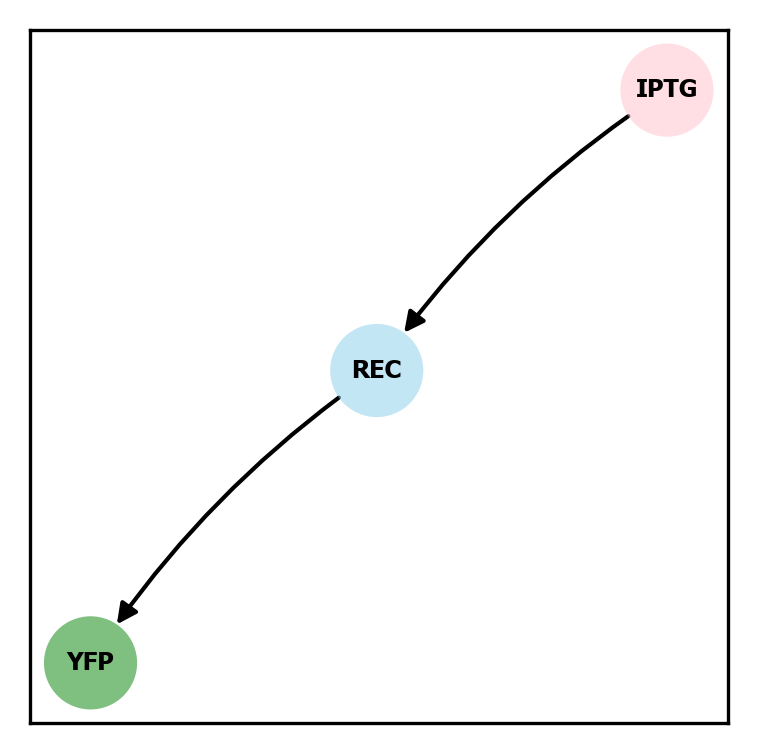

In [163]:
receiver = lc.GeneticNetwork(vector=vector.id[0])

iptg = lc.Supplement(name='IPTG')

yfp_rep = lc.Reporter(name='YFP', degradation_rate=0, signal_id=yfp.id[0], color='green')
receiver.add_reporter(yfp_rep)

iptg_rec_yfp = lc.Receiver(input=iptg, output=yfp_rep, alpha=[1e-3,1e4], K=1e-5, n=2)
receiver.add_operator(iptg_rec_yfp)

plt.figure(figsize=(3,3), dpi=300)
receiver.draw()

# NOT characterization

## SrpR

In [164]:
vector2 = fj.get('vector', name='pSrpR-S3_cyan')

In [165]:
inverter = lc.GeneticNetwork(vector=vector2.id[0])

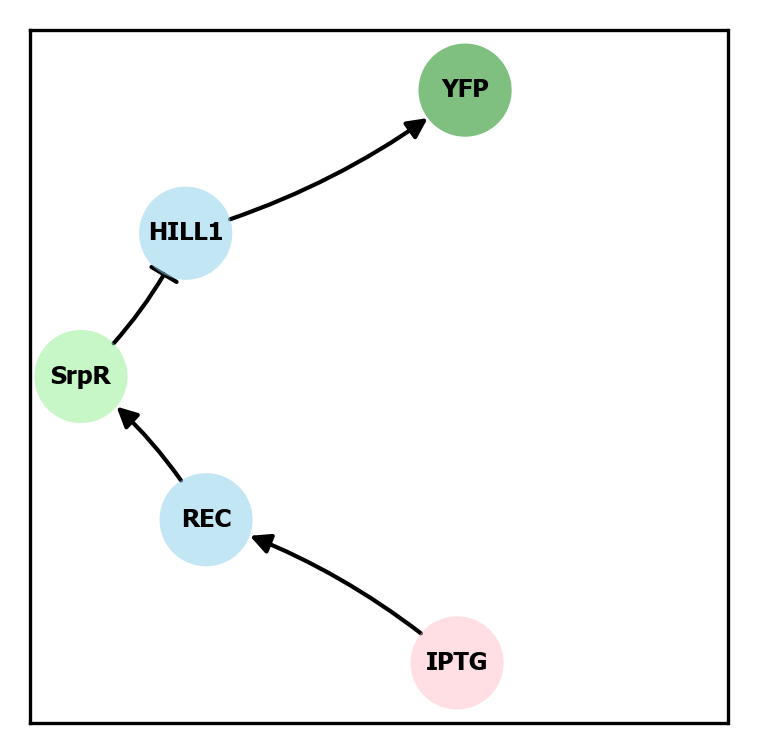

In [166]:
inverter.add_reporter(yfp_rep)

srpr_reg = lc.Regulator('SrpR')
inverter.add_regulator(srpr_reg)

iptg_rec_srpr = iptg_rec_yfp
iptg_rec_srpr.output = srpr_reg
srpr_not_yfp = lc.Hill1(input=srpr_reg, output=yfp_rep, alpha=[1e4,1e-3], K=1e4, n=2)
inverter.add_operator([srpr_not_yfp, iptg_rec_srpr])

plt.figure(figsize=(3,3), dpi=300)
inverter.draw()

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.58it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.46it/s]


Returning dataframe
[1.e+04 1.e+01 1.e+04 4.e+00 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02]
0
3683.0135843701046
[3.98107171e+03 1.00000000e+01 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
1745.8925163858196
[1.00000000e+04 1.25892541e+01 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
3670.8403907477605
[1.00000000

0
3697.18886366247
[1.00000000e+04 1.00000000e+01 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.58489319e+02 1.00000000e+02 1.00000000e+02]
0
3692.310928592069
[1.00000000e+04 1.00000000e+01 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.58489319e+02 1.00000000e+02]
0
3688.4877359217307
[1.00000000e+04 1.00000000e+01 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000

0
313.3004428341569
[3.39808770e+03 4.35177954e+01 7.13894840e+03 3.84124365e+00
 1.66198749e+02 1.31322676e+02 1.01399545e+02 7.31047974e+01
 5.68331695e+01 4.81112605e+01 4.16799685e+01 3.61998853e+01
 3.34196608e+01 3.28977107e+01 3.27041198e+01 3.01427412e+01
 2.81027410e+01 2.76828958e+01 3.70949837e+01 2.54924058e+01
 2.31797315e+01 2.24587964e+01 2.35108321e+01 2.35666237e+01]
0
311.1638121090501
[3.39808770e+03 4.35177954e+01 7.13894840e+03 3.84124365e+00
 1.66198749e+02 1.31322676e+02 1.01399545e+02 7.31047974e+01
 5.68331695e+01 4.81112605e+01 4.16799685e+01 3.61998853e+01
 3.34196608e+01 3.28977107e+01 3.27041198e+01 3.01427412e+01
 2.81027410e+01 2.76828958e+01 2.67085412e+01 3.52412987e+01
 2.31797315e+01 2.24587964e+01 2.35108321e+01 2.35666237e+01]
0
309.18807199653486
[3.39808770e+03 4.35177954e+01 7.13894840e+03 3.84124365e+00
 1.66198749e+02 1.31322676e+02 1.01399545e+02 7.31047974e+01
 5.68331695e+01 4.81112605e+01 4.16799685e+01 3.61998853e+01
 3.34196608e+01 3.2897

0
33.51944386838102
[1.92897113e+03 4.58610124e+01 7.48794358e+03 3.73828182e+00
 2.36785383e+02 1.56927995e+02 1.03884833e+02 5.87335114e+01
 3.91492456e+01 3.28620267e+01 3.05688881e+01 2.80446452e+01
 2.56948406e+01 2.41892399e+01 2.41335532e+01 2.90291595e+01
 1.86047977e+01 1.71733096e+01 1.67635429e+01 1.46997047e+01
 1.36964297e+01 1.21175790e+01 1.18611848e+01 1.30498866e+01]
0
32.524926148815624
[1.92897113e+03 4.58610124e+01 7.48794358e+03 3.73828182e+00
 2.36785383e+02 1.56927995e+02 1.03884833e+02 5.87335114e+01
 3.91492456e+01 3.28620267e+01 3.05688881e+01 2.80446452e+01
 2.56948406e+01 2.41892399e+01 2.41335532e+01 2.13722138e+01
 2.49222614e+01 1.71733096e+01 1.67635429e+01 1.46997047e+01
 1.36964297e+01 1.21175790e+01 1.18611848e+01 1.30498866e+01]
0
31.73988878507588
[1.92897113e+03 4.58610124e+01 7.48794358e+03 3.73828182e+00
 2.36785383e+02 1.56927995e+02 1.03884833e+02 5.87335114e+01
 3.91492456e+01 3.28620267e+01 3.05688881e+01 2.80446452e+01
 2.56948406e+01 2.4189

0
25.272567073822625
[1.59035844e+03 4.10406196e+01 7.64177920e+03 3.74498564e+00
 2.60209973e+02 1.81486088e+02 1.25807934e+02 6.11898704e+01
 3.20720821e+01 2.37354776e+01 5.49203560e+01 2.83896990e+01
 4.89973623e+01 1.23880287e+01 3.21612197e+01 2.48602289e+01
 2.17347791e+01 1.25364891e+01 1.70770235e+01 1.46119269e+01
 1.20440905e+01 7.83681425e+00 1.42876631e+01 2.31801023e+01]
0
26.277466577840425
[1.59035844e+03 4.10406196e+01 7.64177920e+03 3.74498564e+00
 2.60209973e+02 1.81486088e+02 1.25807934e+02 6.11898704e+01
 3.20720821e+01 2.37354776e+01 5.49203560e+01 2.83896990e+01
 3.43970056e+01 1.59331785e+01 3.21612197e+01 2.48602289e+01
 2.17347791e+01 1.25364891e+01 1.70770235e+01 1.46119269e+01
 1.20440905e+01 7.83681425e+00 1.42876631e+01 2.31801023e+01]
0
22.840554812515673
[1.59035844e+03 4.10406196e+01 7.64177920e+03 3.74498564e+00
 2.60209973e+02 1.81486088e+02 1.25807934e+02 6.11898704e+01
 3.20720821e+01 2.37354776e+01 5.49203560e+01 2.83896990e+01
 3.43970056e+01 1.23

0
25.607872836903297
[1.54109841e+03 4.10243225e+01 7.70659316e+03 3.80614854e+00
 2.71874517e+02 1.73607037e+02 1.37418352e+02 6.76571507e+01
 3.16278094e+01 2.13759311e+01 5.76778235e+01 2.26169906e+01
 3.52531864e+01 1.16375004e+01 3.20228118e+01 2.22958008e+01
 1.98161841e+01 1.29186948e+01 1.77538806e+01 1.46503556e+01
 1.13981049e+01 8.14659862e+00 1.40572870e+01 1.83480144e+01]
0
21.177367479881244
[1.54109841e+03 4.10243225e+01 7.70659316e+03 3.80614854e+00
 2.71874517e+02 1.73607037e+02 1.37418352e+02 6.76571507e+01
 2.31046393e+01 2.90347135e+01 5.76778235e+01 2.26169906e+01
 3.52531864e+01 1.16375004e+01 3.20228118e+01 2.22958008e+01
 1.98161841e+01 1.29186948e+01 1.77538806e+01 1.46503556e+01
 1.13981049e+01 8.14659862e+00 1.40572870e+01 1.83480144e+01]
0
21.205552043902802
[1.54109841e+03 4.10243225e+01 7.70659316e+03 3.80614854e+00
 2.71874517e+02 1.73607037e+02 1.37418352e+02 6.76571507e+01
 2.31046393e+01 2.13759311e+01 8.65186532e+01 2.26169906e+01
 3.52531864e+01 1.16

0
23.87001302679311
[1.37506302e+03 3.70953853e+01 7.85743700e+03 3.93790762e+00
 2.84063244e+02 3.51616135e+02 1.40930917e+02 7.61977840e+01
 2.68485949e+01 2.48172881e+01 6.15570738e+01 2.71982655e+01
 3.52116632e+01 1.12454506e+01 3.55618134e+01 2.43966532e+01
 2.07262746e+01 1.33306927e+01 1.90185203e+01 1.51821371e+01
 1.17867870e+01 8.29072102e+00 1.42075576e+01 1.84470088e+01]
0
27.71930007471928
[1.37506302e+03 3.70953853e+01 7.85743700e+03 3.93790762e+00
 2.84063244e+02 2.06351674e+02 2.31156924e+02 7.61977840e+01
 2.68485949e+01 2.48172881e+01 6.15570738e+01 2.71982655e+01
 3.52116632e+01 1.12454506e+01 3.55618134e+01 2.43966532e+01
 2.07262746e+01 1.33306927e+01 1.90185203e+01 1.51821371e+01
 1.17867870e+01 8.29072102e+00 1.42075576e+01 1.84470088e+01]
0
29.080355724474558
[1.37506302e+03 3.70953853e+01 7.85743700e+03 3.93790762e+00
 2.84063244e+02 2.06351674e+02 1.40930917e+02 1.17526709e+02
 2.68485949e+01 2.48172881e+01 6.15570738e+01 2.71982655e+01
 3.52116632e+01 1.1245

0
99.1058556933055
[1.29735173e+03 3.60836951e+01 1.98552905e+04 4.07946272e+00
 2.81652466e+02 2.17487131e+02 1.55360735e+02 7.32465476e+01
 2.67837786e+01 2.54050517e+01 6.21919975e+01 2.43774740e+01
 3.91382311e+01 1.49924091e+01 3.62879437e+01 2.50609667e+01
 2.25563753e+01 1.39495101e+01 1.99519359e+01 1.60341582e+01
 1.21250990e+01 8.43302194e+00 1.43610023e+01 1.85000078e+01]
0
673.4991714555451
[1.29735173e+03 3.60836951e+01 8.07532898e+03 4.69529913e+00
 2.81652466e+02 2.17487131e+02 1.55360735e+02 7.32465476e+01
 2.67837786e+01 2.54050517e+01 6.21919975e+01 2.43774740e+01
 3.91382311e+01 1.49924091e+01 3.62879437e+01 2.50609667e+01
 2.25563753e+01 1.39495101e+01 1.99519359e+01 1.60341582e+01
 1.21250990e+01 8.43302194e+00 1.43610023e+01 1.85000078e+01]
0
23.313436214408938
[1.29735173e+03 3.60836951e+01 8.07532898e+03 4.07946272e+00
 4.95090865e+02 2.17487131e+02 1.55360735e+02 7.32465476e+01
 2.67837786e+01 2.54050517e+01 6.21919975e+01 2.43774740e+01
 3.91382311e+01 1.49924

0
19.819939418459242
[1.23710461e+03 3.53167716e+01 8.23295955e+03 4.17173307e+00
 3.68325876e+02 1.51387448e+02 2.14029213e+02 7.71008051e+01
 1.42881738e+01 2.79802000e+01 6.71344139e+01 3.05792908e+01
 3.29971952e+01 1.87753222e+01 3.70283954e+01 2.63197918e+01
 2.09394172e+01 1.90301816e+01 1.91338837e+01 1.60391098e+01
 1.28487538e+01 8.86705736e+00 1.48552298e+01 1.85244699e+01]
0
20.60205310610059
[1.26756735e+03 3.60983835e+01 8.19179558e+03 4.14048785e+00
 2.93631545e+02 1.99375619e+02 1.71889870e+02 7.21449976e+01
 2.24972848e+01 2.48567256e+01 6.36940128e+01 2.56461758e+01
 3.79662558e+01 1.55497979e+01 3.64340886e+01 2.54359411e+01
 2.24744732e+01 1.48687248e+01 1.99864587e+01 1.61304941e+01
 1.22943571e+01 8.52159630e+00 1.44712789e+01 1.85208998e+01]
0
19.792585368272896
[2.58981147e+03 3.60983835e+01 8.19179558e+03 4.14048785e+00
 2.93631545e+02 1.99375619e+02 1.71889870e+02 7.21449976e+01
 2.24972848e+01 2.48567256e+01 6.36940128e+01 2.56461758e+01
 3.79662558e+01 1.554

0
19.856779574450712
[1.26756735e+03 3.60983835e+01 8.19179558e+03 4.14048785e+00
 2.93631545e+02 1.99375619e+02 1.71889870e+02 7.21449976e+01
 2.24972848e+01 2.48567256e+01 6.36940128e+01 2.56461758e+01
 3.79662558e+01 1.55497979e+01 3.64340886e+01 2.54359411e+01
 2.24744732e+01 1.48687248e+01 1.99864587e+01 1.61304941e+01
 1.58007029e+01 8.52159630e+00 1.44712789e+01 1.85208998e+01]
0
19.811818170868257
[1.26756735e+03 3.60983835e+01 8.19179558e+03 4.14048785e+00
 2.93631545e+02 1.99375619e+02 1.71889870e+02 7.21449976e+01
 2.24972848e+01 2.48567256e+01 6.36940128e+01 2.56461758e+01
 3.79662558e+01 1.55497979e+01 3.64340886e+01 2.54359411e+01
 2.24744732e+01 1.48687248e+01 1.99864587e+01 1.61304941e+01
 1.22943571e+01 1.05577908e+01 1.44712789e+01 1.85208998e+01]
0
19.793572083583797
[1.26756735e+03 3.60983835e+01 8.19179558e+03 4.14048785e+00
 2.93631545e+02 1.99375619e+02 1.71889870e+02 7.21449976e+01
 2.24972848e+01 2.48567256e+01 6.36940128e+01 2.56461758e+01
 3.79662558e+01 1.55

0
19.967561393212332
[1.24321720e+03 3.60106678e+01 8.26300952e+03 4.17764731e+00
 2.97295232e+02 1.98088661e+02 1.73430322e+02 7.14881636e+01
 2.24644653e+01 2.46407193e+01 6.49929510e+01 2.60606128e+01
 3.75844908e+01 1.54746482e+01 3.62522525e+01 2.54565772e+01
 2.24507024e+01 1.94545988e+01 2.00219362e+01 1.61751374e+01
 1.23217209e+01 8.53522588e+00 1.44756880e+01 1.85248815e+01]
0
19.69899965906623
[1.24321720e+03 3.60106678e+01 8.26300952e+03 4.17764731e+00
 2.97295232e+02 1.98088661e+02 1.73430322e+02 7.14881636e+01
 2.24644653e+01 2.46407193e+01 6.49929510e+01 2.60606128e+01
 3.75844908e+01 1.54746482e+01 3.62522525e+01 2.54565772e+01
 2.24507024e+01 1.48538295e+01 2.70182167e+01 1.61751374e+01
 1.23217209e+01 8.53522588e+00 1.44756880e+01 1.85248815e+01]
0
19.759481728813007
[1.24321720e+03 3.60106678e+01 8.26300952e+03 4.17764731e+00
 2.97295232e+02 1.98088661e+02 1.73430322e+02 7.14881636e+01
 2.24644653e+01 2.46407193e+01 6.49929510e+01 2.60606128e+01
 3.75844908e+01 1.547

0
19.888865939630413
[1.24305658e+03 3.60120008e+01 8.26302990e+03 4.17765363e+00
 2.97292032e+02 1.98086287e+02 1.73429490e+02 7.14864830e+01
 2.24645787e+01 3.39479106e+01 6.49923978e+01 2.60604819e+01
 3.75845491e+01 1.54746536e+01 3.62521083e+01 2.54564567e+01
 2.24506628e+01 1.48538823e+01 2.00220186e+01 1.61751829e+01
 1.23217472e+01 8.53523169e+00 1.44756992e+01 1.85248837e+01]
0
20.112843832086313
[1.24305658e+03 3.60120008e+01 8.26302990e+03 4.17765363e+00
 2.97292032e+02 1.98086287e+02 1.73429490e+02 7.14864830e+01
 2.24645787e+01 2.46404268e+01 9.86617503e+01 2.60604819e+01
 3.75845491e+01 1.54746536e+01 3.62521083e+01 2.54564567e+01
 2.24506628e+01 1.48538823e+01 2.00220186e+01 1.61751829e+01
 1.23217472e+01 8.53523169e+00 1.44756992e+01 1.85248837e+01]
0
25.64248557730911
[1.24305658e+03 3.60120008e+01 8.26302990e+03 4.17765363e+00
 2.97292032e+02 1.98086287e+02 1.73429490e+02 7.14864830e+01
 2.24645787e+01 2.46404268e+01 6.49923978e+01 3.61061088e+01
 3.75845491e+01 1.547

0
19.633902510302676
[1.24305658e+03 3.60120008e+01 8.26302990e+03 4.17765363e+00
 2.97292032e+02 1.98086287e+02 1.73429490e+02 7.14864830e+01
 2.24645787e+01 2.46404268e+01 6.49923978e+01 2.60604819e+01
 3.75845491e+01 1.54746536e+01 3.62521083e+01 2.54564567e+01
 2.24506628e+01 1.48538823e+01 2.00220186e+01 1.61751829e+01
 1.23217472e+01 8.53523169e+00 1.44756992e+01 1.85248837e+01]
0
19.624452788029778


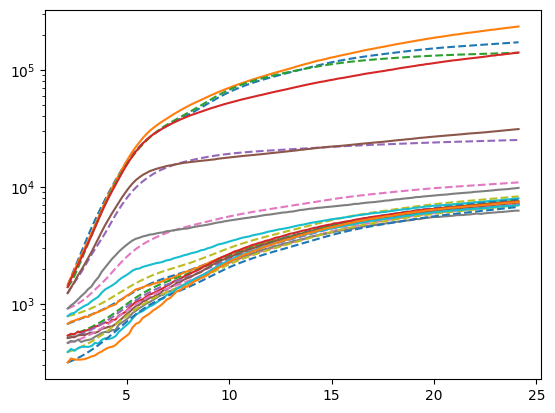

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 0.000e+00 -1.009e-02 ...  9.700e-02  1.011e-01]
           x: [ 7.125e+00  3.584e+00 ...  2.672e+00  2.919e+00]
        cost: 9.81222639401489
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [-2.006e-01 -6.815e-04 ...  0.000e+00  0.000e+00]
               ...
               [-1.767e-03 -9.662e-01 ... -5.222e-02 -3.477e-02]
               [-1.429e-03 -9.664e-01 ... -5.465e-02 -3.967e-02]]
        grad: [ 1.329e+00 -9.034e-01 ... -4.364e-03 -5.720e-04]
  optimality: 22.76600490692277
 active_mask: [0 0 ... 0 0]
        nfev: 24
        njev: 10
[1.24305658e+03 3.60120008e+01 8.26302990e+03 4.17765363e+00
 2.97292032e+02 1.98086287e+02 1.73429490e+02 7.14864830e+01
 2.24645787e+01 2.46404268e+01 6.49923978e+01 2.60604819e+01
 3.75845491e+01 1.54746536e+01 3.62521083e+01 2.54564567e+01
 2.24506628e+01 1.48538823e+01 2.00220186e+01 1.61751829e+01
 1.232

'\nsrpr_not_yfp.characterize( fj,\n    receiver=vector.id,\n    inverter=vector2.id,\n    study=study.id,\n    media=media.id,\n    strain=strain.id,\n    signal=yfp.id,\n    biomass_signal=biomass_signal.id,\n    gamma=0\n)\n'

In [194]:
a = 1e4
b = 1e1
K = 1e4
n = 4
heights = [1e2]*20
initx = np.array([a, b, K, n] + heights)
initx = np.log(initx)
lower_bounds = [-10, -10, 0, 0] + [-10]*20
upper_bounds = [10, 10, 10, np.log(6)] + [10]*20
bounds = [lower_bounds, upper_bounds]

srpr_not_yfp.characterize( fj,
    study=study.id,
    receiver=vector.id[1:2],
    inverter=vector2.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0,
    tmin=2, tmax=25,
    initx=initx,
    bounds=bounds
)

'''
srpr_not_yfp.characterize( fj,
    receiver=vector.id,
    inverter=vector2.id,
    study=study.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)
'''

In [168]:
np.exp(srpr_not_yfp.res.x)

array([1.24305658e+03, 3.60120008e+01, 8.26302990e+03, 4.17765363e+00,
       2.97292032e+02, 1.98086287e+02, 1.73429490e+02, 7.14864830e+01,
       2.24645787e+01, 2.46404268e+01, 6.49923978e+01, 2.60604819e+01,
       3.75845491e+01, 1.54746536e+01, 3.62521083e+01, 2.54564567e+01,
       2.24506628e+01, 1.48538823e+01, 2.00220186e+01, 1.61751829e+01,
       1.23217472e+01, 8.53523169e+00, 1.44756992e+01, 1.85248837e+01])

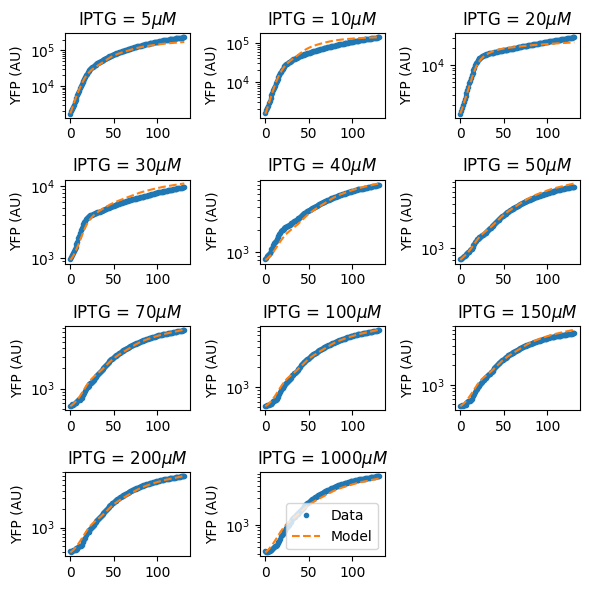

In [169]:
data = srpr_not_yfp.data
model = srpr_not_yfp.model
concs = srpr_not_yfp.concs
len(data)
sp = 1
model_curve = []
data_curve = []
plt.figure(figsize=(6,6))
for d,m,c in zip(data,model,concs):
    model_curve.append(m[-1])
    data_curve.append(d[-1])
    plt.subplot(4,3,sp)
    plt.plot(d[1:], '.')
    plt.plot(m[1:], '--')
    plt.ylabel('YFP (AU)')
    plt.yscale('log')
    plt.title('IPTG = %d$\mu M$'%(c*1e6))
    sp += 1
plt.legend(['Data', 'Model'])
plt.tight_layout()

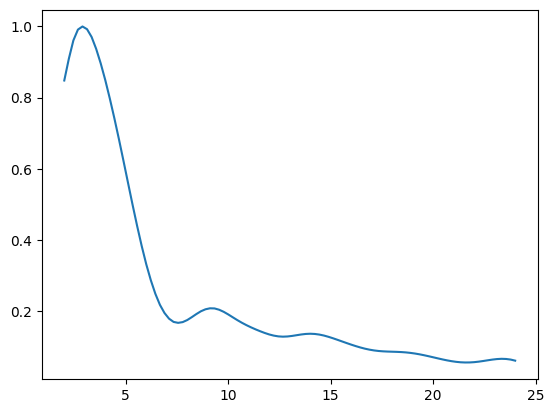

In [20]:
t = np.linspace(2, 24, 100)
plt.plot(t, srpr_not_yfp.profile(t))

In [193]:
srpr_not_yfp.alpha, srpr_not_yfp.K, srpr_not_yfp.n

(array([27.0550812 ,  0.78379989]), 1, 4.177653633524532)

In [22]:
srpr_not_yfp.alpha[0]/srpr_not_yfp.alpha[1]

34.51784273106174

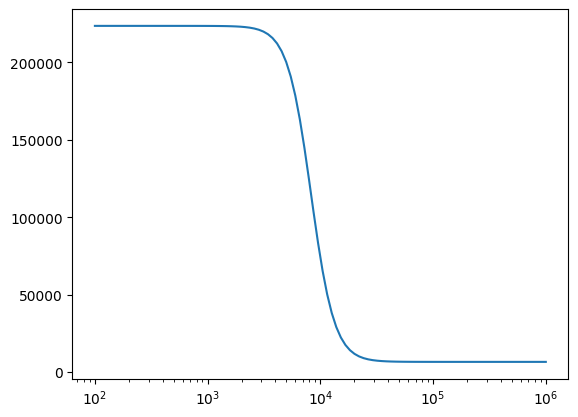

In [23]:
a = srpr_not_yfp.alpha[0]
b = srpr_not_yfp.alpha[1]
K = srpr_not_yfp.K
n = srpr_not_yfp.n

x=np.logspace(2,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## BetI

In [170]:
vector3 = fj.get('vector', name='pBetI-E1_cyan')

In [171]:
inverter_pbeti = lc.GeneticNetwork(vector=vector3.id[0])

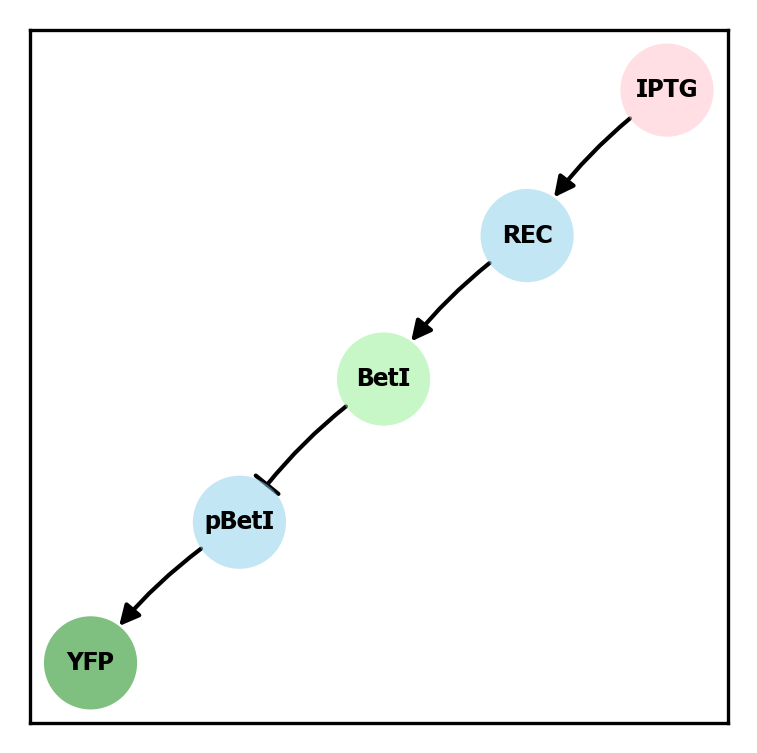

In [172]:
inverter_pbeti.add_reporter(yfp_rep)

beti_reg = lc.Regulator('BetI')
inverter_pbeti.add_regulator(beti_reg)

iptg_rec_beti = iptg_rec_yfp
iptg_rec_beti.output = beti_reg
beti_not_yfp = lc.Hill1(name='pBetI',input=beti_reg, output=yfp_rep, alpha=[1e4,1e-3], K=1e4, n=2)
inverter_pbeti.add_operator([iptg_rec_beti, beti_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pbeti.draw()

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]


Returning dataframe
[1.e+04 1.e+02 1.e+04 4.e+00 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02]
0
3524.8469161756134
[3.98107171e+03 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
2404.8188755287492
[1.00000000e+04 1.58489319e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
4640.221384348932
[1.00000000e

0
3570.6833380805183
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.58489319e+02 1.00000000e+02 1.00000000e+02]
0
3554.951921802138
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.58489319e+02 1.00000000e+02]
0
3538.728189034262
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.0000

0
322.44591502813785
[3.00978359e+03 5.90307208e+01 9.23463252e+03 2.75629928e+00
 2.30178884e+02 1.69925444e+02 1.34718083e+02 9.36278392e+01
 7.30997906e+01 5.77281772e+01 4.85738928e+01 4.34395808e+01
 4.03765719e+01 3.85581014e+01 3.68963826e+01 3.60789982e+01
 3.45486271e+01 3.26195441e+01 4.35610328e+01 3.02263869e+01
 2.93741702e+01 2.96880994e+01 2.96489442e+01 2.56127091e+01]
0
319.33422094729946
[3.00978359e+03 5.90307208e+01 9.23463252e+03 2.75629928e+00
 2.30178884e+02 1.69925444e+02 1.34718083e+02 9.36278392e+01
 7.30997906e+01 5.77281772e+01 4.85738928e+01 4.34395808e+01
 4.03765719e+01 3.85581014e+01 3.68963826e+01 3.60789982e+01
 3.45486271e+01 3.26195441e+01 3.09093053e+01 4.25035163e+01
 2.93741702e+01 2.96880994e+01 2.96489442e+01 2.56127091e+01]
0
317.42045954386606
[3.00978359e+03 5.90307208e+01 9.23463252e+03 2.75629928e+00
 2.30178884e+02 1.69925444e+02 1.34718083e+02 9.36278392e+01
 7.30997906e+01 5.77281772e+01 4.85738928e+01 4.34395808e+01
 4.03765719e+01 3.85

0
93.62803725431431
[2.30381458e+03 5.34238335e+01 1.10541133e+04 1.70722475e+00
 5.20093802e+02 1.45285325e+02 1.39840801e+02 7.08405329e+01
 4.94683085e+01 3.94105975e+01 3.51278945e+01 3.28990256e+01
 2.97149110e+01 2.15341283e+01 2.57543188e+01 3.52107916e+01
 2.15203193e+01 1.77839179e+01 1.82583287e+01 1.78151606e+01
 1.57009390e+01 1.76566968e+01 1.64710658e+01 1.61335787e+01]
0
93.01232693400095
[2.30381458e+03 5.34238335e+01 1.10541133e+04 1.70722475e+00
 5.20093802e+02 1.45285325e+02 1.39840801e+02 7.08405329e+01
 4.94683085e+01 3.94105975e+01 3.51278945e+01 3.28990256e+01
 2.97149110e+01 2.15341283e+01 2.57543188e+01 2.54723433e+01
 2.92505194e+01 1.77839179e+01 1.82583287e+01 1.78151606e+01
 1.57009390e+01 1.76566968e+01 1.64710658e+01 1.61335787e+01]
0
90.87805673431471
[2.30381458e+03 5.34238335e+01 1.10541133e+04 1.70722475e+00
 5.20093802e+02 1.45285325e+02 1.39840801e+02 7.08405329e+01
 4.94683085e+01 3.94105975e+01 3.51278945e+01 3.28990256e+01
 2.97149110e+01 2.15341

0
36.83556842761584
[2.52837815e+03 4.47097140e+01 1.42874485e+04 1.69975183e+00
 3.73256659e+02 1.08016472e+02 1.33779353e+02 5.36348289e+01
 2.98033376e+01 2.95634103e+01 2.72742362e+01 2.90679520e+01
 3.69805737e+01 1.81726137e+01 2.03205358e+01 2.04378319e+01
 1.59961853e+01 1.40974998e+01 1.67292461e+01 1.66850640e+01
 1.14437918e+01 1.26989115e+01 1.34463056e+01 7.63834892e+00]
0
35.46926545989734
[2.52837815e+03 4.47097140e+01 1.42874485e+04 1.69975183e+00
 3.73256659e+02 1.08016472e+02 1.33779353e+02 5.36348289e+01
 2.98033376e+01 2.95634103e+01 2.72742362e+01 2.90679520e+01
 2.66336437e+01 2.42861757e+01 2.03205358e+01 2.04378319e+01
 1.59961853e+01 1.40974998e+01 1.67292461e+01 1.66850640e+01
 1.14437918e+01 1.26989115e+01 1.34463056e+01 7.63834892e+00]
0
33.213683851383394
[2.52837815e+03 4.47097140e+01 1.42874485e+04 1.69975183e+00
 3.73256659e+02 1.08016472e+02 1.33779353e+02 5.36348289e+01
 2.98033376e+01 2.95634103e+01 2.72742362e+01 2.90679520e+01
 2.66336437e+01 1.8172

0
17.390351904374995
[2.49281102e+03 4.05629736e+01 1.42359307e+04 1.82118974e+00
 3.36392346e+02 1.14659223e+02 1.47139895e+02 4.47601394e+01
 3.39519567e+01 2.94950457e+01 3.62508695e+01 2.60567201e+01
 3.64243896e+01 1.72085761e+01 1.99726265e+01 2.16872221e+01
 1.81963042e+01 1.43429064e+01 1.45299665e+01 1.68012700e+01
 9.32037086e+00 2.26134907e+01 1.56509025e+01 4.94232151e+00]
0
15.718887847160994
[2.49281102e+03 4.05629736e+01 1.42359307e+04 1.82118974e+00
 3.36392346e+02 1.14659223e+02 1.47139895e+02 4.47601394e+01
 3.39519567e+01 2.16838064e+01 5.19099094e+01 2.60567201e+01
 3.64243896e+01 1.72085761e+01 1.99726265e+01 2.16872221e+01
 1.81963042e+01 1.43429064e+01 1.45299665e+01 1.68012700e+01
 9.32037086e+00 2.26134907e+01 1.56509025e+01 4.94232151e+00]
0
17.66562297843106
[2.49281102e+03 4.05629736e+01 1.42359307e+04 1.82118974e+00
 3.36392346e+02 1.14659223e+02 1.47139895e+02 4.47601394e+01
 3.39519567e+01 2.16838064e+01 3.62508695e+01 3.61003758e+01
 3.64243896e+01 1.720

0
27.50228859827485
[2.09973091e+03 3.76849035e+01 1.49559780e+04 1.88436263e+00
 4.18262347e+02 1.66546299e+02 1.71597518e+02 6.10140704e+01
 2.92175177e+01 2.18704733e+01 4.01512501e+01 3.88668778e+01
 3.42316586e+01 2.01275679e+01 2.66775654e+01 2.41610571e+01
 1.76951513e+01 1.74686533e+01 1.73433330e+01 1.83821150e+01
 9.42975963e+00 2.24587786e+01 1.64117459e+01 4.95008741e+00]
0
16.653523533655914
[2.09973091e+03 3.76849035e+01 1.49559780e+04 1.88436263e+00
 4.18262347e+02 1.04610977e+02 2.87053008e+02 6.10140704e+01
 2.92175177e+01 2.18704733e+01 4.01512501e+01 3.88668778e+01
 3.42316586e+01 2.01275679e+01 2.66775654e+01 2.41610571e+01
 1.76951513e+01 1.74686533e+01 1.73433330e+01 1.83821150e+01
 9.42975963e+00 2.24587786e+01 1.64117459e+01 4.95008741e+00]
0
35.94750925224564
[2.09973091e+03 3.76849035e+01 1.49559780e+04 1.88436263e+00
 4.18262347e+02 1.04610977e+02 1.71597518e+02 9.20392346e+01
 2.92175177e+01 2.18704733e+01 4.01512501e+01 3.88668778e+01
 3.42316586e+01 2.0127

0
50.57275805953639
[1.87120321e+03 3.31169407e+01 5.69430758e+03 1.91117216e+00
 4.31220348e+02 1.50326355e+02 1.86788189e+02 6.88583098e+01
 3.04528512e+01 2.31670544e+01 4.66998106e+01 5.04493015e+01
 3.01199980e+01 2.46335569e+01 2.87230351e+01 2.78382137e+01
 2.18181456e+01 1.95407922e+01 1.93842340e+01 2.22948659e+01
 1.03910820e+01 2.51038929e+01 1.51089661e+01 4.93147762e+00]
0
506.3538578964103
[1.87120321e+03 3.31169407e+01 1.48837421e+04 2.03905900e+00
 4.31220348e+02 1.50326355e+02 1.86788189e+02 6.88583098e+01
 3.04528512e+01 2.31670544e+01 4.66998106e+01 5.04493015e+01
 3.01199980e+01 2.46335569e+01 2.87230351e+01 2.78382137e+01
 2.18181456e+01 1.95407922e+01 1.93842340e+01 2.22948659e+01
 1.03910820e+01 2.51038929e+01 1.51089661e+01 4.93147762e+00]
0
18.030957707286674
[1.87120321e+03 3.31169407e+01 1.48837421e+04 1.91117216e+00
 7.90986680e+02 1.50326355e+02 1.86788189e+02 6.88583098e+01
 3.04528512e+01 2.31670544e+01 4.66998106e+01 5.04493015e+01
 3.01199980e+01 2.4633

0
13.880601903942697
[1.84523942e+03 3.24042483e+01 1.49224256e+04 1.91677953e+00
 4.15240323e+02 1.74613880e+02 1.82275875e+02 7.93494027e+01
 2.29111451e+01 2.47199914e+01 5.13930721e+01 5.60703560e+01
 2.43192475e+01 2.66795058e+01 3.45628510e+01 2.39619376e+01
 2.35946154e+01 2.19711547e+01 1.86528864e+01 2.23365704e+01
 9.61908185e+00 2.65941758e+01 1.57258817e+01 4.91272148e+00]
0
13.702036809615784
[3.91433504e+03 3.24042483e+01 1.49224256e+04 1.91677953e+00
 4.15240323e+02 1.74613880e+02 1.82275875e+02 7.93494027e+01
 2.29111451e+01 2.47199914e+01 5.13930721e+01 5.60703560e+01
 2.43192475e+01 2.66795058e+01 3.45628510e+01 2.39619376e+01
 2.35946154e+01 2.19711547e+01 1.86528864e+01 2.23365704e+01
 9.61908185e+00 2.65941758e+01 1.57258817e+01 4.91272148e+00]
0
380.07445001266484
[1.84523942e+03 4.58840925e+01 1.49224256e+04 1.91677953e+00
 4.15240323e+02 1.74613880e+02 1.82275875e+02 7.93494027e+01
 2.29111451e+01 2.47199914e+01 5.13930721e+01 5.60703560e+01
 2.43192475e+01 2.66

0
13.75324061775834
[1.84523942e+03 3.24042483e+01 1.49224256e+04 1.91677953e+00
 4.15240323e+02 1.74613880e+02 1.82275875e+02 7.93494027e+01
 2.29111451e+01 2.47199914e+01 5.13930721e+01 5.60703560e+01
 2.43192475e+01 2.66795058e+01 3.45628510e+01 2.39619376e+01
 2.35946154e+01 2.19711547e+01 1.86528864e+01 2.23365704e+01
 9.61908185e+00 3.69202972e+01 1.57258817e+01 4.91272148e+00]
0
13.816633168662424
[1.84523942e+03 3.24042483e+01 1.49224256e+04 1.91677953e+00
 4.15240323e+02 1.74613880e+02 1.82275875e+02 7.93494027e+01
 2.29111451e+01 2.47199914e+01 5.13930721e+01 5.60703560e+01
 2.43192475e+01 2.66795058e+01 3.45628510e+01 2.39619376e+01
 2.35946154e+01 2.19711547e+01 1.86528864e+01 2.23365704e+01
 9.61908185e+00 2.65941758e+01 2.07145978e+01 4.91272148e+00]
0
13.682598747809141
[1.84523942e+03 3.24042483e+01 1.49224256e+04 1.91677953e+00
 4.15240323e+02 1.74613880e+02 1.82275875e+02 7.93494027e+01
 2.29111451e+01 2.47199914e+01 5.13930721e+01 5.60703560e+01
 2.43192475e+01 2.667

0
13.97509796164227
[1.82931574e+03 3.23684739e+01 1.50241293e+04 1.92107351e+00
 4.12179481e+02 1.76355750e+02 1.83740802e+02 7.85006892e+01
 2.31320654e+01 2.52503551e+01 5.09352868e+01 5.50076546e+01
 2.48789995e+01 2.70529024e+01 3.46179949e+01 2.38447466e+01
 3.22539979e+01 2.20525155e+01 1.86736404e+01 2.22977191e+01
 9.52344209e+00 2.65204092e+01 1.58071492e+01 4.91348415e+00]
0
14.02651991278855
[1.82931574e+03 3.23684739e+01 1.50241293e+04 1.92107351e+00
 4.12179481e+02 1.76355750e+02 1.83740802e+02 7.85006892e+01
 2.31320654e+01 2.52503551e+01 5.09352868e+01 5.50076546e+01
 2.48789995e+01 2.70529024e+01 3.46179949e+01 2.38447466e+01
 2.35201233e+01 3.00471960e+01 1.86736404e+01 2.22977191e+01
 9.52344209e+00 2.65204092e+01 1.58071492e+01 4.91348415e+00]
0
13.96602519612676
[1.82931574e+03 3.23684739e+01 1.50241293e+04 1.92107351e+00
 4.12179481e+02 1.76355750e+02 1.83740802e+02 7.85006892e+01
 2.31320654e+01 2.52503551e+01 5.09352868e+01 5.50076546e+01
 2.48789995e+01 2.70529

0
16.576053653993434
[1.83003843e+03 3.23297672e+01 1.50247868e+04 1.92178434e+00
 4.11981391e+02 1.76354366e+02 1.83785883e+02 7.84931098e+01
 2.31301052e+01 2.52364738e+01 5.09186540e+01 8.20391151e+01
 2.48502428e+01 2.70366479e+01 3.45985744e+01 2.38481225e+01
 2.35062272e+01 2.20370624e+01 1.86609368e+01 2.22880693e+01
 9.51858068e+00 2.65143342e+01 1.58056031e+01 4.91361078e+00]
0
16.70666520882651
[1.83003843e+03 3.23297672e+01 1.50247868e+04 1.92178434e+00
 4.11981391e+02 1.76354366e+02 1.83785883e+02 7.84931098e+01
 2.31301052e+01 2.52364738e+01 5.09186540e+01 5.49564994e+01
 3.42660228e+01 2.70366479e+01 3.45985744e+01 2.38481225e+01
 2.35062272e+01 2.20370624e+01 1.86609368e+01 2.22880693e+01
 9.51858068e+00 2.65143342e+01 1.58056031e+01 4.91361078e+00]
0
14.021980099274117
[1.83003843e+03 3.23297672e+01 1.50247868e+04 1.92178434e+00
 4.11981391e+02 1.76354366e+02 1.83785883e+02 7.84931098e+01
 2.31301052e+01 2.52364738e+01 5.09186540e+01 5.49564994e+01
 2.48502428e+01 3.759

0
17.21853240453334
[1.83004457e+03 3.23293114e+01 1.50247942e+04 1.92179114e+00
 7.52247320e+02 1.76354113e+02 1.83786058e+02 7.84932346e+01
 2.31301417e+01 2.52364133e+01 5.09183697e+01 5.49565736e+01
 2.48502424e+01 2.70366098e+01 3.45984957e+01 2.38481311e+01
 2.35062133e+01 2.20370203e+01 1.86609453e+01 2.22880665e+01
 9.51860329e+00 2.65143380e+01 1.58056061e+01 4.91361092e+00]
0
23.076130329715717
[1.83004457e+03 3.23293114e+01 1.50247942e+04 1.92179114e+00
 4.11977329e+02 2.95817698e+02 1.83786058e+02 7.84932346e+01
 2.31301417e+01 2.52364133e+01 5.09183697e+01 5.49565736e+01
 2.48502424e+01 2.70366098e+01 3.45984957e+01 2.38481311e+01
 2.35062133e+01 2.20370203e+01 1.86609453e+01 2.22880665e+01
 9.51860329e+00 2.65143380e+01 1.58056061e+01 4.91361092e+00]
0
19.506627979331604
[1.83004457e+03 3.23293114e+01 1.50247942e+04 1.92179114e+00
 4.11977329e+02 1.76354113e+02 3.09559274e+02 7.84932346e+01
 2.31301417e+01 2.52364133e+01 5.09183697e+01 5.49565736e+01
 2.48502424e+01 2.703

0
13.598781933929299
[3.87890100e+03 3.23290716e+01 1.50247987e+04 1.92179302e+00
 4.11975186e+02 1.76353965e+02 1.83786116e+02 7.84932658e+01
 2.31301613e+01 2.52363772e+01 5.09182499e+01 5.49564685e+01
 2.48501502e+01 2.70366083e+01 3.45984395e+01 2.38481167e+01
 2.35062192e+01 2.20370271e+01 1.86609509e+01 2.22880691e+01
 9.51861339e+00 2.65143497e+01 1.58056131e+01 4.91361110e+00]
0
375.68930313853735
[1.83004787e+03 4.57670117e+01 1.50247987e+04 1.92179302e+00
 4.11975186e+02 1.76353965e+02 1.83786116e+02 7.84932658e+01
 2.31301613e+01 2.52363772e+01 5.09182499e+01 5.49564685e+01
 2.48501502e+01 2.70366083e+01 3.45984395e+01 2.38481167e+01
 2.35062192e+01 2.20370271e+01 1.86609509e+01 2.22880691e+01
 9.51861339e+00 2.65143497e+01 1.58056131e+01 4.91361110e+00]
0
51.471137431407485
[1.83004787e+03 3.23290716e+01 5.74285427e+03 1.92179302e+00
 4.11975186e+02 1.76353965e+02 1.83786116e+02 7.84932658e+01
 2.31301613e+01 2.52363772e+01 5.09182499e+01 5.49564685e+01
 2.48501502e+01 2.70

0
13.64494197081148
[1.83004787e+03 3.23290716e+01 1.50247987e+04 1.92179302e+00
 4.11975186e+02 1.76353965e+02 1.83786116e+02 7.84932658e+01
 2.31301613e+01 2.52363772e+01 5.09182499e+01 5.49564685e+01
 2.48501502e+01 2.70366083e+01 3.45984395e+01 2.38481167e+01
 2.35062192e+01 2.20370271e+01 1.86609509e+01 2.22880691e+01
 9.51861339e+00 2.65143497e+01 2.08301541e+01 4.91361110e+00]
0
13.56685195395959
[1.83004787e+03 3.23290716e+01 1.50247987e+04 1.92179302e+00
 4.11975186e+02 1.76353965e+02 1.83786116e+02 7.84932658e+01
 2.31301613e+01 2.52363772e+01 5.09182499e+01 5.49564685e+01
 2.48501502e+01 2.70366083e+01 3.45984395e+01 2.38481167e+01
 2.35062192e+01 2.20370271e+01 1.86609509e+01 2.22880691e+01
 9.51861339e+00 2.65143497e+01 1.58056131e+01 5.76157020e+00]
0
13.598178238024428
[1.83005465e+03 3.23285106e+01 1.50248079e+04 1.92179589e+00
 4.11971765e+02 1.76353526e+02 1.83786201e+02 7.84933296e+01
 2.31302264e+01 2.52362145e+01 5.09182172e+01 5.49565158e+01
 2.48500677e+01 2.7036

0
13.661276005914365
[1.83005465e+03 3.23285106e+01 1.50248079e+04 1.92179589e+00
 4.11971765e+02 1.76353526e+02 1.83786201e+02 7.84933296e+01
 2.31302264e+01 2.52362145e+01 5.09182172e+01 5.49565158e+01
 2.48500677e+01 2.70365690e+01 3.45983211e+01 2.38480800e+01
 2.35062264e+01 2.20370313e+01 1.86609526e+01 3.04004253e+01
 9.51862786e+00 2.65143600e+01 1.58056316e+01 4.91361129e+00]
0
13.705146760692188
[1.83005465e+03 3.23285106e+01 1.50248079e+04 1.92179589e+00
 4.11971765e+02 1.76353526e+02 1.83786201e+02 7.84933296e+01
 2.31302264e+01 2.52362145e+01 5.09182172e+01 5.49565158e+01
 2.48500677e+01 2.70365690e+01 3.45983211e+01 2.38480800e+01
 2.35062264e+01 2.20370313e+01 1.86609526e+01 2.22880676e+01
 1.19242695e+01 2.65143600e+01 1.58056316e+01 4.91361129e+00]
0
13.575358442464156
[1.83005465e+03 3.23285106e+01 1.50248079e+04 1.92179589e+00
 4.11971765e+02 1.76353526e+02 1.83786201e+02 7.84933296e+01
 2.31302264e+01 2.52362145e+01 5.09182172e+01 5.49565158e+01
 2.48500677e+01 2.70

0
14.444944827830984
[1.83005860e+03 3.23282668e+01 1.50248132e+04 1.92179749e+00
 4.11969773e+02 1.76353219e+02 1.83786287e+02 7.84933515e+01
 2.31302179e+01 2.52361140e+01 5.09182219e+01 5.49564725e+01
 2.48500349e+01 2.70365572e+01 3.45982406e+01 3.27490334e+01
 2.35062195e+01 2.20370346e+01 1.86609597e+01 2.22880653e+01
 9.51863417e+00 2.65143632e+01 1.58056343e+01 4.91361151e+00]
0
13.846393041192634
[1.83005860e+03 3.23282668e+01 1.50248132e+04 1.92179749e+00
 4.11969773e+02 1.76353219e+02 1.83786287e+02 7.84933515e+01
 2.31302179e+01 2.52361140e+01 5.09182219e+01 5.49564725e+01
 2.48500349e+01 2.70365572e+01 3.45982406e+01 2.38480663e+01
 3.22330251e+01 2.20370346e+01 1.86609597e+01 2.22880653e+01
 9.51863417e+00 2.65143632e+01 1.58056343e+01 4.91361151e+00]
0
13.796496610659583
[1.83005860e+03 3.23282668e+01 1.50248132e+04 1.92179749e+00
 4.11969773e+02 1.76353219e+02 1.83786287e+02 7.84933515e+01
 2.31302179e+01 2.52361140e+01 5.09182219e+01 5.49564725e+01
 2.48500349e+01 2.70

0
18.94198981961161
[1.83005864e+03 3.23282650e+01 1.50248133e+04 1.92179749e+00
 4.11969756e+02 1.76353216e+02 1.83786288e+02 7.84933512e+01
 3.16663275e+01 2.52361136e+01 5.09182209e+01 5.49564717e+01
 2.48500347e+01 2.70365571e+01 3.45982403e+01 2.38480662e+01
 2.35062195e+01 2.20370346e+01 1.86609598e+01 2.22880653e+01
 9.51863423e+00 2.65143632e+01 1.58056343e+01 4.91361151e+00]
0
13.869997664823561
[1.83005864e+03 3.23282650e+01 1.50248133e+04 1.92179749e+00
 4.11969756e+02 1.76353216e+02 1.83786288e+02 7.84933512e+01
 2.31302180e+01 3.48517605e+01 5.09182209e+01 5.49564717e+01
 2.48500347e+01 2.70365571e+01 3.45982403e+01 2.38480662e+01
 2.35062195e+01 2.20370346e+01 1.86609598e+01 2.22880653e+01
 9.51863423e+00 2.65143632e+01 1.58056343e+01 4.91361151e+00]
0
14.098802092780835
[1.83005864e+03 3.23282650e+01 1.50248133e+04 1.92179749e+00
 4.11969756e+02 1.76353216e+02 1.83786288e+02 7.84933512e+01
 2.31302180e+01 2.52361136e+01 7.54328545e+01 5.49564717e+01
 2.48500347e+01 2.703

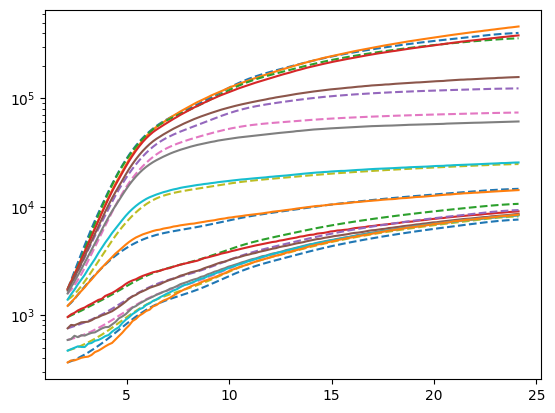

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 0.000e+00 -2.494e-02 ...  9.860e-02  1.045e-01]
           x: [ 7.512e+00  3.476e+00 ...  2.760e+00  1.592e+00]
        cost: 6.778424454167891
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [-2.244e-01 -6.771e-04 ...  0.000e+00  0.000e+00]
               ...
               [-1.707e-01 -8.385e-01 ... -4.888e-02 -7.361e-03]
               [-1.706e-01 -8.387e-01 ... -5.087e-02 -8.417e-03]]
        grad: [-7.143e-01  4.338e-01 ... -6.445e-02 -3.885e-03]
  optimality: 5.846399024539758
 active_mask: [0 0 ... 0 0]
        nfev: 30
        njev: 15
[1.83005864e+03 3.23282650e+01 1.50248133e+04 1.92179749e+00
 4.11969756e+02 1.76353216e+02 1.83786288e+02 7.84933512e+01
 2.31302180e+01 2.52361136e+01 5.09182209e+01 5.49564717e+01
 2.48500347e+01 2.70365571e+01 3.45982403e+01 2.38480662e+01
 2.35062195e+01 2.20370346e+01 1.86609598e+01 2.22880653e+01
 9.51

'\nbeti_not_yfp.characterize( fj,\n    receiver=vector.id,\n    inverter=vector3.id,\n    study=study.id,\n    media=media.id,\n    strain=strain.id,\n    signal=yfp.id,\n    biomass_signal=biomass_signal.id,\n    gamma=0\n)\n'

In [195]:
a = 1e4
b = 1e2
K = 1e4
n = 4
heights = [1e2]*20
initx = np.array([a, b, K, n] + heights)
initx = np.log(initx)
lower_bounds = [-10, -10, 0, 0] + [-10]*20
upper_bounds = [10, 10, 10, np.log(6)] + [10]*20
bounds = [lower_bounds, upper_bounds]

beti_not_yfp.characterize( fj,
    study=study.id,
    receiver=vector.id[1:2],
    inverter=vector3.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0,
    tmin=2, tmax=25,
    initx=initx,
    bounds=bounds
)
'''
beti_not_yfp.characterize( fj,
    receiver=vector.id,
    inverter=vector3.id,
    study=study.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)
'''

In [174]:
np.exp(beti_not_yfp.res.x)

array([1.83005864e+03, 3.23282650e+01, 1.50248133e+04, 1.92179749e+00,
       4.11969756e+02, 1.76353216e+02, 1.83786288e+02, 7.84933512e+01,
       2.31302180e+01, 2.52361136e+01, 5.09182209e+01, 5.49564717e+01,
       2.48500347e+01, 2.70365571e+01, 3.45982403e+01, 2.38480662e+01,
       2.35062195e+01, 2.20370346e+01, 1.86609598e+01, 2.22880653e+01,
       9.51863423e+00, 2.65143632e+01, 1.58056343e+01, 4.91361151e+00])

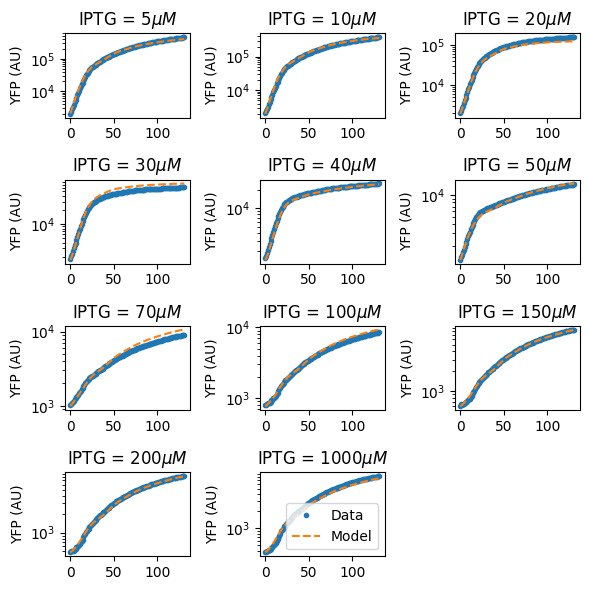

In [175]:
data = beti_not_yfp.data
model = beti_not_yfp.model
concs = beti_not_yfp.concs
len(data)
sp = 1
model_curve = []
data_curve = []
plt.figure(figsize=(6,6))
for d,m,c in zip(data,model,concs):
    model_curve.append(m[-1])
    data_curve.append(d[-1])
    plt.subplot(4,3,sp)
    plt.plot(d[1:], '.')
    plt.plot(m[1:], '--')
    plt.ylabel('YFP (AU)')
    plt.yscale('log')
    plt.title('IPTG = %d$\mu M$'%(c*1e6))
    sp += 1
plt.legend(['Data', 'Model'])
plt.tight_layout()
    

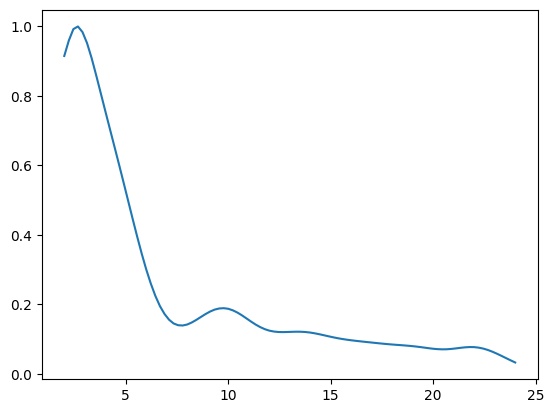

In [30]:
t = np.linspace(2, 24, 100)
plt.plot(t, beti_not_yfp.profile(t))

In [176]:
beti_not_yfp.alpha, beti_not_yfp.K, beti_not_yfp.n

(array([386381.37857986,   6825.48598004]),
 15024.813291578172,
 1.9217974920711958)

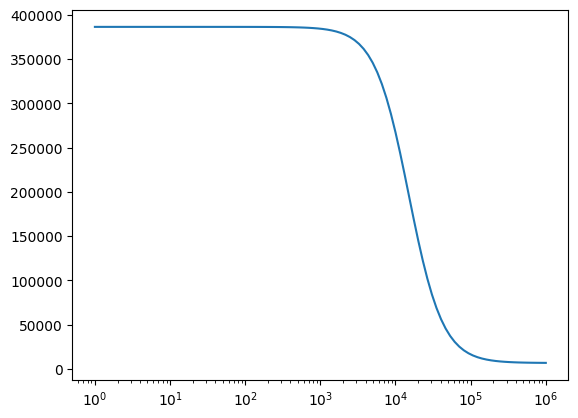

In [32]:
a = beti_not_yfp.alpha[0]
b = beti_not_yfp.alpha[1]
K = beti_not_yfp.K
n = beti_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## QacR

In [177]:
vector4 = fj.get('vector', name='pQacR_Q1_cyan')

In [178]:
inverter_pqacr = lc.GeneticNetwork(vector=vector4.id[0])

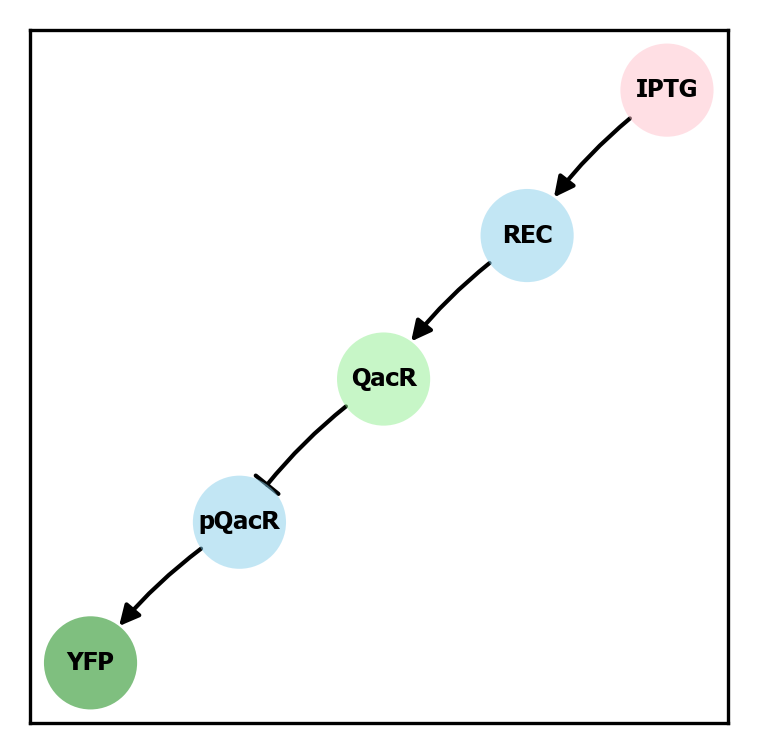

In [179]:
inverter_pqacr.add_reporter(yfp_rep)

qacr_reg = lc.Regulator('QacR')
inverter_pqacr.add_regulator(qacr_reg)

iptg_rec_qacr = iptg_rec_yfp
iptg_rec_qacr.output = qacr_reg
qacr_not_yfp = lc.Hill1(name='pQacR',input=qacr_reg, output=yfp_rep, alpha=[1e4,1e-3], K=1e4, n=2)
inverter_pqacr.add_operator([iptg_rec_qacr, qacr_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pqacr.draw()

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.28it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.88it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.47it/s]


Returning dataframe
[1.e+04 1.e+02 1.e+04 4.e+00 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02]
0
5946.948211716608
[3.98107171e+03 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
4657.400662631434
[1.00000000e+04 1.58489319e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
7658.534562716243
[1.00000000e+0

0
6016.032384871891
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.58489319e+02 1.00000000e+02 1.00000000e+02]
0
5993.674959986647
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.58489319e+02 1.00000000e+02]
0
5972.031744506111
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000

0
407.3310323962068
[4.37313385e+03 3.99613507e+01 6.53709635e+03 3.83395393e+00
 1.34731646e+03 2.31625794e+02 1.43753493e+02 9.19742833e+01
 6.77636631e+01 5.22903689e+01 4.34424822e+01 3.92695095e+01
 3.83525669e+01 3.75715999e+01 3.66576208e+01 3.51020758e+01
 3.34038510e+01 3.22858060e+01 4.35993488e+01 2.97940998e+01
 2.86381544e+01 2.74676641e+01 2.74802914e+01 2.57087428e+01]
0
403.8938910338324
[4.37313385e+03 3.99613507e+01 6.53709635e+03 3.83395393e+00
 1.34731646e+03 2.31625794e+02 1.43753493e+02 9.19742833e+01
 6.77636631e+01 5.22903689e+01 4.34424822e+01 3.92695095e+01
 3.83525669e+01 3.75715999e+01 3.66576208e+01 3.51020758e+01
 3.34038510e+01 3.22858060e+01 3.09340203e+01 4.18353392e+01
 2.86381544e+01 2.74676641e+01 2.74802914e+01 2.57087428e+01]
0
400.9985128480473
[4.37313385e+03 3.99613507e+01 6.53709635e+03 3.83395393e+00
 1.34731646e+03 2.31625794e+02 1.43753493e+02 9.19742833e+01
 6.77636631e+01 5.22903689e+01 4.34424822e+01 3.92695095e+01
 3.83525669e+01 3.75715

0
73.6533470351058
[2.18479566e+03 3.42937246e+01 7.97928774e+03 2.88405790e+00
 1.14088649e+03 2.79070825e+02 1.43352445e+02 7.57253089e+01
 4.95691251e+01 3.25584820e+01 2.69379905e+01 2.52258521e+01
 2.76644415e+01 3.03757669e+01 2.83114880e+01 3.50785334e+01
 2.44537907e+01 2.44712720e+01 2.08031513e+01 1.72563081e+01
 1.52409904e+01 1.93602199e+01 1.63861911e+01 1.95236567e+01]
0
72.37424034497899
[2.18479566e+03 3.42937246e+01 7.97928774e+03 2.88405790e+00
 1.14088649e+03 2.79070825e+02 1.43352445e+02 7.57253089e+01
 4.95691251e+01 3.25584820e+01 2.69379905e+01 2.52258521e+01
 2.76644415e+01 3.03757669e+01 2.83114880e+01 2.53853477e+01
 3.36651698e+01 2.44712720e+01 2.08031513e+01 1.72563081e+01
 1.52409904e+01 1.93602199e+01 1.63861911e+01 1.95236567e+01]
0
71.65083101920462
[2.18479566e+03 3.42937246e+01 7.97928774e+03 2.88405790e+00
 1.14088649e+03 2.79070825e+02 1.43352445e+02 7.57253089e+01
 4.95691251e+01 3.25584820e+01 2.69379905e+01 2.52258521e+01
 2.76644415e+01 3.037576

0
56.728655649118686
[1.82198333e+03 2.98340488e+01 7.68686252e+03 2.47589965e+00
 1.00669438e+03 5.60962659e+02 1.33107094e+02 9.10302495e+01
 3.62515545e+01 3.33199900e+01 2.53125577e+01 2.61087410e+01
 3.57052032e+01 4.59236260e+01 2.46836013e+01 2.69055418e+01
 2.58234916e+01 2.54590850e+01 2.12556120e+01 1.02945234e+01
 1.83484269e+01 2.06179766e+01 1.67463252e+01 1.48527207e+01]
0
56.753146381131444
[1.82198333e+03 2.98340488e+01 7.68686252e+03 2.47589965e+00
 1.00669438e+03 5.60962659e+02 1.33107094e+02 9.10302495e+01
 3.62515545e+01 3.33199900e+01 2.53125577e+01 2.61087410e+01
 2.57972908e+01 6.73348332e+01 2.46836013e+01 2.69055418e+01
 2.58234916e+01 2.54590850e+01 2.12556120e+01 1.02945234e+01
 1.83484269e+01 2.06179766e+01 1.67463252e+01 1.48527207e+01]
0
60.20604691144307
[1.82198333e+03 2.98340488e+01 7.68686252e+03 2.47589965e+00
 1.00669438e+03 5.60962659e+02 1.33107094e+02 9.10302495e+01
 3.62515545e+01 3.33199900e+01 2.53125577e+01 2.61087410e+01
 2.57972908e+01 4.592

0
58.99920243390119
[1.62943985e+03 2.49666744e+01 7.16086102e+03 2.38032618e+00
 1.46169946e+03 5.27226105e+02 1.41160502e+02 1.17782710e+02
 6.52459791e+01 2.87590430e+01 2.37703501e+01 4.37624145e+01
 2.53054581e+01 5.92905265e+01 2.42733151e+01 3.06134220e+01
 2.84500691e+01 3.04570008e+01 2.40309083e+01 1.24489830e+01
 2.12275390e+01 2.21612577e+01 1.87008045e+01 1.47141644e+01]
0
54.265491208205596
[1.62943985e+03 2.49666744e+01 7.16086102e+03 2.38032618e+00
 1.46169946e+03 5.27226105e+02 1.41160502e+02 1.17782710e+02
 4.46266535e+01 4.02394349e+01 2.37703501e+01 4.37624145e+01
 2.53054581e+01 5.92905265e+01 2.42733151e+01 3.06134220e+01
 2.84500691e+01 3.04570008e+01 2.40309083e+01 1.24489830e+01
 2.12275390e+01 2.21612577e+01 1.87008045e+01 1.47141644e+01]
0
53.69262583226235
[1.62943985e+03 2.49666744e+01 7.16086102e+03 2.38032618e+00
 1.46169946e+03 5.27226105e+02 1.41160502e+02 1.17782710e+02
 4.46266535e+01 2.87590430e+01 3.26316577e+01 4.37624145e+01
 2.53054581e+01 5.9290

0
56.5656949072924
[1.75475971e+03 2.49618897e+01 6.74095683e+03 2.34558233e+00
 3.03137250e+03 5.33563305e+02 1.40625670e+02 1.19230375e+02
 4.48284458e+01 2.72695165e+01 2.27306793e+01 4.42713187e+01
 2.37511082e+01 6.02224437e+01 2.41629753e+01 3.10259687e+01
 2.90215676e+01 3.09693129e+01 2.43681058e+01 1.26142599e+01
 2.13927681e+01 2.22930284e+01 1.87990676e+01 1.47140402e+01]
0
62.56607403138929
[1.75475971e+03 2.49618897e+01 6.74095683e+03 2.34558233e+00
 1.46260362e+03 9.99780240e+02 1.40625670e+02 1.19230375e+02
 4.48284458e+01 2.72695165e+01 2.27306793e+01 4.42713187e+01
 2.37511082e+01 6.02224437e+01 2.41629753e+01 3.10259687e+01
 2.90215676e+01 3.09693129e+01 2.43681058e+01 1.26142599e+01
 2.13927681e+01 2.22930284e+01 1.87990676e+01 1.47140402e+01]
0
62.73405594883532
[1.75475971e+03 2.49618897e+01 6.74095683e+03 2.34558233e+00
 1.46260362e+03 5.33563305e+02 2.30606246e+02 1.19230375e+02
 4.48284458e+01 2.72695165e+01 2.27306793e+01 4.42713187e+01
 2.37511082e+01 6.022244

0
242.87450990042527
[1.82638711e+03 3.38539281e+01 6.64667748e+03 2.38442246e+00
 1.45042668e+03 5.38412794e+02 1.48744827e+02 1.20291593e+02
 4.64400058e+01 2.66911082e+01 2.05119405e+01 4.54669591e+01
 2.42368749e+01 6.11364214e+01 2.44250859e+01 3.28054109e+01
 2.90007689e+01 3.11415411e+01 2.50438602e+01 1.27555228e+01
 2.17693895e+01 2.24153568e+01 1.86182804e+01 1.46896524e+01]
0
110.765511287372
[1.82638711e+03 2.45784051e+01 1.60274735e+04 2.38442246e+00
 1.45042668e+03 5.38412794e+02 1.48744827e+02 1.20291593e+02
 4.64400058e+01 2.66911082e+01 2.05119405e+01 4.54669591e+01
 2.42368749e+01 6.11364214e+01 2.44250859e+01 3.28054109e+01
 2.90007689e+01 3.11415411e+01 2.50438602e+01 1.27555228e+01
 2.17693895e+01 2.24153568e+01 1.86182804e+01 1.46896524e+01]
0
628.6906610964558
[1.82638711e+03 2.45784051e+01 6.64667748e+03 2.60088724e+00
 1.45042668e+03 5.38412794e+02 1.48744827e+02 1.20291593e+02
 4.64400058e+01 2.66911082e+01 2.05119405e+01 4.54669591e+01
 2.42368749e+01 6.11364

0
52.03501632779033
[1.82638711e+03 2.45784051e+01 6.64667748e+03 2.38442246e+00
 1.45042668e+03 5.38412794e+02 1.48744827e+02 1.20291593e+02
 4.64400058e+01 2.66911082e+01 2.05119405e+01 4.54669591e+01
 2.42368749e+01 6.11364214e+01 2.44250859e+01 3.28054109e+01
 2.90007689e+01 3.11415411e+01 2.50438602e+01 1.27555228e+01
 2.17693895e+01 2.24153568e+01 1.86182804e+01 1.92181984e+01]
0
52.0393445296796
[1.87760523e+03 2.44129747e+01 6.40504880e+03 2.33497675e+00
 1.43420576e+03 5.65535558e+02 1.49137351e+02 1.12382424e+02
 4.88408020e+01 3.16653885e+01 1.94710819e+01 4.27854135e+01
 2.45449445e+01 6.71019625e+01 1.97371962e+01 3.39240815e+01
 2.90447973e+01 3.21097166e+01 2.62622759e+01 1.26880381e+01
 2.15872940e+01 2.30118883e+01 1.88704274e+01 1.47274588e+01]
0
52.87009544570982
[1.85330909e+03 2.45220850e+01 6.57364689e+03 2.37494475e+00
 1.44742631e+03 5.44999205e+02 1.48810168e+02 1.18567072e+02
 4.70946695e+01 2.78168198e+01 2.02999599e+01 4.48255939e+01
 2.42966753e+01 6.245813

0
52.19385227019704
[1.85330909e+03 2.45220850e+01 6.57364689e+03 2.37494475e+00
 1.44742631e+03 5.44999205e+02 1.48810168e+02 1.18567072e+02
 4.70946695e+01 2.78168198e+01 2.02999599e+01 4.48255939e+01
 2.42966753e+01 6.24581338e+01 2.33135127e+01 3.30581837e+01
 2.90794730e+01 3.14936659e+01 2.54184691e+01 1.64769497e+01
 2.17975528e+01 2.25922411e+01 1.86911261e+01 1.47022375e+01]
0
52.00367399583876
[1.85330909e+03 2.45220850e+01 6.57364689e+03 2.37494475e+00
 1.44742631e+03 5.44999205e+02 1.48810168e+02 1.18567072e+02
 4.70946695e+01 2.78168198e+01 2.02999599e+01 4.48255939e+01
 2.42966753e+01 6.24581338e+01 2.33135127e+01 3.30581837e+01
 2.90794730e+01 3.14936659e+01 2.54184691e+01 1.27717865e+01
 2.96652841e+01 2.25922411e+01 1.86911261e+01 1.47022375e+01]
0
52.079822086608274
[1.85330909e+03 2.45220850e+01 6.57364689e+03 2.37494475e+00
 1.44742631e+03 5.44999205e+02 1.48810168e+02 1.18567072e+02
 4.70946695e+01 2.78168198e+01 2.02999599e+01 4.48255939e+01
 2.42966753e+01 6.2458

0
52.2429251310692
[1.85647573e+03 2.45275665e+01 6.57322931e+03 2.37547144e+00
 1.44765552e+03 5.45224994e+02 1.48882959e+02 1.18640174e+02
 4.71175007e+01 2.76789551e+01 2.03144549e+01 4.48585041e+01
 2.42987595e+01 6.24839140e+01 2.33258228e+01 4.69363190e+01
 2.90773896e+01 3.15011760e+01 2.54279516e+01 1.27762655e+01
 2.18029764e+01 2.25976722e+01 1.86942158e+01 1.47028014e+01]
0
52.770718158496024
[1.85647573e+03 2.45275665e+01 6.57322931e+03 2.37547144e+00
 1.44765552e+03 5.45224994e+02 1.48882959e+02 1.18640174e+02
 4.71175007e+01 2.76789551e+01 2.03144549e+01 4.48585041e+01
 2.42987595e+01 6.24839140e+01 2.33258228e+01 3.30790981e+01
 4.07296762e+01 3.15011760e+01 2.54279516e+01 1.27762655e+01
 2.18029764e+01 2.25976722e+01 1.86942158e+01 1.47028014e+01]
0
52.45276455734184
[1.85647573e+03 2.45275665e+01 6.57322931e+03 2.37547144e+00
 1.44765552e+03 5.45224994e+02 1.48882959e+02 1.18640174e+02
 4.71175007e+01 2.76789551e+01 2.03144549e+01 4.48585041e+01
 2.42987595e+01 6.24839

0
53.21761086434981
[1.85660182e+03 2.45259541e+01 6.57328213e+03 2.37545626e+00
 1.44765984e+03 5.45197793e+02 1.48884712e+02 1.18641231e+02
 4.71191946e+01 3.85773143e+01 2.03139151e+01 4.48600811e+01
 2.42992182e+01 6.24853848e+01 2.33260833e+01 3.30789656e+01
 2.90773461e+01 3.15015231e+01 2.54283016e+01 1.27764357e+01
 2.18031916e+01 2.25977861e+01 1.86944033e+01 1.47029041e+01]
0
52.610109647745844
[1.85660182e+03 2.45259541e+01 6.57328213e+03 2.37545626e+00
 1.44765984e+03 5.45197793e+02 1.48884712e+02 1.18641231e+02
 4.71191946e+01 2.76770622e+01 2.74519371e+01 4.48600811e+01
 2.42992182e+01 6.24853848e+01 2.33260833e+01 3.30789656e+01
 2.90773461e+01 3.15015231e+01 2.54283016e+01 1.27764357e+01
 2.18031916e+01 2.25977861e+01 1.86944033e+01 1.47029041e+01]
0
52.15851032762095
[1.85660182e+03 2.45259541e+01 6.57328213e+03 2.37545626e+00
 1.44765984e+03 5.45197793e+02 1.48884712e+02 1.18641231e+02
 4.71191946e+01 2.76770622e+01 2.03139151e+01 6.56214859e+01
 2.42992182e+01 6.2485

0
61.752119315758975
[1.85666331e+03 2.45251860e+01 6.57329075e+03 2.37544341e+00
 1.44766031e+03 1.02377366e+03 1.48885543e+02 1.18639312e+02
 4.71196995e+01 2.76759859e+01 2.03139647e+01 4.48602300e+01
 2.42992671e+01 6.24857037e+01 2.33268228e+01 3.30789957e+01
 2.90771605e+01 3.15018014e+01 2.54281549e+01 1.27764616e+01
 2.18032903e+01 2.25978570e+01 1.86944498e+01 1.47029173e+01]
0
63.24776868720005
[1.85666331e+03 2.45251860e+01 6.57329075e+03 2.37544341e+00
 1.44766031e+03 5.45191462e+02 2.45548782e+02 1.18639312e+02
 4.71196995e+01 2.76759859e+01 2.03139647e+01 4.48602300e+01
 2.42992671e+01 6.24857037e+01 2.33268228e+01 3.30789957e+01
 2.90771605e+01 3.15018014e+01 2.54281549e+01 1.27764616e+01
 2.18032903e+01 2.25978570e+01 1.86944498e+01 1.47029173e+01]
0
54.811639436664876
[1.85666331e+03 2.45251860e+01 6.57329075e+03 2.37544341e+00
 1.44766031e+03 5.45191462e+02 1.48885543e+02 1.91272036e+02
 4.71196995e+01 2.76759859e+01 2.03139647e+01 4.48602300e+01
 2.42992671e+01 6.248

0
51.8800838951097
[3.94102353e+03 2.45251225e+01 6.57329087e+03 2.37544420e+00
 1.44766053e+03 5.45191523e+02 1.48885656e+02 1.18639451e+02
 4.71197569e+01 2.76759004e+01 2.03139691e+01 4.48602095e+01
 2.42992923e+01 6.24857457e+01 2.33268363e+01 3.30789841e+01
 2.90771697e+01 3.15018083e+01 2.54281696e+01 1.27764530e+01
 2.18032954e+01 2.25978620e+01 1.86944512e+01 1.47029167e+01]
0
247.44501222708283
[1.85667325e+03 3.37732072e+01 6.57329087e+03 2.37544420e+00
 1.44766053e+03 5.45191523e+02 1.48885656e+02 1.18639451e+02
 4.71197569e+01 2.76759004e+01 2.03139691e+01 4.48602095e+01
 2.42992923e+01 6.24857457e+01 2.33268363e+01 3.30789841e+01
 2.90771697e+01 3.15018083e+01 2.54281696e+01 1.27764530e+01
 2.18032954e+01 2.25978620e+01 1.86944512e+01 1.47029167e+01]
0
111.18961899032817
[1.85667325e+03 2.45251225e+01 1.58329243e+04 2.37544420e+00
 1.44766053e+03 5.45191523e+02 1.48885656e+02 1.18639451e+02
 4.71197569e+01 2.76759004e+01 2.03139691e+01 4.48602095e+01
 2.42992923e+01 6.2485

0
51.93109827840638
[1.85667325e+03 2.45251225e+01 6.57329087e+03 2.37544420e+00
 1.44766053e+03 5.45191523e+02 1.48885656e+02 1.18639451e+02
 4.71197569e+01 2.76759004e+01 2.03139691e+01 4.48602095e+01
 2.42992923e+01 6.24857457e+01 2.33268363e+01 3.30789841e+01
 2.90771697e+01 3.15018083e+01 2.54281696e+01 1.27764530e+01
 2.18032954e+01 2.25978620e+01 2.50543992e+01 1.47029167e+01]
0
51.89072909024193
[1.85667325e+03 2.45251225e+01 6.57329087e+03 2.37544420e+00
 1.44766053e+03 5.45191523e+02 1.48885656e+02 1.18639451e+02
 4.71197569e+01 2.76759004e+01 2.03139691e+01 4.48602095e+01
 2.42992923e+01 6.24857457e+01 2.33268363e+01 3.30789841e+01
 2.90771697e+01 3.15018083e+01 2.54281696e+01 1.27764530e+01
 2.18032954e+01 2.25978620e+01 1.86944512e+01 1.92372880e+01]
0
51.880724894701146
[1.85669042e+03 2.45250386e+01 6.57325656e+03 2.37544507e+00
 1.44766132e+03 5.45189113e+02 1.48885525e+02 1.18638821e+02
 4.71198369e+01 2.76756287e+01 2.03139474e+01 4.48601569e+01
 2.42992755e+01 6.2485

0
52.282522531122744
[1.85667753e+03 2.45251008e+01 6.57328222e+03 2.37544442e+00
 1.44766073e+03 5.45190919e+02 1.48885623e+02 1.18639293e+02
 4.71197768e+01 2.76758325e+01 2.03139637e+01 4.48601962e+01
 2.42992881e+01 6.24857250e+01 2.33268454e+01 3.30789153e+01
 2.90771705e+01 3.15018147e+01 3.51436390e+01 1.27764556e+01
 2.18032980e+01 2.25978662e+01 1.86944528e+01 1.47029169e+01]
0
52.276420326302215
[1.85667753e+03 2.45251008e+01 6.57328222e+03 2.37544442e+00
 1.44766073e+03 5.45190919e+02 1.48885623e+02 1.18639293e+02
 4.71197768e+01 2.76758325e+01 2.03139637e+01 4.48601962e+01
 2.42992881e+01 6.24857250e+01 2.33268454e+01 3.30789153e+01
 2.90771705e+01 3.15018147e+01 2.54281760e+01 1.64835757e+01
 2.18032980e+01 2.25978662e+01 1.86944528e+01 1.47029169e+01]
0
51.89812962930109
[1.85667753e+03 2.45251008e+01 6.57328222e+03 2.37544442e+00
 1.44766073e+03 5.45190919e+02 1.48885623e+02 1.18639293e+02
 4.71197768e+01 2.76758325e+01 2.03139637e+01 4.48601962e+01
 2.42992881e+01 6.248

0
53.94321777792943
[1.85667764e+03 2.45251000e+01 6.57328217e+03 2.37544442e+00
 1.44766071e+03 5.45190884e+02 1.48885621e+02 1.18639291e+02
 4.71197769e+01 2.76758308e+01 2.03139629e+01 4.48601946e+01
 3.34312710e+01 6.24857259e+01 2.33268456e+01 3.30789126e+01
 2.90771709e+01 3.15018153e+01 2.54281743e+01 1.27764553e+01
 2.18032980e+01 2.25978663e+01 1.86944528e+01 1.47029169e+01]
0
52.31594398215093
[1.85667764e+03 2.45251000e+01 6.57328217e+03 2.37544442e+00
 1.44766071e+03 5.45190884e+02 1.48885621e+02 1.18639291e+02
 4.71197769e+01 2.76758308e+01 2.03139629e+01 4.48601946e+01
 2.42992872e+01 9.44841371e+01 2.33268456e+01 3.30789126e+01
 2.90771709e+01 3.15018153e+01 2.54281743e+01 1.27764553e+01
 2.18032980e+01 2.25978663e+01 1.86944528e+01 1.47029169e+01]
0
56.41238445534677
[1.85667764e+03 2.45251000e+01 6.57328217e+03 2.37544442e+00
 1.44766071e+03 5.45190884e+02 1.48885621e+02 1.18639291e+02
 4.71197769e+01 2.76758308e+01 2.03139629e+01 4.48601946e+01
 2.42992872e+01 6.24857

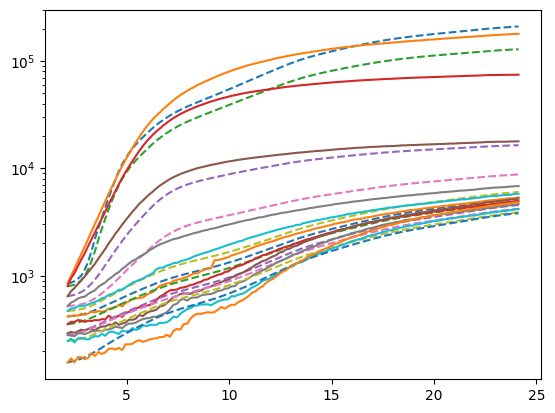

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 0.000e+00  1.459e-01 ...  2.335e-01  2.408e-01]
           x: [ 7.527e+00  3.200e+00 ...  2.928e+00  2.688e+00]
        cost: 25.912991820980775
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [-1.209e-02 -5.215e-03 ...  0.000e+00  0.000e+00]
               ...
               [-4.465e-03 -9.602e-01 ... -6.727e-02 -3.079e-02]
               [-4.992e-03 -9.635e-01 ... -6.977e-02 -3.367e-02]]
        grad: [-1.257e+00  1.310e-01 ... -1.062e-02 -1.695e-03]
  optimality: 4.067705206265768
 active_mask: [0 0 ... 0 0]
        nfev: 28
        njev: 14
[1.85667764e+03 2.45251000e+01 6.57328217e+03 2.37544442e+00
 1.44766071e+03 5.45190884e+02 1.48885621e+02 1.18639291e+02
 4.71197769e+01 2.76758308e+01 2.03139629e+01 4.48601946e+01
 2.42992872e+01 6.24857259e+01 2.33268456e+01 3.30789126e+01
 2.90771709e+01 3.15018153e+01 2.54281743e+01 1.27764553e+01
 2.1

'\nqacr_not_yfp.characterize( fj,\n    receiver=iptg_rec_yfp,\n    inverter=vector4.id,\n    media=media.id,\n    strain=strain.id,\n    signal=yfp.id,\n    biomass_signal=biomass_signal.id,\n    gamma=0\n)\n'

In [196]:
a = 1e4
b = 1e2
K = 1e4
n = 4
heights = [1e2]*20
initx = np.array([a, b, K, n] + heights)
initx = np.log(initx)
lower_bounds = [-10, -10, 0, 0] + [-10]*20
upper_bounds = [10, 10, 10, np.log(6)] + [10]*20
bounds = [lower_bounds, upper_bounds]

qacr_not_yfp.characterize( fj,
    study=study.id,
    receiver=vector.id[1:2],
    inverter=vector4.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0,
    tmin=2, tmax=25,
    initx=initx,
    bounds=bounds
)
'''
qacr_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector4.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)
'''

In [ ]:
rec_df = fj.analysis(vector=vector.id,
                            study=study.id,
                            signal=yfp.id,
                            media=media.id,
                            strain=strain.id,
                            type='Background Correct',
                            remove_data=False,
                            bg_correction=2,
                            biomass_signal=biomass_signal.id)

In [ ]:
rec_df.Concentration1.unique()

In [181]:
np.exp(qacr_not_yfp.res.x)

array([1.85667764e+03, 2.45251000e+01, 6.57328217e+03, 2.37544442e+00,
       1.44766071e+03, 5.45190884e+02, 1.48885621e+02, 1.18639291e+02,
       4.71197769e+01, 2.76758308e+01, 2.03139629e+01, 4.48601946e+01,
       2.42992872e+01, 6.24857259e+01, 2.33268456e+01, 3.30789126e+01,
       2.90771709e+01, 3.15018153e+01, 2.54281743e+01, 1.27764553e+01,
       2.18032980e+01, 2.25978663e+01, 1.86944528e+01, 1.47029169e+01])

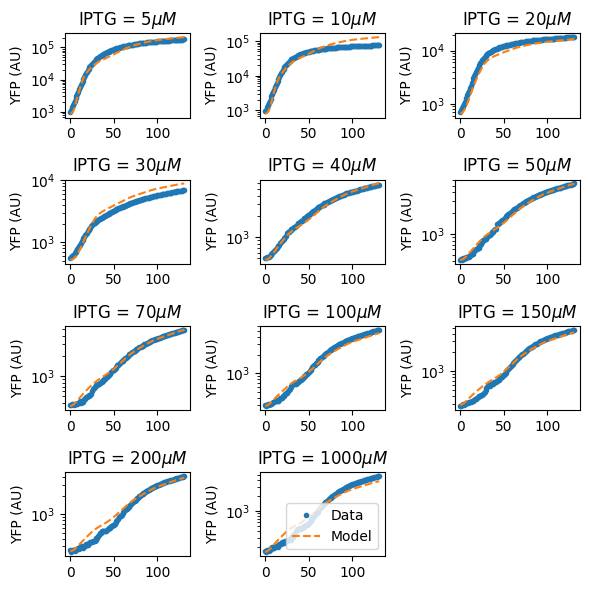

In [182]:
data = qacr_not_yfp.data
model = qacr_not_yfp.model
concs = qacr_not_yfp.concs
len(data)
sp = 1
model_curve = []
data_curve = []
plt.figure(figsize=(6,6))
for d,m,c in zip(data,model,concs):
    model_curve.append(m[-1])
    data_curve.append(d[-1])
    plt.subplot(4,3,sp)
    plt.plot(d[1:], '.')
    plt.plot(m[1:], '--')
    plt.ylabel('YFP (AU)')
    plt.yscale('log')
    plt.title('IPTG = %d$\mu M$'%(c*1e6))
    sp += 1
plt.legend(['Data', 'Model'])
plt.tight_layout()

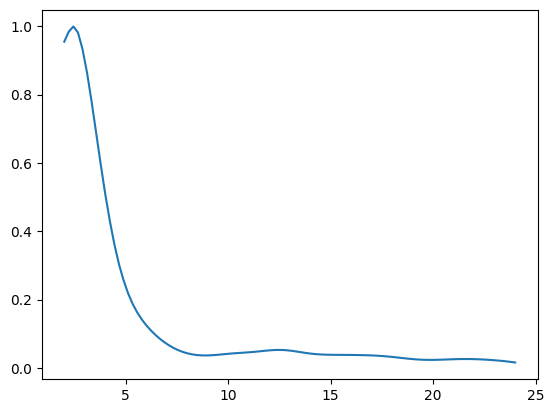

In [11]:
t = np.linspace(2, 24, 100)
plt.plot(t, qacr_not_yfp.profile(t))

In [183]:
qacr_not_yfp.alpha, qacr_not_yfp.K, qacr_not_yfp.n

(array([1273281.82446956,   16818.9476132 ]),
 6573.282168556034,
 2.37544442359394)

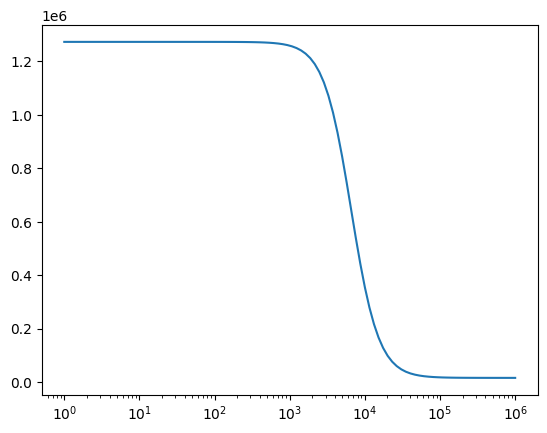

In [13]:
a = qacr_not_yfp.alpha[0]
b = qacr_not_yfp.alpha[1]
K = qacr_not_yfp.K
n = qacr_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## pBM3R1-B2_cyan

In [33]:
vector5 = fj.get('vector', name='pBM3R1-B2_cyan')

In [34]:
inverter_pbm3r1 = lc.GeneticNetwork(vector=vector5.id[0])

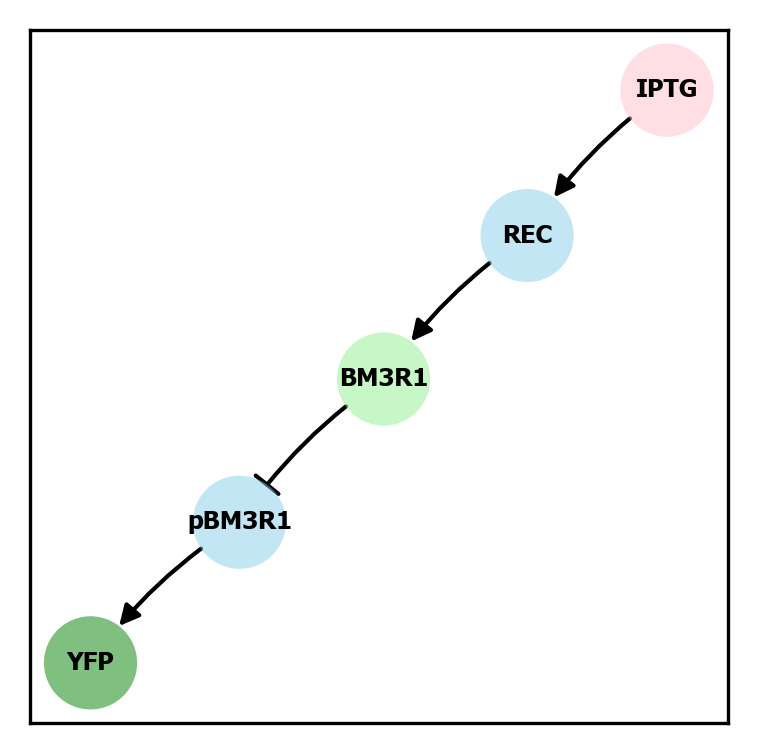

In [35]:
inverter_pbm3r1.add_reporter(yfp_rep)

bm3r1_reg = lc.Regulator('BM3R1')
inverter_pbm3r1.add_regulator(bm3r1_reg)

iptg_rec_bm3r1 = iptg_rec_yfp
iptg_rec_bm3r1.output = bm3r1_reg
bm3r1_not_yfp = lc.Hill1(name='pBM3R1',input=bm3r1_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter_pbm3r1.add_operator([iptg_rec_bm3r1, bm3r1_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pbm3r1.draw()

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.32it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.83it/s]


Returning dataframe
[1.e+04 1.e+02 1.e+04 4.e+00 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02]
0
9590.121235588173
[3.98107171e+03 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
7724.603479972044
[1.00000000e+04 1.58489319e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
11697.013723820546
[1.00000000e+

0
9671.954214509336
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.58489319e+02 1.00000000e+02 1.00000000e+02]
0
9646.34936417724
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.58489319e+02 1.00000000e+02]
0
9619.421173024637
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.000000

0
922.169766000623
[3.29022504e+03 3.64804885e+01 5.74748164e+03 3.27220203e+00
 1.68813746e+02 1.46822799e+02 1.12363054e+02 8.01292119e+01
 6.48058470e+01 5.05750573e+01 4.07980326e+01 3.49434631e+01
 3.24068046e+01 3.05502682e+01 2.85005597e+01 2.65766364e+01
 2.55654985e+01 2.44061779e+01 3.06282806e+01 2.22535248e+01
 2.21182873e+01 2.10806978e+01 2.26153710e+01 2.12561808e+01]
0
918.8152456155583
[3.29022504e+03 3.64804885e+01 5.74748164e+03 3.27220203e+00
 1.68813746e+02 1.46822799e+02 1.12363054e+02 8.01292119e+01
 6.48058470e+01 5.05750573e+01 4.07980326e+01 3.49434631e+01
 3.24068046e+01 3.05502682e+01 2.85005597e+01 2.65766364e+01
 2.55654985e+01 2.44061779e+01 2.24398816e+01 3.03486021e+01
 2.21182873e+01 2.10806978e+01 2.26153710e+01 2.12561808e+01]
0
916.8175761982473
[3.29022504e+03 3.64804885e+01 5.74748164e+03 3.27220203e+00
 1.68813746e+02 1.46822799e+02 1.12363054e+02 8.01292119e+01
 6.48058470e+01 5.05750573e+01 4.07980326e+01 3.49434631e+01
 3.24068046e+01 3.055026

0
226.5162240906005
[4.60227370e+02 3.88107169e+01 1.59914642e+04 3.21975811e+00
 4.79588307e+01 1.33732777e+02 1.07448956e+02 6.28625790e+01
 3.66970883e+01 2.81143601e+01 2.33439370e+01 1.94171513e+01
 1.77971263e+01 1.69902656e+01 1.44892707e+01 1.65241276e+01
 1.12621785e+01 1.03065606e+01 8.76485015e+00 8.19035168e+00
 7.81536763e+00 6.98010460e+00 8.31418429e+00 6.60455125e+00]
0
226.25874109971383
[4.60227370e+02 3.88107169e+01 1.59914642e+04 3.21975811e+00
 4.79588307e+01 1.33732777e+02 1.07448956e+02 6.28625790e+01
 3.66970883e+01 2.81143601e+01 2.33439370e+01 1.94171513e+01
 1.77971263e+01 1.69902656e+01 1.44892707e+01 1.28050268e+01
 1.43477780e+01 1.03065606e+01 8.76485015e+00 8.19035168e+00
 7.81536763e+00 6.98010460e+00 8.31418429e+00 6.60455125e+00]
0
225.93514831611157
[4.60227370e+02 3.88107169e+01 1.59914642e+04 3.21975811e+00
 4.79588307e+01 1.33732777e+02 1.07448956e+02 6.28625790e+01
 3.66970883e+01 2.81143601e+01 2.33439370e+01 1.94171513e+01
 1.77971263e+01 1.699

0
86.34739879517896
[6.01560118e+02 3.75451180e+01 1.64699584e+04 1.83237339e+00
 3.91032819e+01 1.35890231e+02 1.04921073e+02 6.13247610e+01
 3.62009331e+01 2.54179987e+01 2.79264755e+01 1.44883848e+01
 2.96194826e+01 9.48984365e+00 1.30449331e+01 1.09432336e+01
 1.28689795e+01 6.15254646e+00 6.86921688e+00 5.60389836e+00
 4.54708146e+00 7.02270981e+00 4.32805761e+00 2.56631608e+01]
0
90.28744996003132
[6.01560118e+02 3.75451180e+01 1.64699584e+04 1.83237339e+00
 3.91032819e+01 1.35890231e+02 1.04921073e+02 6.13247610e+01
 3.62009331e+01 2.54179987e+01 2.79264755e+01 1.44883848e+01
 2.17669559e+01 1.18846108e+01 1.30449331e+01 1.09432336e+01
 1.28689795e+01 6.15254646e+00 6.86921688e+00 5.60389836e+00
 4.54708146e+00 7.02270981e+00 4.32805761e+00 2.56631608e+01]
0
84.14037808724032
[6.01560118e+02 3.75451180e+01 1.64699584e+04 1.83237339e+00
 3.91032819e+01 1.35890231e+02 1.04921073e+02 6.13247610e+01
 3.62009331e+01 2.54179987e+01 2.79264755e+01 1.44883848e+01
 2.17669559e+01 9.48984

0
77.3520166462211
[7.27885505e+02 3.20448439e+01 1.71546064e+04 1.27877595e+00
 5.51844505e+01 1.20357763e+02 9.38233985e+01 5.67420634e+01
 2.27772600e+01 2.58919425e+01 2.24904395e+01 1.41366008e+01
 2.05626960e+01 8.69082259e+00 1.18324883e+01 9.77942809e+00
 1.01610808e+01 4.91648262e+00 5.78731949e+00 4.88124034e+00
 5.10435033e+00 4.21231381e+00 3.54910668e+00 1.45724292e+01]
0
77.58271939383641
[7.27885505e+02 3.20448439e+01 1.71546064e+04 1.27877595e+00
 5.51844505e+01 1.20357763e+02 9.38233985e+01 5.67420634e+01
 2.27772600e+01 1.92617225e+01 3.07041965e+01 1.41366008e+01
 2.05626960e+01 8.69082259e+00 1.18324883e+01 9.77942809e+00
 1.01610808e+01 4.91648262e+00 5.78731949e+00 4.88124034e+00
 5.10435033e+00 4.21231381e+00 3.54910668e+00 1.45724292e+01]
0
82.65469899085863
[7.27885505e+02 3.20448439e+01 1.71546064e+04 1.27877595e+00
 5.51844505e+01 1.20357763e+02 9.38233985e+01 5.67420634e+01
 2.27772600e+01 1.92617225e+01 2.24904395e+01 1.84238121e+01
 2.05626960e+01 8.690822

0
40.79041241608094
[7.48763989e+02 2.58606382e+01 2.16172112e+04 1.27817995e+00
 5.39589838e+01 1.05167536e+02 1.33814392e+02 4.87046546e+01
 1.73934152e+01 1.49685358e+01 1.87576094e+01 1.31399410e+01
 1.80256347e+01 6.53518235e+00 1.09113871e+01 8.33162035e+00
 8.57146505e+00 3.51585896e+00 5.45661974e+00 3.75657528e+00
 5.72341210e+00 2.69027786e+00 5.97695678e+00 7.52255097e+00]
0
47.49097214124479
[7.48763989e+02 2.58606382e+01 2.16172112e+04 1.27817995e+00
 5.39589838e+01 1.05167536e+02 8.57401792e+01 7.18335806e+01
 1.73934152e+01 1.49685358e+01 1.87576094e+01 1.31399410e+01
 1.80256347e+01 6.53518235e+00 1.09113871e+01 8.33162035e+00
 8.57146505e+00 3.51585896e+00 5.45661974e+00 3.75657528e+00
 5.72341210e+00 2.69027786e+00 5.97695678e+00 7.52255097e+00]
0
44.09616006890357
[7.48763989e+02 2.58606382e+01 2.16172112e+04 1.27817995e+00
 5.39589838e+01 1.05167536e+02 8.57401792e+01 4.87046546e+01
 2.31431969e+01 1.49685358e+01 1.87576094e+01 1.31399410e+01
 1.80256347e+01 6.53518

0
362.70213044739756
[6.86690123e+02 2.22951652e+01 2.15512570e+04 1.36624658e+00
 1.26955745e+02 8.73676887e+01 1.00425956e+02 5.54468108e+01
 1.63487943e+01 1.50392184e+01 2.10939643e+01 1.45893068e+01
 2.02565135e+01 5.71659701e+00 1.15073922e+01 1.13192756e+01
 7.35282377e+00 5.36206501e+00 5.72073953e+00 3.66484684e+00
 6.11262725e+00 8.68600402e+00 1.65250394e+00 2.52792874e+01]
0
24.001236881760843
[6.86690123e+02 2.22951652e+01 2.15512570e+04 1.32803115e+00
 2.06071340e+02 8.73676887e+01 1.00425956e+02 5.54468108e+01
 1.63487943e+01 1.50392184e+01 2.10939643e+01 1.45893068e+01
 2.02565135e+01 5.71659701e+00 1.15073922e+01 1.13192756e+01
 7.35282377e+00 5.36206501e+00 5.72073953e+00 3.66484684e+00
 6.11262725e+00 8.68600402e+00 1.65250394e+00 2.52792874e+01]
0
27.24953410587118
[6.86690123e+02 2.22951652e+01 2.15512570e+04 1.32803115e+00
 1.26955745e+02 1.36611082e+02 1.00425956e+02 5.54468108e+01
 1.63487943e+01 1.50392184e+01 2.10939643e+01 1.45893068e+01
 2.02565135e+01 5.716

0
23.382332257271464
[1.26397820e+03 2.25592959e+01 2.17614082e+04 1.34503277e+00
 1.29167073e+02 7.97831428e+01 1.07388808e+02 5.56693888e+01
 1.58622998e+01 1.42747397e+01 2.43983836e+01 1.36831413e+01
 1.78225433e+01 1.30980583e+01 1.05969363e+01 1.09210544e+01
 7.30836422e+00 5.08029253e+00 6.56240036e+00 3.17903379e+00
 7.61784301e+00 6.62548246e+00 1.22743383e+00 2.15159340e+01]
0
330.99117785338836
[6.60333388e+02 3.08076161e+01 2.17614082e+04 1.34503277e+00
 1.29167073e+02 7.97831428e+01 1.07388808e+02 5.56693888e+01
 1.58622998e+01 1.42747397e+01 2.43983836e+01 1.36831413e+01
 1.78225433e+01 1.30980583e+01 1.05969363e+01 1.09210544e+01
 7.30836422e+00 5.08029253e+00 6.56240036e+00 3.17903379e+00
 7.61784301e+00 6.62548246e+00 1.22743383e+00 2.15159340e+01]
0
50.53201413622173
[6.60333388e+02 2.25592959e+01 8.01527258e+03 1.34503277e+00
 1.29167073e+02 7.97831428e+01 1.07388808e+02 5.56693888e+01
 1.58622998e+01 1.42747397e+01 2.43983836e+01 1.36831413e+01
 1.78225433e+01 1.309

0
23.623356205225956
[6.60333388e+02 2.25592959e+01 2.17614082e+04 1.34503277e+00
 1.29167073e+02 7.97831428e+01 1.07388808e+02 5.56693888e+01
 1.58622998e+01 1.42747397e+01 2.43983836e+01 1.36831413e+01
 1.78225433e+01 1.30980583e+01 1.05969363e+01 1.09210544e+01
 7.30836422e+00 5.08029253e+00 6.56240036e+00 3.17903379e+00
 7.61784301e+00 6.62548246e+00 1.25284660e+00 2.15159340e+01]
0
23.38442807354767
[6.60333388e+02 2.25592959e+01 2.17614082e+04 1.34503277e+00
 1.29167073e+02 7.97831428e+01 1.07388808e+02 5.56693888e+01
 1.58622998e+01 1.42747397e+01 2.43983836e+01 1.36831413e+01
 1.78225433e+01 1.30980583e+01 1.05969363e+01 1.09210544e+01
 7.30836422e+00 5.08029253e+00 6.56240036e+00 3.17903379e+00
 7.61784301e+00 6.62548246e+00 1.22743383e+00 2.92439628e+01]
0
23.71792520210172
[7.61602211e+02 2.32862060e+01 2.19450279e+04 1.31619210e+00
 1.14178625e+02 6.38419833e+01 8.36216119e+01 8.28067680e+01
 4.43293217e+00 1.32484133e+01 2.85965600e+01 9.74522111e+00
 1.39554612e+01 1.0411

0
23.30647251523262
[6.60876048e+02 2.13694525e+01 2.20061189e+04 1.33014443e+00
 1.23404544e+02 7.68866604e+01 1.08036425e+02 5.75954033e+01
 1.53586364e+01 1.40264485e+01 2.46711563e+01 1.34787680e+01
 1.74127866e+01 1.28292213e+01 1.04259369e+01 1.06614765e+01
 7.04992648e+00 5.76521884e+00 6.29831588e+00 3.02986006e+00
 7.37184776e+00 6.45423226e+00 1.22474184e+00 2.08883901e+01]
0
23.11473197898136
[6.60876048e+02 2.13694525e+01 2.20061189e+04 1.33014443e+00
 1.23404544e+02 7.68866604e+01 1.08036425e+02 5.75954033e+01
 1.53586364e+01 1.40264485e+01 2.46711563e+01 1.34787680e+01
 1.74127866e+01 1.28292213e+01 1.04259369e+01 1.06614765e+01
 7.04992648e+00 4.91643979e+00 7.57088906e+00 3.02986006e+00
 7.37184776e+00 6.45423226e+00 1.22474184e+00 2.08883901e+01]
0
23.19530590183258
[6.60876048e+02 2.13694525e+01 2.20061189e+04 1.33014443e+00
 1.23404544e+02 7.68866604e+01 1.08036425e+02 5.75954033e+01
 1.53586364e+01 1.40264485e+01 2.46711563e+01 1.34787680e+01
 1.74127866e+01 1.28292

0
23.28093695996718
[6.56803151e+02 2.17089795e+01 2.18680635e+04 1.34255791e+00
 1.21656152e+02 7.56076692e+01 1.09698076e+02 5.76304257e+01
 1.51307147e+01 1.41280112e+01 2.49061539e+01 1.35326535e+01
 1.76072428e+01 1.28181131e+01 1.28253566e+01 1.05266725e+01
 6.95544554e+00 4.95983785e+00 6.25817171e+00 3.03437171e+00
 7.31655337e+00 6.36531832e+00 1.22253534e+00 2.05115857e+01]
0
22.934825570545858
[6.56803151e+02 2.17089795e+01 2.18680635e+04 1.34255791e+00
 1.21656152e+02 7.56076692e+01 1.09698076e+02 5.76304257e+01
 1.51307147e+01 1.41280112e+01 2.49061539e+01 1.35326535e+01
 1.76072428e+01 1.28181131e+01 1.01703492e+01 1.33204906e+01
 6.95544554e+00 4.95983785e+00 6.25817171e+00 3.03437171e+00
 7.31655337e+00 6.36531832e+00 1.22253534e+00 2.05115857e+01]
0
23.13846971509428
[6.56803151e+02 2.17089795e+01 2.18680635e+04 1.34255791e+00
 1.21656152e+02 7.56076692e+01 1.09698076e+02 5.76304257e+01
 1.51307147e+01 1.41280112e+01 2.49061539e+01 1.35326535e+01
 1.76072428e+01 1.2818

0
26.420317116550706
[6.55452714e+02 2.17114421e+01 2.18694152e+04 1.34777064e+00
 1.20961894e+02 7.51281775e+01 1.11102403e+02 5.86479427e+01
 1.50866175e+01 1.41769999e+01 2.56234876e+01 1.77385032e+01
 1.73343575e+01 1.28513774e+01 1.09356491e+01 1.04159856e+01
 7.00434428e+00 4.95514509e+00 6.18931442e+00 2.91377207e+00
 7.02528666e+00 6.13439664e+00 1.21652818e+00 1.93846235e+01]
0
23.48816509006912
[6.55452714e+02 2.17114421e+01 2.18694152e+04 1.34777064e+00
 1.20961894e+02 7.51281775e+01 1.11102403e+02 5.86479427e+01
 1.50866175e+01 1.41769999e+01 2.56234876e+01 1.36577470e+01
 2.30567730e+01 1.28513774e+01 1.09356491e+01 1.04159856e+01
 7.00434428e+00 4.95514509e+00 6.18931442e+00 2.91377207e+00
 7.02528666e+00 6.13439664e+00 1.21652818e+00 1.93846235e+01]
0
24.04632839704427
[6.55452714e+02 2.17114421e+01 2.18694152e+04 1.34777064e+00
 1.20961894e+02 7.51281775e+01 1.11102403e+02 5.86479427e+01
 1.50866175e+01 1.41769999e+01 2.56234876e+01 1.36577470e+01
 1.73343575e+01 1.6589

0
30.107318618790945
[6.55587304e+02 2.18788758e+01 2.18724160e+04 1.35390733e+00
 1.17895122e+02 7.38971109e+01 1.12920022e+02 5.94936646e+01
 1.89787077e+01 1.37738836e+01 2.60026031e+01 1.38119334e+01
 1.72974036e+01 1.28827490e+01 1.05323913e+01 1.06534009e+01
 7.02419024e+00 5.27955552e+00 6.37970978e+00 2.93012307e+00
 6.79887646e+00 5.91128902e+00 1.21078029e+00 1.82159189e+01]
0
23.186696314883203
[6.55587304e+02 2.18788758e+01 2.18724160e+04 1.35390733e+00
 1.17895122e+02 7.38971109e+01 1.12920022e+02 5.94936646e+01
 1.45231418e+01 1.79044939e+01 2.60026031e+01 1.38119334e+01
 1.72974036e+01 1.28827490e+01 1.05323913e+01 1.06534009e+01
 7.02419024e+00 5.27955552e+00 6.37970978e+00 2.93012307e+00
 6.79887646e+00 5.91128902e+00 1.21078029e+00 1.82159189e+01]
0
23.357036282274585
[6.55587304e+02 2.18788758e+01 2.18724160e+04 1.35390733e+00
 1.17895122e+02 7.38971109e+01 1.12920022e+02 5.94936646e+01
 1.45231418e+01 1.37738836e+01 3.60179102e+01 1.38119334e+01
 1.72974036e+01 1.28

0
22.78260923196928
[6.55594182e+02 2.18794598e+01 2.18724170e+04 1.35389957e+00
 1.17893797e+02 7.38963995e+01 1.12920899e+02 5.94942212e+01
 1.45231486e+01 1.37738200e+01 2.60028350e+01 1.38119732e+01
 1.72971770e+01 1.28826385e+01 1.05323184e+01 1.06532724e+01
 7.02405733e+00 5.27952831e+00 6.37964915e+00 2.93010542e+00
 6.79884681e+00 5.91122762e+00 1.21077956e+00 1.82156823e+01]
0
22.703253073118823
[1.25400307e+03 2.18794598e+01 2.18724170e+04 1.35389957e+00
 1.17893797e+02 7.38963995e+01 1.12920899e+02 5.94942212e+01
 1.45231486e+01 1.37738200e+01 2.60028350e+01 1.38119732e+01
 1.72971770e+01 1.28826385e+01 1.05323184e+01 1.06532724e+01
 7.02405733e+00 5.27952831e+00 6.37964915e+00 2.93010542e+00
 6.79884681e+00 5.91122762e+00 1.21077956e+00 1.82156823e+01]
0
317.39646949707503
[6.55594182e+02 2.97879252e+01 2.18724170e+04 1.35389957e+00
 1.17893797e+02 7.38963995e+01 1.12920899e+02 5.94942212e+01
 1.45231486e+01 1.37738200e+01 2.60028350e+01 1.38119732e+01
 1.72971770e+01 1.288

0
22.801500779808354
[6.55594182e+02 2.18794598e+01 2.18724170e+04 1.35389957e+00
 1.17893797e+02 7.38963995e+01 1.12920899e+02 5.94942212e+01
 1.45231486e+01 1.37738200e+01 2.60028350e+01 1.38119732e+01
 1.72971770e+01 1.28826385e+01 1.05323184e+01 1.06532724e+01
 7.02405733e+00 5.27952831e+00 6.37964915e+00 2.93010542e+00
 6.79884681e+00 7.06066247e+00 1.21077956e+00 1.82156823e+01]
0
22.772086038441014
[6.55594182e+02 2.18794598e+01 2.18724170e+04 1.35389957e+00
 1.17893797e+02 7.38963995e+01 1.12920899e+02 5.94942212e+01
 1.45231486e+01 1.37738200e+01 2.60028350e+01 1.38119732e+01
 1.72971770e+01 1.28826385e+01 1.05323184e+01 1.06532724e+01
 7.02405733e+00 5.27952831e+00 6.37964915e+00 2.93010542e+00
 6.79884681e+00 5.91122762e+00 1.23416035e+00 1.82156823e+01]
0
22.704105368931273
[6.55594182e+02 2.18794598e+01 2.18724170e+04 1.35389957e+00
 1.17893797e+02 7.38963995e+01 1.12920899e+02 5.94942212e+01
 1.45231486e+01 1.37738200e+01 2.60028350e+01 1.38119732e+01
 1.72971770e+01 1.28

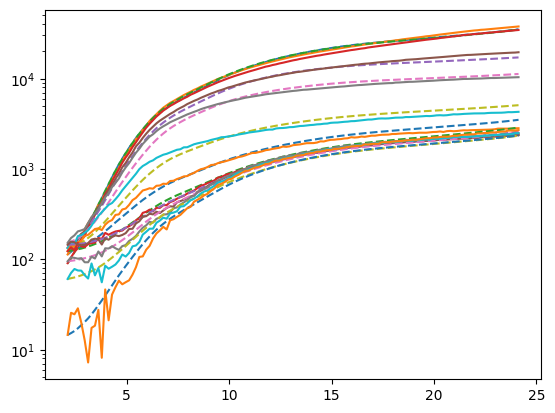

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 0.000e+00  4.373e-02 ...  1.374e-01  1.374e-01]
           x: [ 6.486e+00  3.086e+00 ...  1.913e-01  2.902e+00]
        cost: 11.351626536559412
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [-8.707e-02 -2.313e-03 ...  0.000e+00  0.000e+00]
               ...
               [-4.474e-01 -6.346e-01 ... -9.638e-03 -7.319e-02]
               [-4.439e-01 -6.350e-01 ... -1.003e-02 -8.262e-02]]
        grad: [-5.684e-01 -4.816e-01 ...  2.223e-02  1.451e-01]
  optimality: 4.6414525555760004
 active_mask: [0 0 ... 0 0]
        nfev: 27
        njev: 13
[6.55594182e+02 2.18794598e+01 2.18724170e+04 1.35389957e+00
 1.17893797e+02 7.38963995e+01 1.12920899e+02 5.94942212e+01
 1.45231486e+01 1.37738200e+01 2.60028350e+01 1.38119732e+01
 1.72971770e+01 1.28826385e+01 1.05323184e+01 1.06532724e+01
 7.02405733e+00 5.27952831e+00 6.37964915e+00 2.93010542e+00
 6.

'\nbm3r1_not_yfp.characterize( fj,\n    receiver=iptg_rec_yfp,\n    inverter=vector5.id,\n    media=media.id,\n    strain=strain.id,\n    signal=yfp.id,\n    biomass_signal=biomass_signal.id,\n    gamma=0\n)\n'

In [36]:
a = 1e4
b = 1e2
K = 1e4
n = 4
heights = [1e2]*20
initx = np.array([a, b, K, n] + heights)
initx = np.log(initx)
lower_bounds = [-10, -10, 0, 0] + [-10]*20
upper_bounds = [10, 10, 10, np.log(6)] + [10]*20
bounds = [lower_bounds, upper_bounds]

bm3r1_not_yfp.characterize( fj,
    study=study.id,
    receiver=vector.id[1:2],
    inverter=vector5.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0,
    tmin=2, tmax=25,
    initx=initx,
    bounds=bounds
)
'''
bm3r1_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector5.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)
'''

In [37]:
np.exp(bm3r1_not_yfp.res.x)

array([6.55594182e+02, 2.18794598e+01, 2.18724170e+04, 1.35389957e+00,
       1.17893797e+02, 7.38963995e+01, 1.12920899e+02, 5.94942212e+01,
       1.45231486e+01, 1.37738200e+01, 2.60028350e+01, 1.38119732e+01,
       1.72971770e+01, 1.28826385e+01, 1.05323184e+01, 1.06532724e+01,
       7.02405733e+00, 5.27952831e+00, 6.37964915e+00, 2.93010542e+00,
       6.79884681e+00, 5.91122762e+00, 1.21077956e+00, 1.82156823e+01])

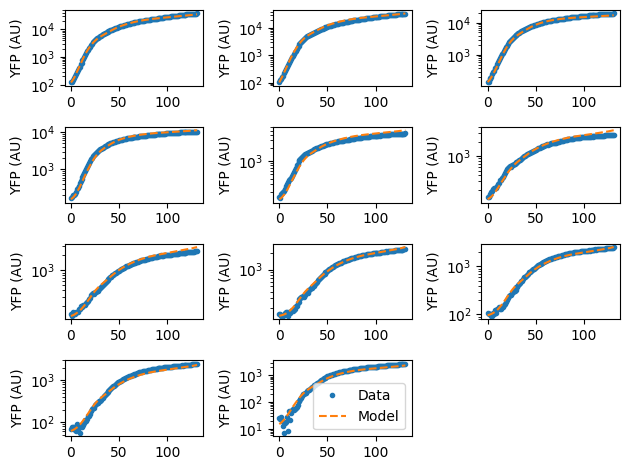

In [38]:
data = bm3r1_not_yfp.data
model = bm3r1_not_yfp.model
len(data)
sp = 1
model_curve = []
data_curve = []
for d,m in zip(data,model):
    model_curve.append(m[-1])
    data_curve.append(d[-1])
    plt.subplot(4, 3, sp)
    plt.plot(d[1:], '.')
    plt.plot(m[1:], '--')
    plt.ylabel('YFP (AU)')
    plt.yscale('log')
    sp += 1
plt.legend(['Data', 'Model'])
plt.tight_layout()

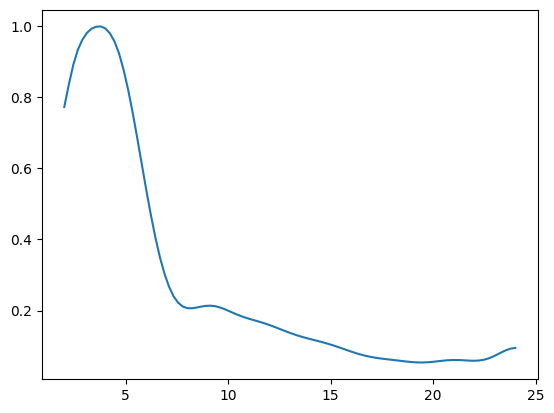

In [39]:
t = np.linspace(2, 24, 100)
plt.plot(t, bm3r1_not_yfp.profile(t))

In [40]:
bm3r1_not_yfp.alpha, bm3r1_not_yfp.K, bm3r1_not_yfp.n

(array([51422.49308641,  1716.14758337]),
 21872.416984673397,
 1.353899572096567)

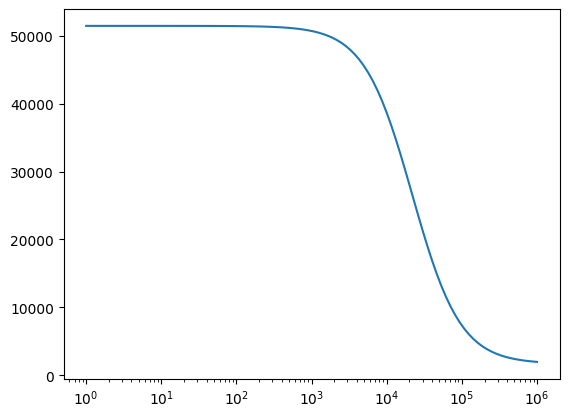

In [41]:
a = bm3r1_not_yfp.alpha[0]
b = bm3r1_not_yfp.alpha[1]
K = bm3r1_not_yfp.K
n = bm3r1_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## lcaRA

In [42]:
vector6 = fj.get('vector', name='plcaRA_I1_cyan')

In [43]:
inverter_plcara = lc.GeneticNetwork(vector=vector6.id[0])

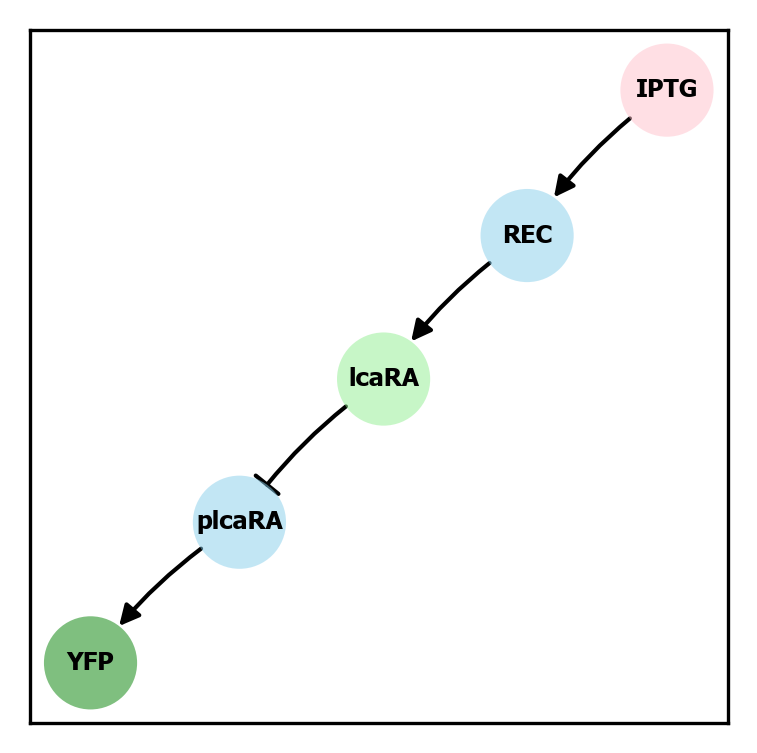

In [44]:
inverter_plcara.add_reporter(yfp_rep)

lcara_reg = lc.Regulator('lcaRA')
inverter_plcara.add_regulator(lcara_reg)

iptg_rec_lcara = iptg_rec_yfp
iptg_rec_lcara.output = lcara_reg
lcara_not_yfp = lc.Hill1(name='plcaRA',input=lcara_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter_plcara.add_operator([iptg_rec_lcara, lcara_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_plcara.draw()

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.24it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.53it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.97it/s]


Returning dataframe
[1.e+04 1.e+02 1.e+04 4.e+00 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02 1.e+02
 1.e+02 1.e+02 1.e+02 1.e+02]
0
2342.7652644689833
[3.98107171e+03 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
1460.5988288321323
[1.00000000e+04 1.58489319e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]
0
2830.8287993587282
[1.00000000

0
2375.868372702108
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.58489319e+02 1.00000000e+02 1.00000000e+02]
0
2365.716055412669
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.58489319e+02 1.00000000e+02]
0
2352.490020642704
[1.00000000e+04 1.00000000e+02 1.00000000e+04 4.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000

0
649.989248921417
[3.65811653e+03 1.06437925e+02 6.67598187e+03 2.56564202e+00
 1.55788352e+02 1.15378931e+03 2.42878637e+02 9.87840431e+01
 9.97655087e+01 8.01052576e+01 6.63453426e+01 6.51360888e+01
 5.61241530e+01 5.28899064e+01 5.08654145e+01 4.93560686e+01
 4.73434531e+01 4.40220151e+01 6.06382933e+01 3.98178646e+01
 3.77857741e+01 3.67490625e+01 2.90278005e+01 4.93856671e+01]
0
647.2628085020335
[3.65811653e+03 1.06437925e+02 6.67598187e+03 2.56564202e+00
 1.55788352e+02 1.15378931e+03 2.42878637e+02 9.87840431e+01
 9.97655087e+01 8.01052576e+01 6.63453426e+01 6.51360888e+01
 5.61241530e+01 5.28899064e+01 5.08654145e+01 4.93560686e+01
 4.73434531e+01 4.40220151e+01 4.17521710e+01 5.75553583e+01
 3.77857741e+01 3.67490625e+01 2.90278005e+01 4.93856671e+01]
0
645.208485254175
[3.65811653e+03 1.06437925e+02 6.67598187e+03 2.56564202e+00
 1.55788352e+02 1.15378931e+03 2.42878637e+02 9.87840431e+01
 9.97655087e+01 8.01052576e+01 6.63453426e+01 6.51360888e+01
 5.61241530e+01 5.2889906

0
456.1435179476653
[1.97614541e+03 1.00063869e+02 5.60126964e+03 1.31352761e+00
 5.31443555e+02 9.70119993e+02 1.58700006e+02 7.90338756e+01
 1.01424530e+02 8.37491732e+01 6.02307278e+01 5.77934555e+01
 4.73900226e+01 5.16082333e+01 3.88748031e+01 5.65877301e+01
 3.85429673e+01 3.52524958e+01 3.30070521e+01 2.86727792e+01
 2.09923046e+01 2.85264374e+01 3.66017346e+01 1.11602986e+01]
0
455.6554780791675
[1.97614541e+03 1.00063869e+02 5.60126964e+03 1.31352761e+00
 5.31443555e+02 9.70119993e+02 1.58700006e+02 7.90338756e+01
 1.01424530e+02 8.37491732e+01 6.02307278e+01 5.77934555e+01
 4.73900226e+01 5.16082333e+01 3.88748031e+01 3.92088301e+01
 5.55315327e+01 3.52524958e+01 3.30070521e+01 2.86727792e+01
 2.09923046e+01 2.85264374e+01 3.66017346e+01 1.11602986e+01]
0
455.09535346363094
[1.97614541e+03 1.00063869e+02 5.60126964e+03 1.31352761e+00
 5.31443555e+02 9.70119993e+02 1.58700006e+02 7.90338756e+01
 1.01424530e+02 8.37491732e+01 6.02307278e+01 5.77934555e+01
 4.73900226e+01 5.1608

0
423.8047730438792
[1.88762818e+03 8.90039871e+01 5.35058286e+03 1.57658665e+00
 9.41227549e+02 8.95797600e+02 1.45594026e+02 9.81174565e+01
 1.31314966e+02 7.59788943e+01 7.18589320e+01 7.23076455e+01
 8.00911297e+01 4.82249926e+01 3.46036074e+01 4.61702488e+01
 4.15231755e+01 3.92027402e+01 3.09972750e+01 2.25167028e+01
 2.07837461e+01 3.38464144e+01 3.82140996e+01 4.54830128e-01]
0
422.02363096233097
[1.88762818e+03 8.90039871e+01 5.35058286e+03 1.57658665e+00
 9.41227549e+02 8.95797600e+02 1.45594026e+02 9.81174565e+01
 1.31314966e+02 7.59788943e+01 7.18589320e+01 7.23076455e+01
 5.37689172e+01 7.10557760e+01 3.46036074e+01 4.61702488e+01
 4.15231755e+01 3.92027402e+01 3.09972750e+01 2.25167028e+01
 2.07837461e+01 3.38464144e+01 3.82140996e+01 4.54830128e-01]
0
420.9553041682723
[1.88762818e+03 8.90039871e+01 5.35058286e+03 1.57658665e+00
 9.41227549e+02 8.95797600e+02 1.45594026e+02 9.81174565e+01
 1.31314966e+02 7.59788943e+01 7.18589320e+01 7.23076455e+01
 5.37689172e+01 4.8224

0
419.7345572953951
[1.61650864e+03 7.50034965e+01 5.83221559e+03 1.56844588e+00
 1.20202740e+03 8.77987870e+02 1.72576378e+02 1.93199965e+02
 1.43517744e+02 1.07547013e+02 6.02498396e+01 8.61149701e+01
 5.08120190e+01 7.45189555e+01 3.23698622e+01 4.84306443e+01
 4.73845439e+01 4.05646025e+01 3.74438583e+01 2.62567299e+01
 2.41167378e+01 3.75436865e+01 4.07580949e+01 4.48660119e-01]
0
419.14922436610414
[1.61650864e+03 7.50034965e+01 5.83221559e+03 1.56844588e+00
 1.20202740e+03 8.77987870e+02 1.72576378e+02 1.19725930e+02
 2.35828429e+02 1.07547013e+02 6.02498396e+01 8.61149701e+01
 5.08120190e+01 7.45189555e+01 3.23698622e+01 4.84306443e+01
 4.73845439e+01 4.05646025e+01 3.74438583e+01 2.62567299e+01
 2.41167378e+01 3.75436865e+01 4.07580949e+01 4.48660119e-01]
0
424.72615078571005
[1.61650864e+03 7.50034965e+01 5.83221559e+03 1.56844588e+00
 1.20202740e+03 8.77987870e+02 1.72576378e+02 1.19725930e+02
 1.43517744e+02 1.71695214e+02 6.02498396e+01 8.61149701e+01
 5.08120190e+01 7.451

0
416.341517431731
[1.28910412e+03 7.03064305e+01 7.28581460e+03 1.67851577e+00
 2.49173067e+03 1.00394382e+03 1.39632842e+02 1.50526119e+02
 1.52325584e+02 1.12653478e+02 6.93438729e+01 7.71096081e+01
 5.36104708e+01 8.60897432e+01 4.11541050e+01 4.82193824e+01
 5.11787497e+01 3.94934131e+01 4.19236660e+01 2.99380914e+01
 2.28991053e+01 3.96326395e+01 4.17966511e+01 4.48649723e-01]
0
423.26721932313075
[1.28910412e+03 7.03064305e+01 7.28581460e+03 1.67851577e+00
 1.22385022e+03 2.00391987e+03 1.39632842e+02 1.50526119e+02
 1.52325584e+02 1.12653478e+02 6.93438729e+01 7.71096081e+01
 5.36104708e+01 8.60897432e+01 4.11541050e+01 4.82193824e+01
 5.11787497e+01 3.94934131e+01 4.19236660e+01 2.99380914e+01
 2.28991053e+01 3.96326395e+01 4.17966511e+01 4.48649723e-01]
0
450.9655621584985
[1.28910412e+03 7.03064305e+01 7.28581460e+03 1.67851577e+00
 1.22385022e+03 1.00394382e+03 2.28815971e+02 1.50526119e+02
 1.52325584e+02 1.12653478e+02 6.93438729e+01 7.71096081e+01
 5.36104708e+01 8.60897

0
618.1018094255168
[9.94540129e+02 1.07133845e+02 1.08304896e+04 2.03538214e+00
 1.23242742e+03 1.00711375e+03 1.42542205e+02 1.57621245e+02
 1.55788032e+02 1.08829009e+02 7.59335109e+01 8.06834684e+01
 5.69441725e+01 8.63700769e+01 3.48311762e+01 5.73007382e+01
 5.03835835e+01 3.92770414e+01 3.81956044e+01 3.13603372e+01
 2.20454754e+01 4.18221170e+01 4.13023169e+01 4.48634004e-01]
0
546.9684777557289
[9.94540129e+02 7.00467359e+01 4.27743363e+03 2.03538214e+00
 1.23242742e+03 1.00711375e+03 1.42542205e+02 1.57621245e+02
 1.55788032e+02 1.08829009e+02 7.59335109e+01 8.06834684e+01
 5.69441725e+01 8.63700769e+01 3.48311762e+01 5.73007382e+01
 5.03835835e+01 3.92770414e+01 3.81956044e+01 3.13603372e+01
 2.20454754e+01 4.18221170e+01 4.13023169e+01 4.48634004e-01]
0
652.040380462822
[9.94540129e+02 7.00467359e+01 1.08304896e+04 2.18529744e+00
 1.23242742e+03 1.00711375e+03 1.42542205e+02 1.57621245e+02
 1.55788032e+02 1.08829009e+02 7.59335109e+01 8.06834684e+01
 5.69441725e+01 8.637007

0
414.25904454917116
[9.94540129e+02 7.00467359e+01 1.08304896e+04 2.03538214e+00
 1.23242742e+03 1.00711375e+03 1.42542205e+02 1.57621245e+02
 1.55788032e+02 1.08829009e+02 7.59335109e+01 8.06834684e+01
 5.69441725e+01 8.63700769e+01 3.48311762e+01 5.73007382e+01
 5.03835835e+01 3.92770414e+01 3.81956044e+01 3.13603372e+01
 2.20454754e+01 4.18221170e+01 4.13023169e+01 4.14077284e-01]
0
414.2653231324498
[7.81050789e+02 6.23621554e+01 1.11562995e+04 1.96287644e+00
 1.51534105e+03 1.03452660e+03 1.48857041e+02 2.43034770e+02
 1.74370788e+02 8.06688044e+01 1.13358908e+02 8.14889115e+01
 7.34640185e+01 1.02327776e+02 3.94260184e+01 6.00518237e+01
 5.51531284e+01 4.22303878e+01 4.12243786e+01 3.97922720e+01
 2.34537954e+01 4.38582540e+01 4.30697107e+01 4.48708640e-01]
0
411.1718570030545
[1.52036269e+03 6.23621554e+01 1.11562995e+04 1.96287644e+00
 1.51534105e+03 1.03452660e+03 1.48857041e+02 2.43034770e+02
 1.74370788e+02 8.06688044e+01 1.13358908e+02 8.14889115e+01
 7.34640185e+01 1.0232

0
411.0136119656335
[7.81050789e+02 6.23621554e+01 1.11562995e+04 1.96287644e+00
 1.51534105e+03 1.03452660e+03 1.48857041e+02 2.43034770e+02
 1.74370788e+02 8.06688044e+01 1.13358908e+02 8.14889115e+01
 7.34640185e+01 1.02327776e+02 3.94260184e+01 6.00518237e+01
 5.51531284e+01 4.22303878e+01 4.12243786e+01 3.97922720e+01
 3.21539585e+01 4.38582540e+01 4.30697107e+01 4.48708640e-01]
0
411.02102696157397
[7.81050789e+02 6.23621554e+01 1.11562995e+04 1.96287644e+00
 1.51534105e+03 1.03452660e+03 1.48857041e+02 2.43034770e+02
 1.74370788e+02 8.06688044e+01 1.13358908e+02 8.14889115e+01
 7.34640185e+01 1.02327776e+02 3.94260184e+01 6.00518237e+01
 5.51531284e+01 4.22303878e+01 4.12243786e+01 3.97922720e+01
 2.34537954e+01 6.40112742e+01 4.30697107e+01 4.48708640e-01]
0
410.6593834251387
[7.81050789e+02 6.23621554e+01 1.11562995e+04 1.96287644e+00
 1.51534105e+03 1.03452660e+03 1.48857041e+02 2.43034770e+02
 1.74370788e+02 8.06688044e+01 1.13358908e+02 8.14889115e+01
 7.34640185e+01 1.0232

0
411.23304238441887
[5.83334857e+02 5.60137992e+01 1.36854853e+04 2.01318712e+00
 1.60514990e+03 1.15036134e+03 1.77392375e+02 2.81110955e+02
 1.65728258e+02 9.57194948e+01 1.22504519e+02 1.00146781e+02
 8.29325336e+01 1.04211854e+02 4.22611321e+01 7.23029712e+01
 5.93991218e+01 6.80126756e+01 4.26880444e+01 4.53247867e+01
 2.55654550e+01 5.49483493e+01 4.41744643e+01 4.48736470e-01]
0
410.76207225013223
[5.83334857e+02 5.60137992e+01 1.36854853e+04 2.01318712e+00
 1.60514990e+03 1.15036134e+03 1.77392375e+02 2.81110955e+02
 1.65728258e+02 9.57194948e+01 1.22504519e+02 1.00146781e+02
 8.29325336e+01 1.04211854e+02 4.22611321e+01 7.23029712e+01
 5.93991218e+01 4.63437083e+01 6.21350833e+01 4.53247867e+01
 2.55654550e+01 5.49483493e+01 4.41744643e+01 4.48736470e-01]
0
410.7795614343825
[5.83334857e+02 5.60137992e+01 1.36854853e+04 2.01318712e+00
 1.60514990e+03 1.15036134e+03 1.77392375e+02 2.81110955e+02
 1.65728258e+02 9.57194948e+01 1.22504519e+02 1.00146781e+02
 8.29325336e+01 1.042

0
412.36348629616697
[5.99210712e+02 5.62130327e+01 1.37186082e+04 2.13651897e+00
 1.61119717e+03 1.14823575e+03 1.79994233e+02 2.80043942e+02
 1.69697008e+02 9.61974805e+01 1.23226719e+02 1.00399258e+02
 8.37522724e+01 1.05106440e+02 6.17517142e+01 7.09657459e+01
 5.96784128e+01 4.71577686e+01 4.32885387e+01 4.62266594e+01
 2.57492334e+01 5.55710869e+01 4.43520533e+01 4.48745844e-01]
0
409.46993545223194
[5.99210712e+02 5.62130327e+01 1.37186082e+04 2.13651897e+00
 1.61119717e+03 1.14823575e+03 1.79994233e+02 2.80043942e+02
 1.69697008e+02 9.61974805e+01 1.23226719e+02 1.00399258e+02
 8.37522724e+01 1.05106440e+02 4.24485386e+01 1.08681006e+02
 5.96784128e+01 4.71577686e+01 4.32885387e+01 4.62266594e+01
 2.57492334e+01 5.55710869e+01 4.43520533e+01 4.48745844e-01]
0
409.9828938818764
[5.99210712e+02 5.62130327e+01 1.37186082e+04 2.13651897e+00
 1.61119717e+03 1.14823575e+03 1.79994233e+02 2.80043942e+02
 1.69697008e+02 9.61974805e+01 1.23226719e+02 1.00399258e+02
 8.37522724e+01 1.051

0
413.87162615209274
[6.07270792e+02 5.71426455e+01 1.39368816e+04 2.26379598e+00
 1.63728073e+03 1.19663862e+03 1.37925033e+02 2.74524600e+02
 1.71890640e+02 9.47633388e+01 1.26602546e+02 1.46938581e+02
 8.83299176e+01 1.03396220e+02 4.05965228e+01 7.20615958e+01
 5.96983364e+01 5.05349374e+01 4.31761828e+01 4.77348987e+01
 2.12883544e+01 5.71397708e+01 4.68582123e+01 4.48770189e-01]
0
411.1077894824634
[6.07270792e+02 5.71426455e+01 1.39368816e+04 2.26379598e+00
 1.63728073e+03 1.19663862e+03 1.37925033e+02 2.74524600e+02
 1.71890640e+02 9.47633388e+01 1.26602546e+02 9.33519709e+01
 1.38267022e+02 1.03396220e+02 4.05965228e+01 7.20615958e+01
 5.96983364e+01 5.05349374e+01 4.31761828e+01 4.77348987e+01
 2.12883544e+01 5.71397708e+01 4.68582123e+01 4.48770189e-01]
0
411.1600865105107
[6.07270792e+02 5.71426455e+01 1.39368816e+04 2.26379598e+00
 1.63728073e+03 1.19663862e+03 1.37925033e+02 2.74524600e+02
 1.71890640e+02 9.47633388e+01 1.26602546e+02 9.33519709e+01
 8.83299176e+01 1.6442

0
426.2324046564485
[6.10544395e+02 5.76990475e+01 1.40874976e+04 2.28751603e+00
 1.66043689e+03 1.17552396e+03 1.20093261e+02 3.05000452e+02
 2.23439799e+02 1.14408242e+02 1.26711673e+02 9.63773828e+01
 8.30540869e+01 9.72809406e+01 4.45002655e+01 7.09798864e+01
 5.74950331e+01 5.18675598e+01 4.60807369e+01 4.79204018e+01
 2.02602513e+01 5.56198031e+01 4.75530234e+01 4.48795645e-01]
0
413.6198672436077
[6.10544395e+02 5.76990475e+01 1.40874976e+04 2.28751603e+00
 1.66043689e+03 1.17552396e+03 1.20093261e+02 3.05000452e+02
 1.36647120e+02 1.83782029e+02 1.26711673e+02 9.63773828e+01
 8.30540869e+01 9.72809406e+01 4.45002655e+01 7.09798864e+01
 5.74950331e+01 5.18675598e+01 4.60807369e+01 4.79204018e+01
 2.02602513e+01 5.56198031e+01 4.75530234e+01 4.48795645e-01]
0
412.73470429506784
[6.10544395e+02 5.76990475e+01 1.40874976e+04 2.28751603e+00
 1.66043689e+03 1.17552396e+03 1.20093261e+02 3.05000452e+02
 1.36647120e+02 1.14408242e+02 2.05635593e+02 9.63773828e+01
 8.30540869e+01 9.7280

0
408.4012271181055
[6.06937473e+02 5.73019205e+01 1.41074376e+04 2.28401884e+00
 3.48824646e+03 1.18115633e+03 1.20646014e+02 3.02279206e+02
 1.36787276e+02 1.15122091e+02 1.25901702e+02 9.62212771e+01
 8.24448150e+01 9.65674797e+01 4.47275936e+01 7.17935373e+01
 5.72818423e+01 5.17824613e+01 4.61085317e+01 4.77988331e+01
 2.03457600e+01 5.57015622e+01 4.76083868e+01 4.48794915e-01]
0
419.3745019297085
[6.06937473e+02 5.73019205e+01 1.41074376e+04 2.28401884e+00
 1.66169750e+03 2.39628306e+03 1.20646014e+02 3.02279206e+02
 1.36787276e+02 1.15122091e+02 1.25901702e+02 9.62212771e+01
 8.24448150e+01 9.65674797e+01 4.47275936e+01 7.17935373e+01
 5.72818423e+01 5.17824613e+01 4.61085317e+01 4.77988331e+01
 2.03457600e+01 5.57015622e+01 4.76083868e+01 4.48794915e-01]
0
442.2257598029533
[6.06937473e+02 5.73019205e+01 1.41074376e+04 2.28401884e+00
 1.66169750e+03 1.18115633e+03 1.94833788e+02 3.02279206e+02
 1.36787276e+02 1.15122091e+02 1.25901702e+02 9.62212771e+01
 8.24448150e+01 9.65674

0
407.76585534606704
[1.15288716e+03 5.72995510e+01 1.41099677e+04 2.29112456e+00
 1.65672269e+03 1.18202338e+03 1.20707760e+02 3.01937447e+02
 1.37036855e+02 1.15237810e+02 1.25691147e+02 9.60646686e+01
 8.24875834e+01 9.63791683e+01 4.46035678e+01 7.17585588e+01
 5.71918713e+01 5.18130574e+01 4.61479451e+01 4.78041795e+01
 2.03884474e+01 5.57143200e+01 4.77396374e+01 4.48797703e-01]
0
555.6758760888213
[6.07354910e+02 8.58946948e+01 1.41099677e+04 2.29112456e+00
 1.65672269e+03 1.18202338e+03 1.20707760e+02 3.01937447e+02
 1.37036855e+02 1.15237810e+02 1.25691147e+02 9.60646686e+01
 8.24875834e+01 9.63791683e+01 4.46035678e+01 7.17585588e+01
 5.71918713e+01 5.18130574e+01 4.61479451e+01 4.78041795e+01
 2.03884474e+01 5.57143200e+01 4.77396374e+01 4.48797703e-01]
0
537.2381716210466
[6.07354910e+02 5.72995510e+01 5.42716989e+03 2.29112456e+00
 1.65672269e+03 1.18202338e+03 1.20707760e+02 3.01937447e+02
 1.37036855e+02 1.15237810e+02 1.25691147e+02 9.60646686e+01
 8.24875834e+01 9.6379

0
407.44352855633514
[6.07354910e+02 5.72995510e+01 1.41099677e+04 2.29112456e+00
 1.65672269e+03 1.18202338e+03 1.20707760e+02 3.01937447e+02
 1.37036855e+02 1.15237810e+02 1.25691147e+02 9.60646686e+01
 8.24875834e+01 9.63791683e+01 4.46035678e+01 7.17585588e+01
 5.71918713e+01 5.18130574e+01 4.61479451e+01 4.78041795e+01
 2.03884474e+01 5.57143200e+01 7.02695267e+01 4.48797703e-01]
0
407.8711849321692
[6.07354910e+02 5.72995510e+01 1.41099677e+04 2.29112456e+00
 1.65672269e+03 1.18202338e+03 1.20707760e+02 3.01937447e+02
 1.37036855e+02 1.15237810e+02 1.25691147e+02 9.60646686e+01
 8.24875834e+01 9.63791683e+01 4.46035678e+01 7.17585588e+01
 5.71918713e+01 5.18130574e+01 4.61479451e+01 4.78041795e+01
 2.03884474e+01 5.57143200e+01 4.77396374e+01 4.14243486e-01]
0
407.76598896098824
[6.09394414e+02 5.74944718e+01 1.41121976e+04 2.28058635e+00
 1.65382170e+03 1.17302720e+03 1.20379107e+02 3.00984860e+02
 1.37114862e+02 1.14210146e+02 1.25184731e+02 9.48122274e+01
 8.22247976e+01 9.614

0
408.46603844546615
[6.07348947e+02 5.72981362e+01 1.41099705e+04 2.29108749e+00
 1.65669921e+03 1.18197370e+03 1.20706322e+02 3.01930565e+02
 1.37036087e+02 1.15233628e+02 1.25688366e+02 9.60599961e+01
 8.24863655e+01 9.63780859e+01 4.46037660e+01 1.10018464e+02
 5.71909522e+01 5.18134026e+01 4.61481610e+01 4.78036148e+01
 2.03883678e+01 5.57151527e+01 4.77394781e+01 4.48797719e-01]
0
409.9756482350225
[6.07348947e+02 5.72981362e+01 1.41099705e+04 2.29108749e+00
 1.65669921e+03 1.18197370e+03 1.20706322e+02 3.01930565e+02
 1.37036087e+02 1.15233628e+02 1.25688366e+02 9.60599961e+01
 8.24863655e+01 9.63780859e+01 4.46037660e+01 7.17592344e+01
 8.57156377e+01 5.18134026e+01 4.61481610e+01 4.78036148e+01
 2.03883678e+01 5.57151527e+01 4.77394781e+01 4.48797719e-01]
0
409.2647264924568
[6.07348947e+02 5.72981362e+01 1.41099705e+04 2.29108749e+00
 1.65669921e+03 1.18197370e+03 1.20706322e+02 3.01930565e+02
 1.37036087e+02 1.15233628e+02 1.25688366e+02 9.60599961e+01
 8.24863655e+01 9.6378

0
411.8109113194018
[6.07348467e+02 5.72980819e+01 1.41099706e+04 2.29108705e+00
 1.65669859e+03 1.18197289e+03 1.20706242e+02 3.01930425e+02
 1.37036029e+02 1.85240871e+02 1.25688272e+02 9.60598597e+01
 8.24863178e+01 9.63779929e+01 4.46037413e+01 7.17591558e+01
 5.71908908e+01 5.18133584e+01 4.61481294e+01 4.78035780e+01
 2.03883555e+01 5.57151346e+01 4.77394520e+01 4.48797719e-01]
0
411.80745790929313
[6.07348467e+02 5.72980819e+01 1.41099706e+04 2.29108705e+00
 1.65669859e+03 1.18197289e+03 1.20706242e+02 3.01930425e+02
 1.37036029e+02 1.15233545e+02 2.03809409e+02 9.60598597e+01
 8.24863178e+01 9.63779929e+01 4.46037413e+01 7.17591558e+01
 5.71908908e+01 5.18133584e+01 4.61481294e+01 4.78035780e+01
 2.03883555e+01 5.57151346e+01 4.77394520e+01 4.48797719e-01]
0
413.52691724044087
[6.07348467e+02 5.72980819e+01 1.41099706e+04 2.29108705e+00
 1.65669859e+03 1.18197289e+03 1.20706242e+02 3.01930425e+02
 1.37036029e+02 1.15233545e+02 1.25688272e+02 1.51633843e+02
 8.24863178e+01 9.637

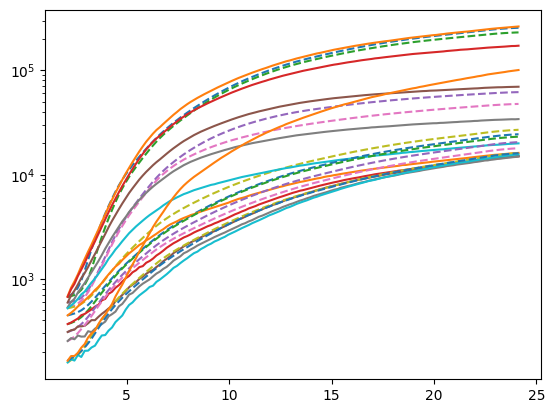

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 0.000e+00  1.541e-01 ...  1.831e+00  1.837e+00]
           x: [ 6.409e+00  4.048e+00 ...  3.866e+00 -8.012e-01]
        cost: 203.74859579801736
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00 -0.000e+00]
               [-2.478e-02 -1.620e-02 ...  0.000e+00 -0.000e+00]
               ...
               [ 1.309e-02 -9.733e-01 ... -7.162e-02 -3.718e-04]
               [ 1.349e-02 -9.727e-01 ... -7.503e-02 -4.295e-04]]
        grad: [ 6.542e-01  9.509e-01 ...  8.132e-01 -3.440e-04]
  optimality: 27.702088358401568
 active_mask: [0 0 ... 0 0]
        nfev: 31
        njev: 16
[6.07348467e+02 5.72980819e+01 1.41099706e+04 2.29108705e+00
 1.65669859e+03 1.18197289e+03 1.20706242e+02 3.01930425e+02
 1.37036029e+02 1.15233545e+02 1.25688272e+02 9.60598597e+01
 8.24863178e+01 9.63779929e+01 4.46037413e+01 7.17591558e+01
 5.71908908e+01 5.18133584e+01 4.61481294e+01 4.78035780e+01
 2.

'\nlcara_not_yfp.characterize( fj,\n    receiver=iptg_rec_yfp,\n    inverter=vector6.id,\n    media=media.id,\n    strain=strain.id,\n    signal=yfp.id,\n    biomass_signal=biomass_signal.id,\n    gamma=0\n)\n'

In [46]:
a = 1e4
b = 1e2
K = 1e4
n = 4
heights = [1e2]*20
initx = np.array([a, b, K, n] + heights)
initx = np.log(initx)
lower_bounds = [-10, -10, 0, 0] + [-10]*20
upper_bounds = [10, 10, 10, np.log(6)] + [10]*20
bounds = [lower_bounds, upper_bounds]

lcara_not_yfp.characterize( fj,
    study=study.id,
    receiver=vector.id[1:2],
    inverter=vector6.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0,
    tmin=2, tmax=25,
    initx=initx,
    bounds=bounds
)
'''
lcara_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector6.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)
'''

In [47]:
np.exp(lcara_not_yfp.res.x)

array([6.07348467e+02, 5.72980819e+01, 1.41099706e+04, 2.29108705e+00,
       1.65669859e+03, 1.18197289e+03, 1.20706242e+02, 3.01930425e+02,
       1.37036029e+02, 1.15233545e+02, 1.25688272e+02, 9.60598597e+01,
       8.24863178e+01, 9.63779929e+01, 4.46037413e+01, 7.17591558e+01,
       5.71908908e+01, 5.18133584e+01, 4.61481294e+01, 4.78035780e+01,
       2.03883555e+01, 5.57151346e+01, 4.77394520e+01, 4.48797719e-01])

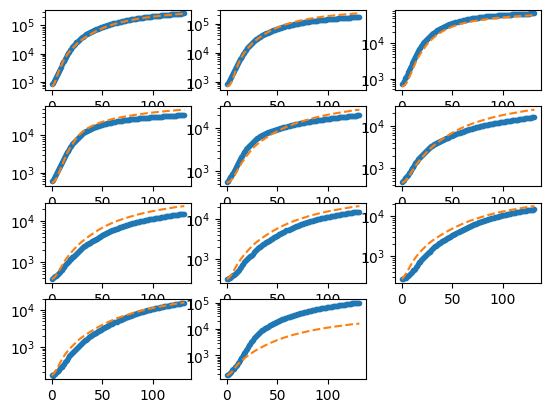

In [48]:
data = lcara_not_yfp.data
model = lcara_not_yfp.model
len(data)
sp = 1
model_curve = []
data_curve = []
for d,m in zip(data,model):
    model_curve.append(m[-1])
    data_curve.append(d[-1])
    plt.subplot(4,3,sp)
    plt.plot(d[1:], '.')
    plt.plot(m[1:], '--')
    plt.yscale('log')
    sp += 1
    

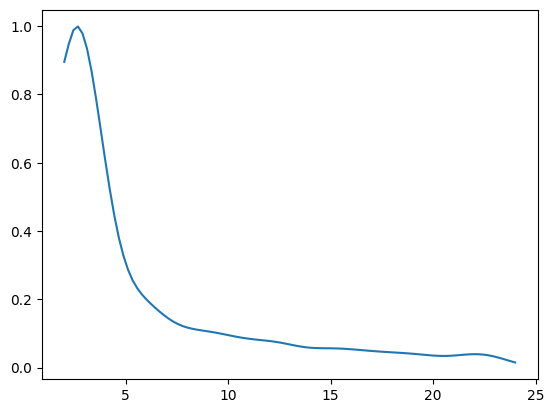

In [49]:
t = np.linspace(2, 24, 100)
plt.plot(t, lcara_not_yfp.profile(t))

In [50]:
lcara_not_yfp.alpha, lcara_not_yfp.K, lcara_not_yfp.n

(array([573410.53531439,  54096.33118973]),
 14109.970610600583,
 2.2910870504209018)

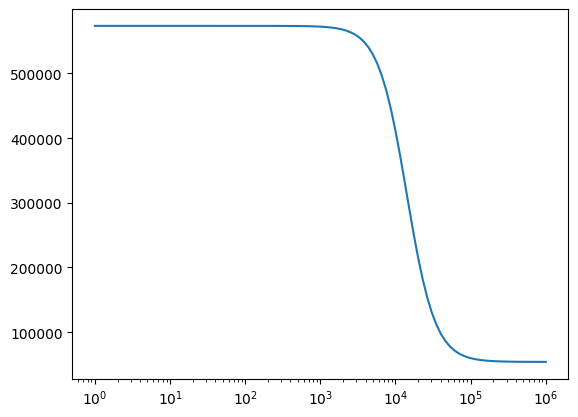

In [51]:
a = lcara_not_yfp.alpha[0]
b = lcara_not_yfp.alpha[1]
K = lcara_not_yfp.K
n = lcara_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## Oscillator

In [184]:
oscillator = lc.GeneticNetwork(vector=0)

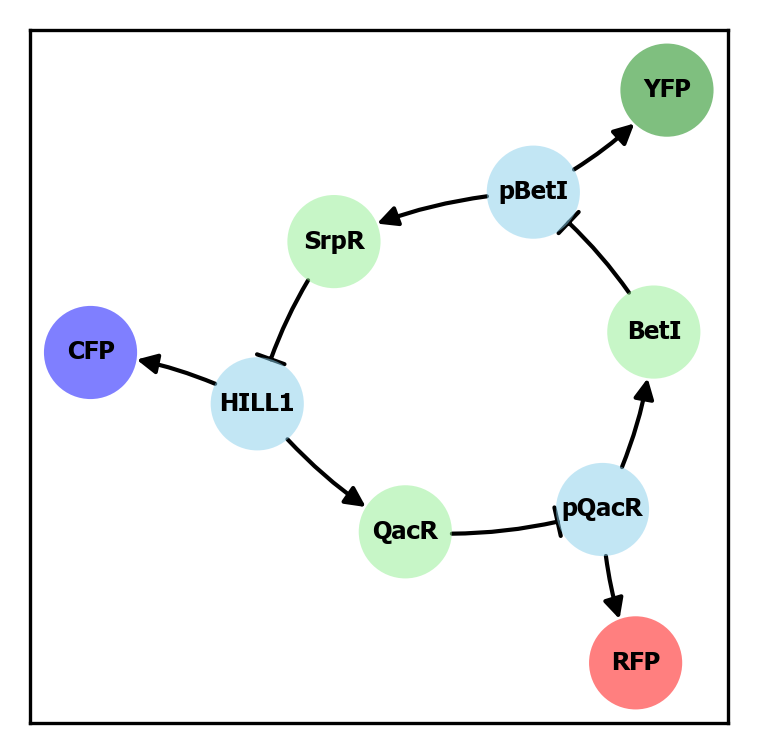

In [185]:
cfp_id = fj.get('signal', name='CFP').id[0]
cfp_rep = lc.Reporter(name='CFP', color='blue', degradation_rate=0, signal_id=cfp_id)
rfp_id = fj.get('signal', name='RFP').id[0]
rfp_rep = lc.Reporter(name='RFP', color='red', degradation_rate=0, signal_id=rfp_id)
yfp_rep.degradation_rate = 0

oscillator.add_reporter([yfp_rep,cfp_rep,rfp_rep])

oscillator.add_regulator([beti_reg, srpr_reg, qacr_reg])

beti_not_srpr = beti_not_yfp
beti_not_srpr.input = beti_reg
beti_not_srpr.output = [srpr_reg, yfp_rep]
beti_not_srpr.degradation_rate = 0
beti_not_srpr.alpha_orig = beti_not_srpr.alpha
beti_not_srpr.K_orig = beti_not_srpr.K
beti_not_srpr.alpha /= beti_not_srpr.K
beti_not_srpr.K = 1

srpr_not_qacr = srpr_not_yfp
srpr_not_qacr.input = srpr_reg
srpr_not_qacr.output = [qacr_reg, cfp_rep]
srpr_not_qacr.degradation_rate = 0
srpr_not_qacr.alpha_orig = srpr_not_qacr.alpha
srpr_not_qacr.K_orig = srpr_not_qacr.K
srpr_not_qacr.alpha /= srpr_not_qacr.K
srpr_not_qacr.K = 1

qacr_not_beti = qacr_not_yfp
qacr_not_beti.input = qacr_reg
qacr_not_beti.output = [beti_reg, rfp_rep]
qacr_not_beti.degradation_rate = 0
qacr_not_beti.alpha_orig = srpr_not_qacr.alpha
qacr_not_beti.K_orig = qacr_not_beti.K
qacr_not_beti.alpha /= qacr_not_beti.K
qacr_not_beti.K = 1

oscillator.add_operator([beti_not_srpr, srpr_not_qacr, qacr_not_beti])

plt.figure(figsize=(3,3), dpi=300)
oscillator.draw()

In [186]:
srpr_reg.init_concentration = 1
beti_reg.init_concentration = 0
qacr_reg.init_concentration = 0
cfp_rep.init_concentration = 0
yfp_rep.init_concentration = 1
rfp_rep.init_concentration = 0

Get a growth profile from the inverter data to use for simulations

In [187]:
from scipy.interpolate import interp1d
inv_biomass_df = fj.analysis(vector=vector2.id,
                            study=study.id,
                            signal=biomass_signal.id,
                            media=media.id,
                            strain=strain.id,
                            type='Background Correct',
                            biomass_signal=biomass_signal.id)
inv_gr_df = flap.expression_rate_inverse(inv_biomass_df, inv_biomass_df)
odval = inv_biomass_df.groupby('Time').mean().Measurement.values
t = inv_biomass_df.groupby('Time').mean().index.values
grval = inv_gr_df.groupby('Time').mean().Rate.values

od = interp1d(t, odval, bounds_error=False, fill_value='extrapolate')
gr = interp1d(t, grval, bounds_error=False, fill_value='extrapolate')

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


Returning dataframe
Computing inverse expression rate of sample 1 of 48
Computing inverse expression rate of sample 2 of 48
Computing inverse expression rate of sample 3 of 48
Computing inverse expression rate of sample 4 of 48
Computing inverse expression rate of sample 5 of 48
Computing inverse expression rate of sample 6 of 48
Computing inverse expression rate of sample 7 of 48
Computing inverse expression rate of sample 8 of 48
Computing inverse expression rate of sample 9 of 48
Computing inverse expression rate of sample 10 of 48
Computing inverse expression rate of sample 11 of 48
Computing inverse expression rate of sample 12 of 48
Computing inverse expression rate of sample 13 of 48
Computing inverse expression rate of sample 14 of 48
Computing inverse expression rate of sample 15 of 48
Computing inverse expression rate of sample 16 of 48
Computing inverse expression rate of sample 17 of 48
Computing inverse expression rate of sample 18 of 48
Computing inverse expression rate o

In [188]:
def growth_rate(t):
    return gr(t) # lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return od(t) # lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=oscillator, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=1000, 
              interval=0.025,
              name='LOICA repressilator',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

100%|███████████████████████████████████████████████████████████▉| 99.9999999999986/100 [00:15<00:00,  6.32it/s]


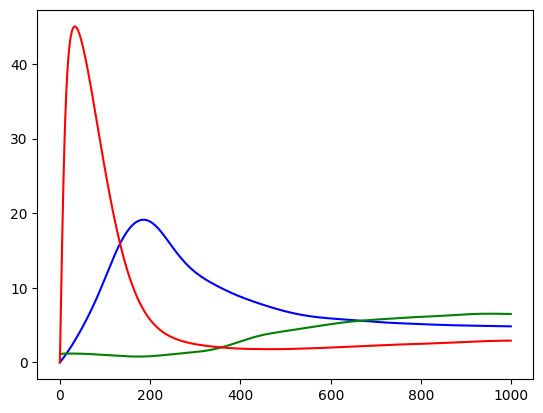

In [190]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
c = m[m.Signal=='CFP'].Measurement.values / m[m.Signal=='Biomass'].Measurement.values
y = m[m.Signal=='YFP'].Measurement.values / m[m.Signal=='Biomass'].Measurement.values
r = m[m.Signal=='RFP'].Measurement.values / m[m.Signal=='Biomass'].Measurement.values
plt.plot(c, 'b')
plt.plot(y, 'g')
plt.plot(r, 'r')
plt.savefig('LOICARepressilator.png', dpi=300)

In [79]:
sim_rate_df = flap.expression_rate_inverse(m, m[m.Signal=='Biomass'])

Computing inverse expression rate of sample 1 of 1


In [80]:
srpr_not_qacr.K, beti_not_srpr.K, qacr_not_beti.K, l

(8263.029900399513, 15024.813291578172, 6573.282168556034)

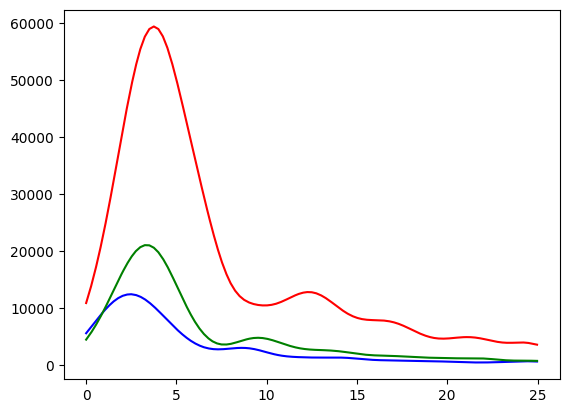

In [81]:
fig,ax = plt.subplots(1,1)
x = sim_rate_df[sim_rate_df.Signal=='CFP'].Time.values
y = sim_rate_df[sim_rate_df.Signal=='CFP'].Rate.values #/ srpr_not_qacr.K
ax.plot(x, y, 'b')
x = sim_rate_df[sim_rate_df.Signal=='YFP'].Time.values
y = sim_rate_df[sim_rate_df.Signal=='YFP'].Rate.values #/ beti_not_srpr.K
ax.plot(x, y, 'g')
x = sim_rate_df[sim_rate_df.Signal=='RFP'].Time.values
y = sim_rate_df[sim_rate_df.Signal=='RFP'].Rate.values #/ qacr_not_beti.K
ax.plot(x, y, 'r')

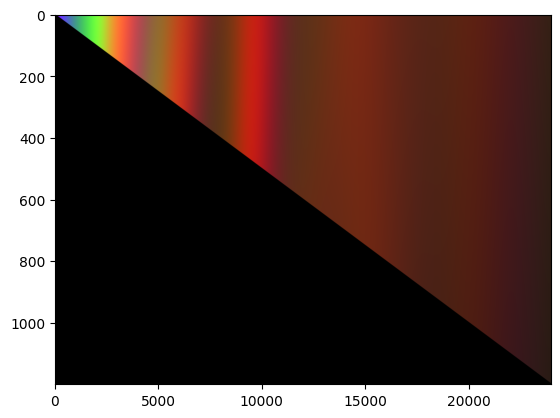

In [128]:
col = lc.Colony(circuit=oscillator, r0=50, mu0=np.log(2)/(28/60))
kymo = col.kymograph(600, 0, 24)
rkymo = col.map_kymo(kymo)
nrkymo = col.norm_kymo(rkymo)
plt.imshow(nrkymo, aspect='auto')

# Repressilator generator

In [201]:
np.save('srpr_not_yfp.npy', [srpr_not_yfp.alpha[0], srpr_not_yfp.alpha[1], srpr_not_yfp.K, srpr_not_yfp.n])
np.save('beti_not_yfp.npy', [beti_not_yfp.alpha[0], beti_not_yfp.alpha[1], beti_not_yfp.K, beti_not_yfp.n])
np.save('qacr_not_yfp.npy', [qacr_not_yfp.alpha[0], qacr_not_yfp.alpha[1], qacr_not_yfp.K_orig, qacr_not_yfp.n])
np.save('bm3r1_not_yfp.npy', [bm3r1_not_yfp.alpha[0], bm3r1_not_yfp.alpha[1], bm3r1_not_yfp.K, bm3r1_not_yfp.n])
np.save('lcara_not_yfp.npy', [lcara_not_yfp.alpha[0], lcara_not_yfp.alpha[1], lcara_not_yfp.K, lcara_not_yfp.n])

In [82]:
from itertools import permutations 

In [202]:
srpr_reg = lc.Regulator('SrpR', degradation_rate=0)
beti_reg = lc.Regulator('BetI', degradation_rate=0)
qacr_reg = lc.Regulator('QacR', degradation_rate=0)
bm3r1_reg = lc.Regulator('BM3R1', degradation_rate=0)
lcara_reg = lc.Regulator('lcaRA', degradation_rate=0)

NOT_SrpR = [srpr_reg, srpr_not_yfp.alpha[0], srpr_not_yfp.alpha[1], srpr_not_yfp.K, srpr_not_yfp.n, srpr_not_yfp.profile]
NOT_BetI = [beti_reg, beti_not_yfp.alpha[0], beti_not_yfp.alpha[1], beti_not_yfp.K, beti_not_yfp.n, beti_not_yfp.profile]
NOT_QacR = [qacr_reg, qacr_not_yfp.alpha[0], qacr_not_yfp.alpha[1], qacr_not_yfp.K, qacr_not_yfp.n, qacr_not_yfp.profile]
NOT_BM3R1 = [bm3r1_reg, bm3r1_not_yfp.alpha[0], bm3r1_not_yfp.alpha[1], bm3r1_not_yfp.K, bm3r1_not_yfp.n, bm3r1_not_yfp.profile]
NOT_lcaRA = [lcara_reg, lcara_not_yfp.alpha[0], lcara_not_yfp.alpha[1], lcara_not_yfp.K, lcara_not_yfp.n, lcara_not_yfp.profile]

perms = []
perm = permutations([NOT_SrpR, 
                     NOT_BetI,
                     NOT_QacR,
                     NOT_BM3R1,
                     NOT_lcaRA,
                    ],3)  #with a larger list then we can do ([NOT_1, NOT_2, NOT_3],3)
for i in list(perm):  
    perms.append(i) 

print(perms)

[([<loica.geneproduct.Regulator object at 0x7fe6aeec4ca0>, 223556.94490485196, 6476.561894283118, 8263.029900399513, 4.177653633524532, <scipy.interpolate._interpolate.interp1d object at 0x7fe6aa8dc450>], [<loica.geneproduct.Regulator object at 0x7fe6aeec4070>, 386381.37857985555, 6825.485980041649, 15024.813291578172, 1.9217974920711958, <scipy.interpolate._interpolate.interp1d object at 0x7fe6a92f34f0>], [<loica.geneproduct.Regulator object at 0x7fe6aeec4b20>, 1273281.824469563, 16818.94761319926, 6573.282168556034, 2.37544442359394, <scipy.interpolate._interpolate.interp1d object at 0x7fe8c50b2310>]), ([<loica.geneproduct.Regulator object at 0x7fe6aeec4ca0>, 223556.94490485196, 6476.561894283118, 8263.029900399513, 4.177653633524532, <scipy.interpolate._interpolate.interp1d object at 0x7fe6aa8dc450>], [<loica.geneproduct.Regulator object at 0x7fe6aeec4070>, 386381.37857985555, 6825.485980041649, 15024.813291578172, 1.9217974920711958, <scipy.interpolate._interpolate.interp1d object 

100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:03<00:00, 32.75it/s]
100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:02<00:00, 44.55it/s]
100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:02<00:00, 35.09it/s]
100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:02<00:00, 37.36it/s]
100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:02<00:00, 41.46it/s]
100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:02<00:00, 44.72it/s]
100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:02<00:00, 47.37it/s]
100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:02<00:00, 48.23it/s]
100%|██████████████████████████████████████████████████████████▉| 99.99999999999966/100 [00:02<0

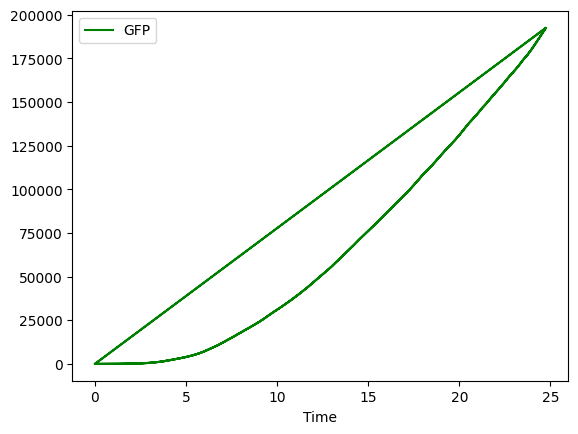

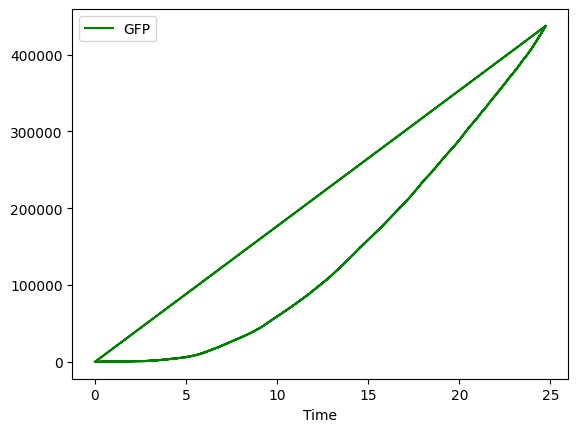

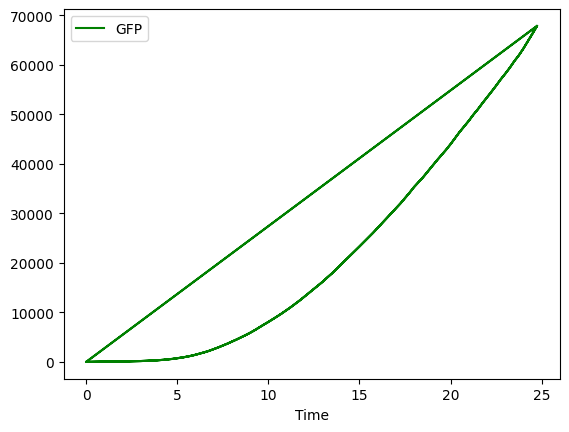

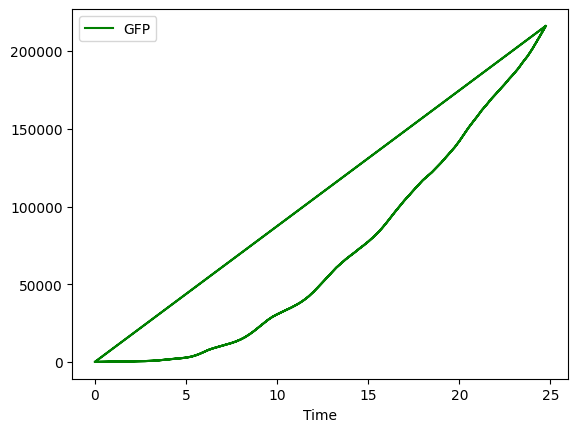

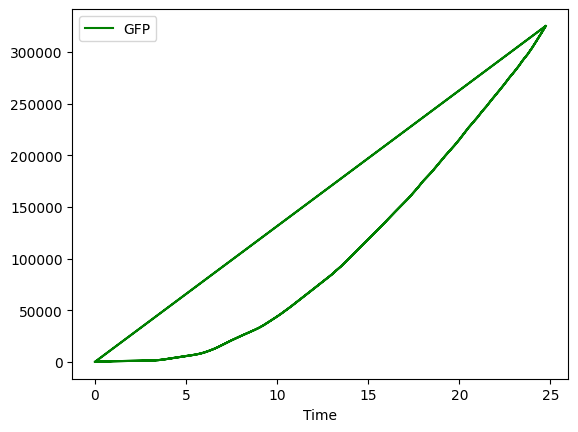

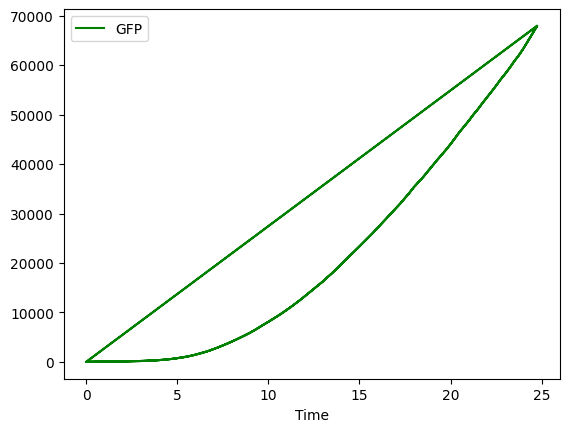

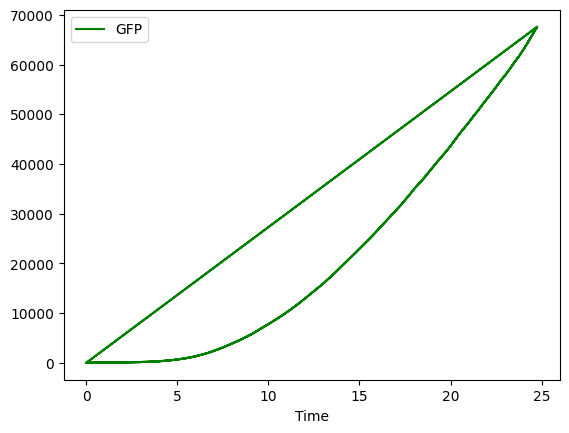

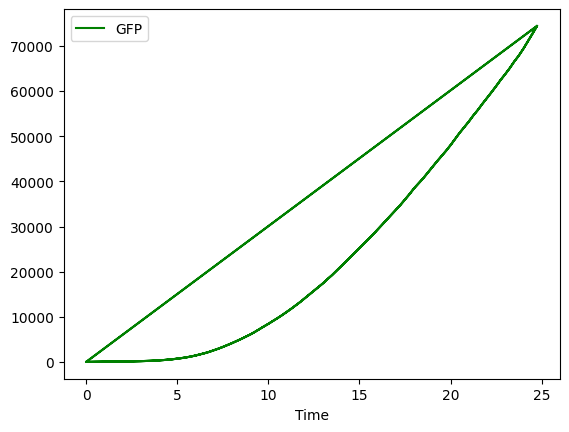

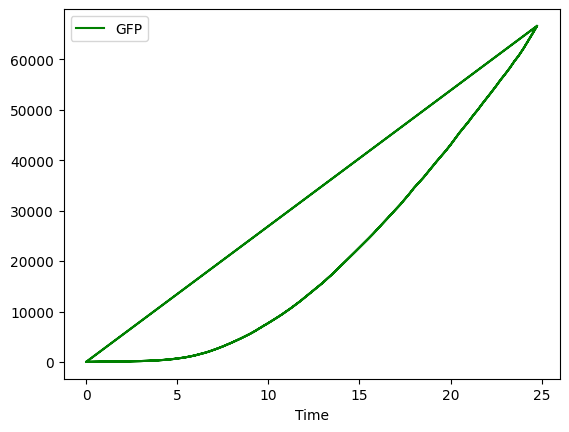

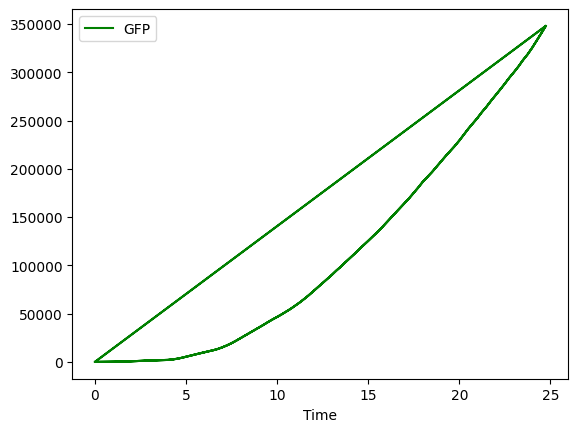

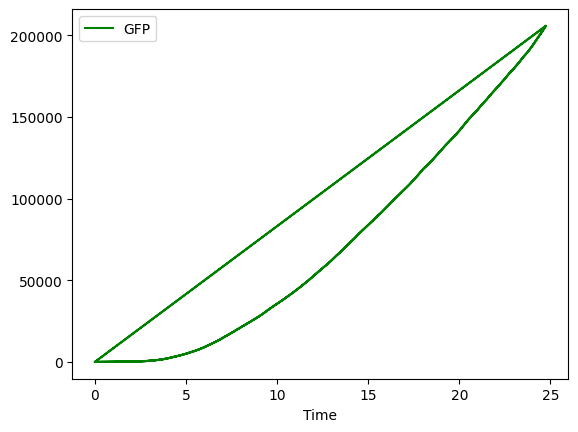

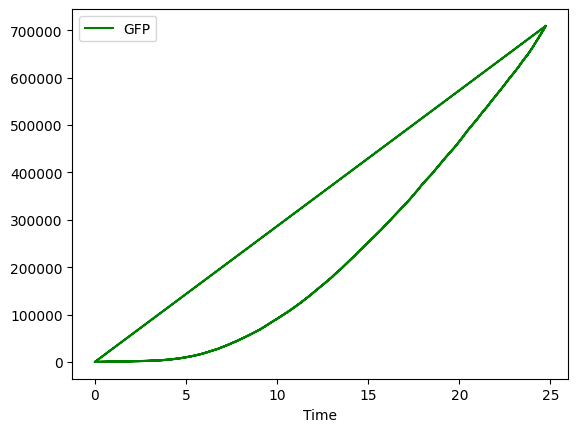

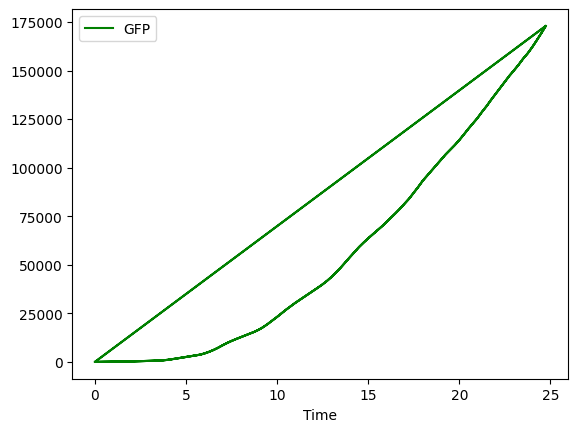

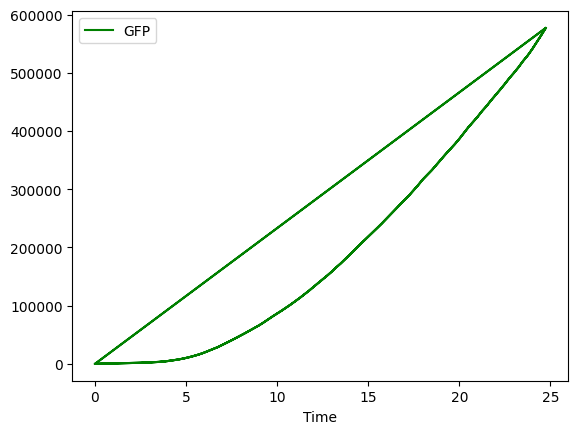

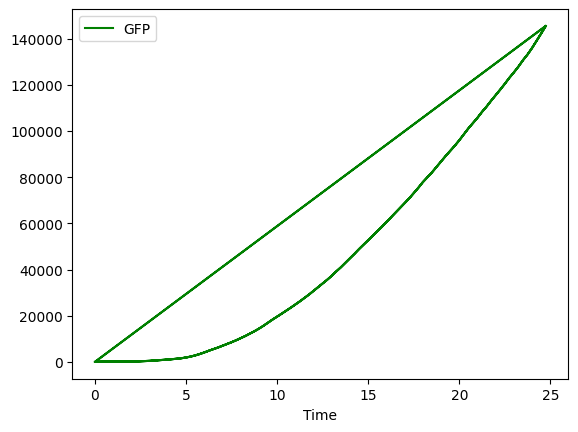

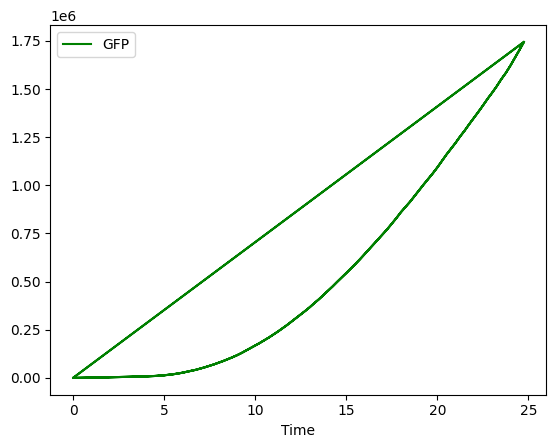

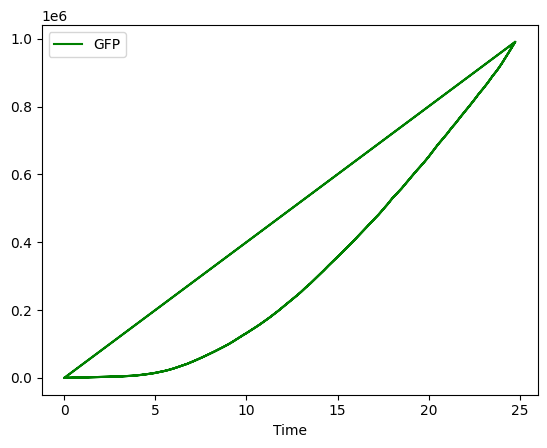

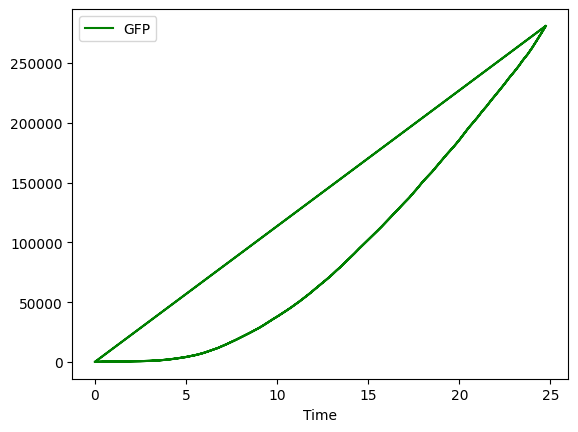

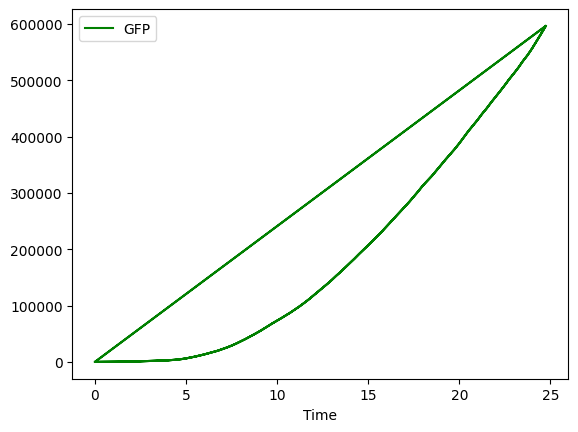

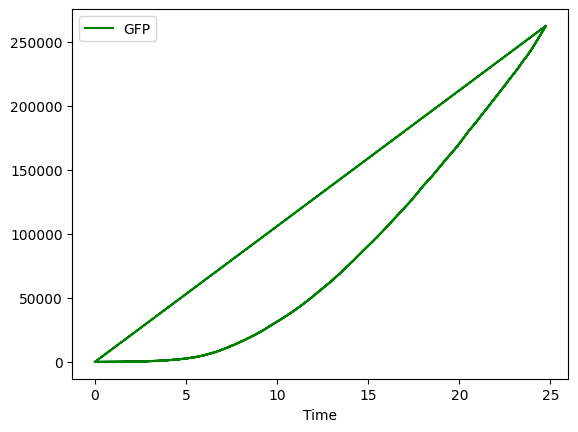

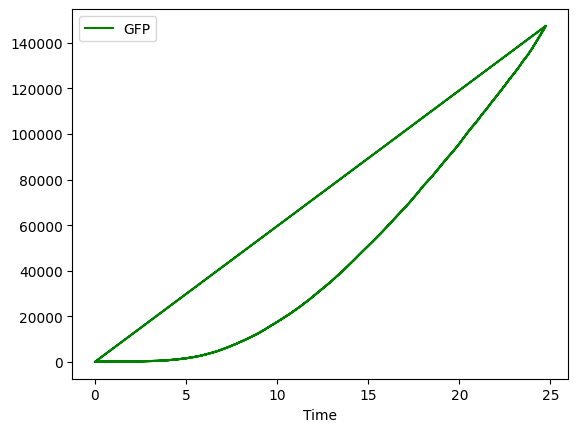

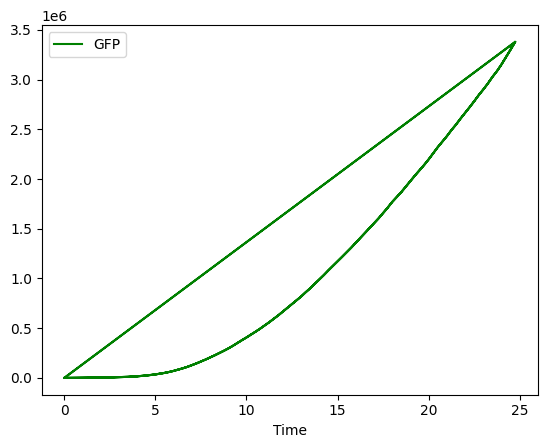

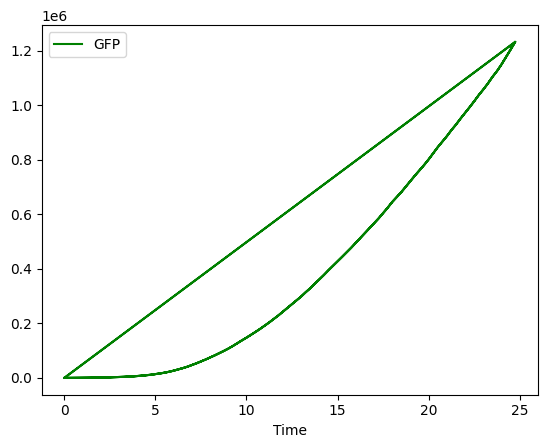

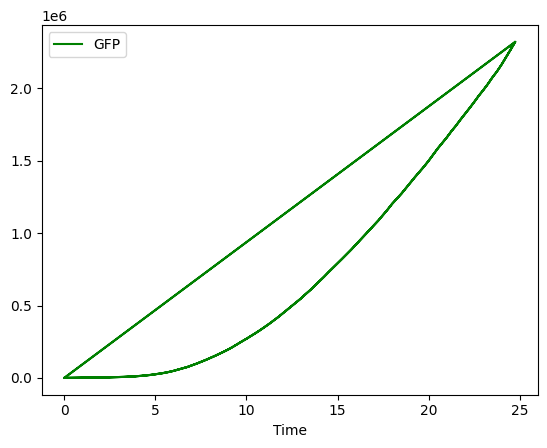

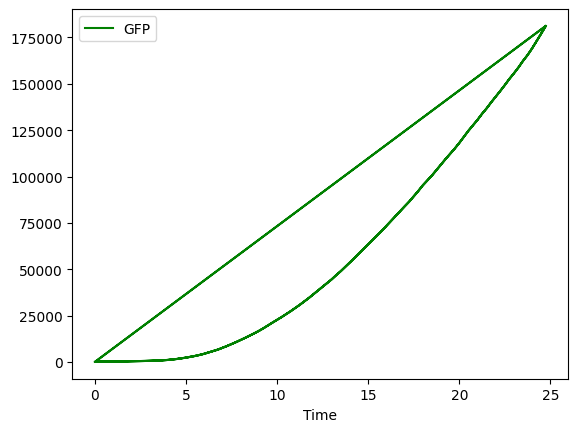

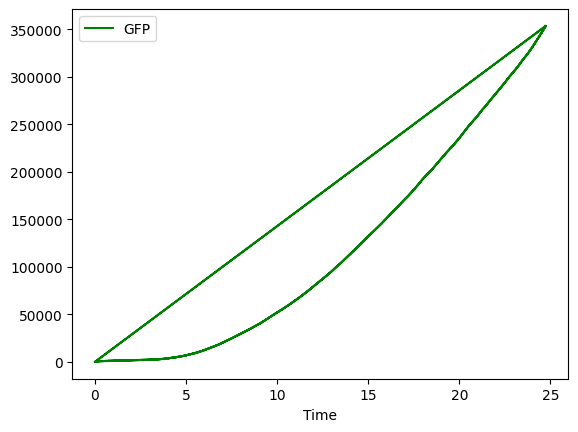

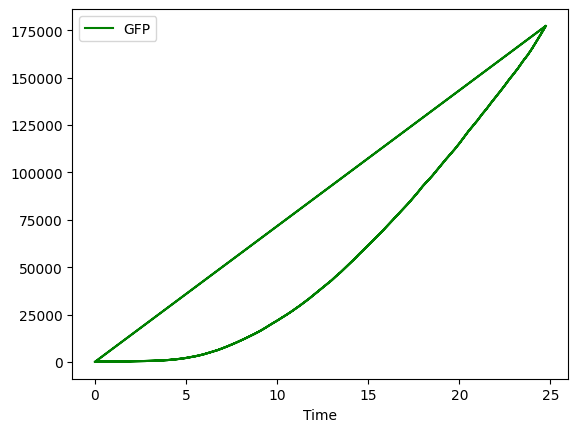

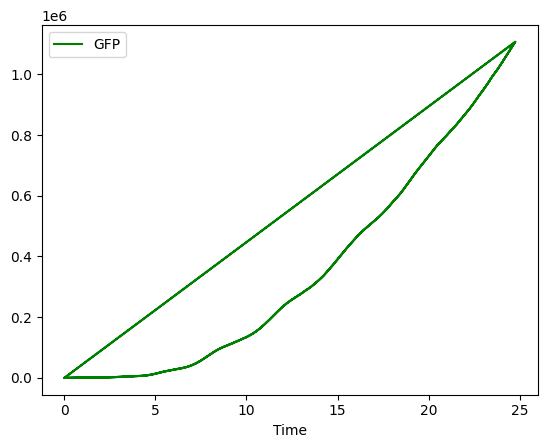

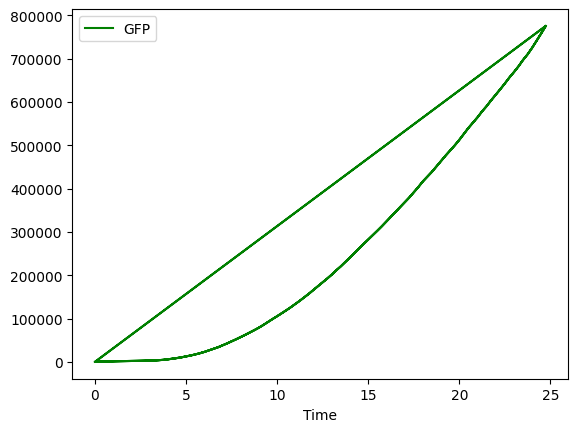

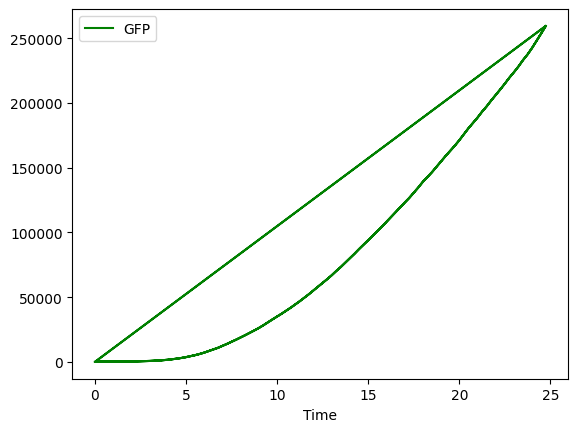

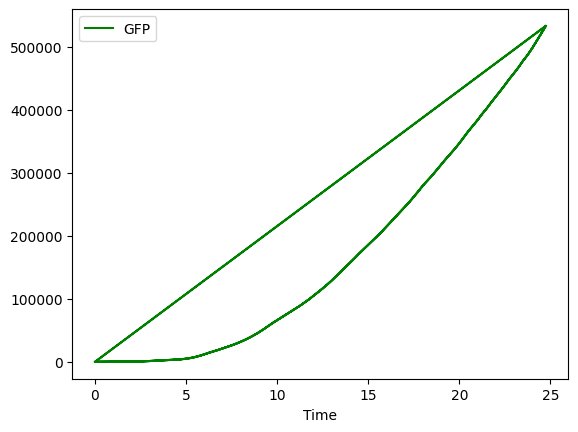

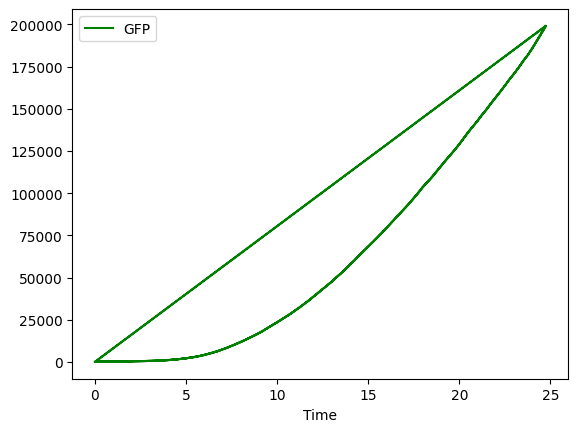

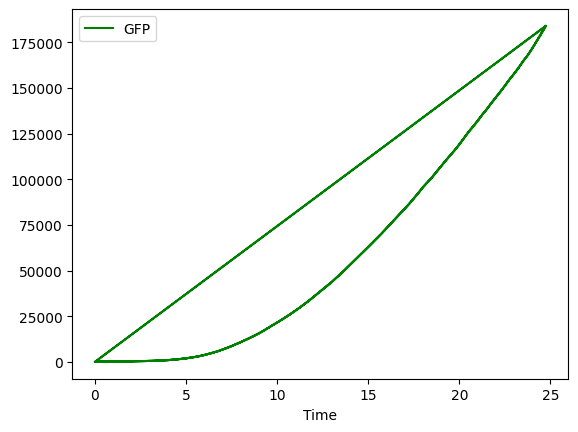

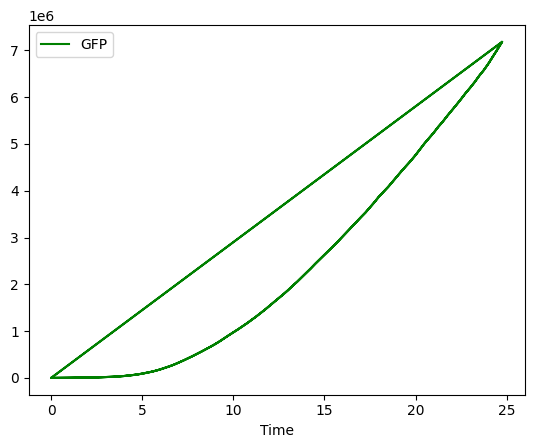

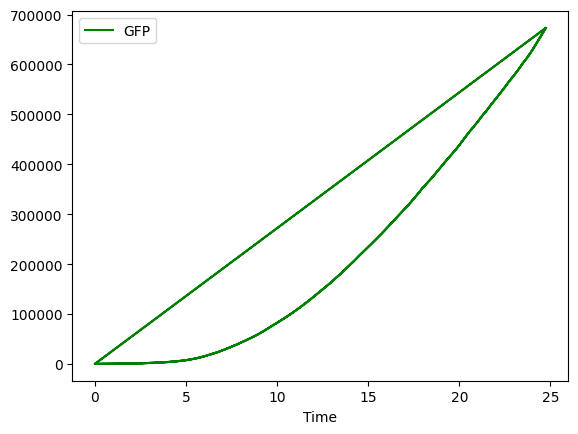

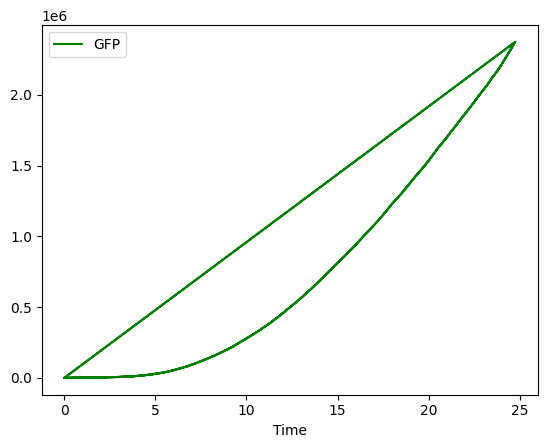

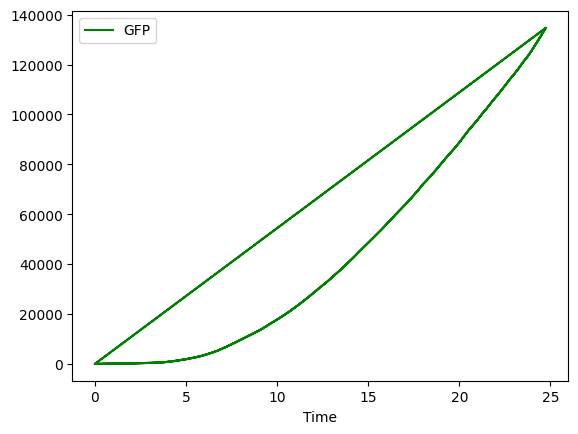

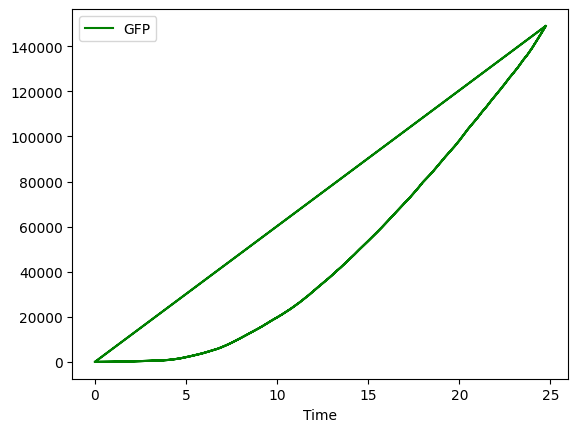

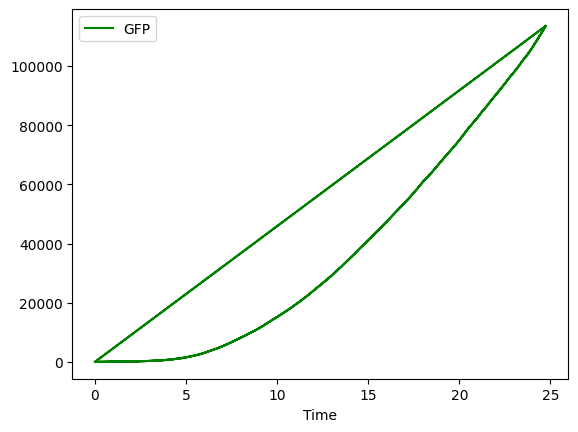

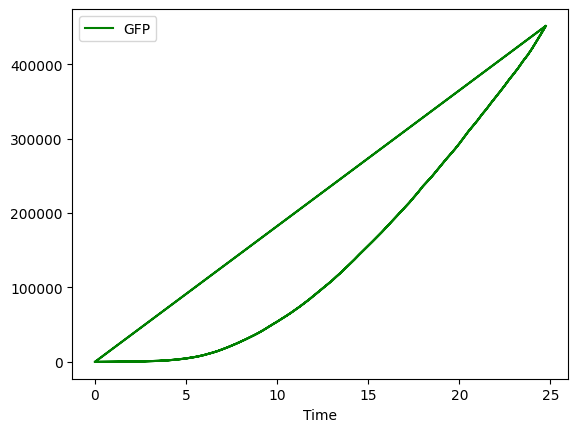

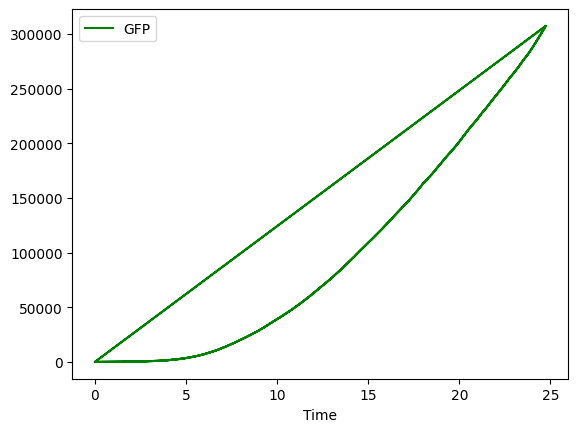

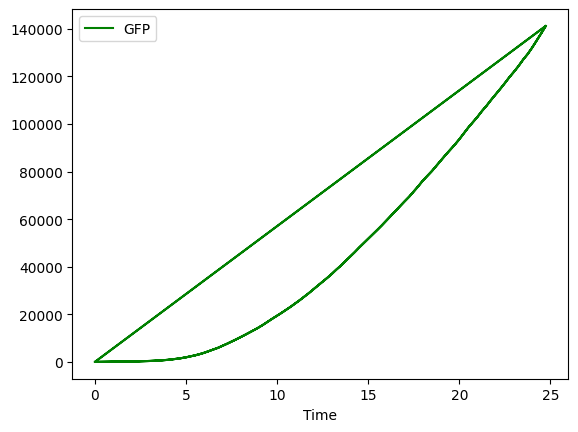

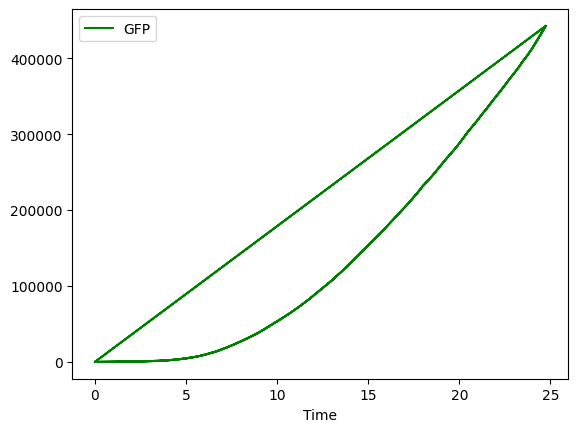

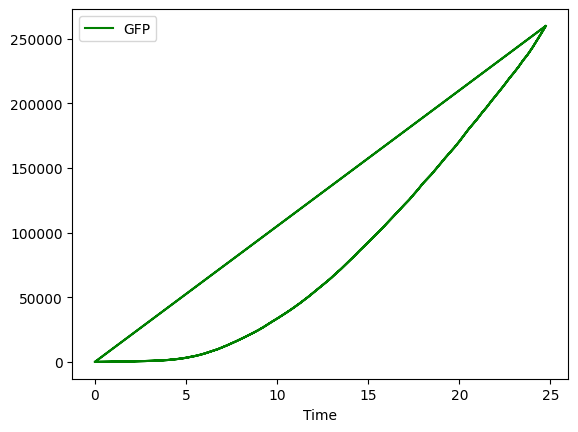

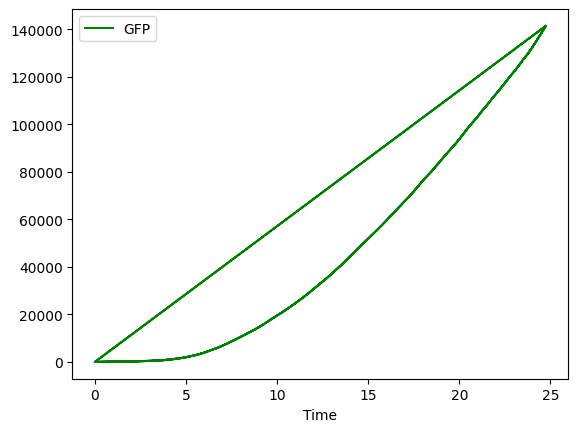

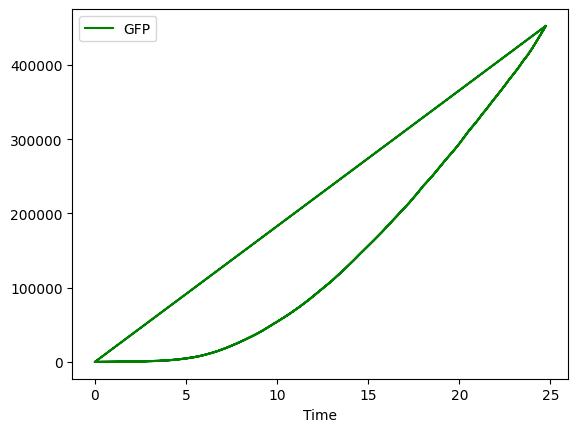

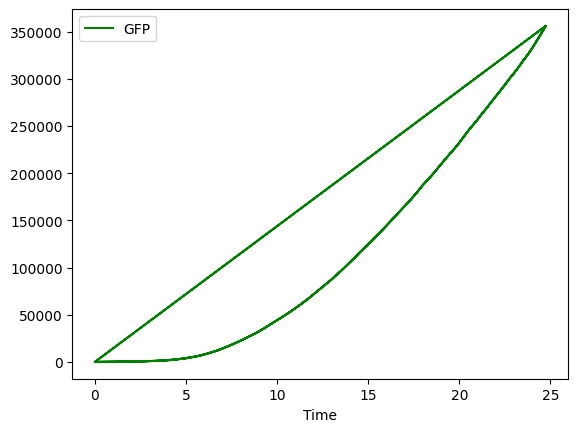

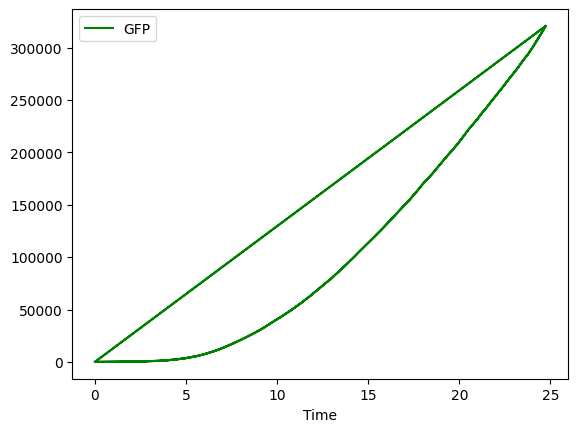

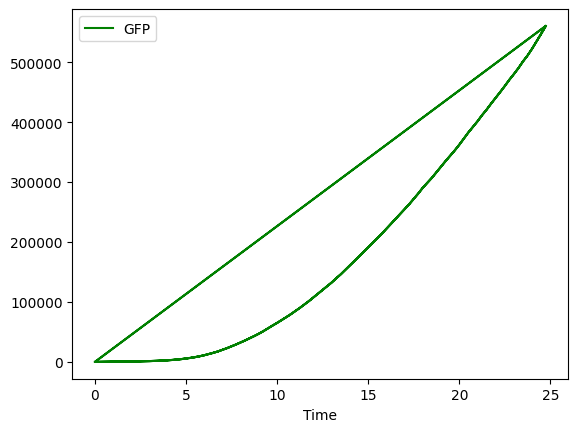

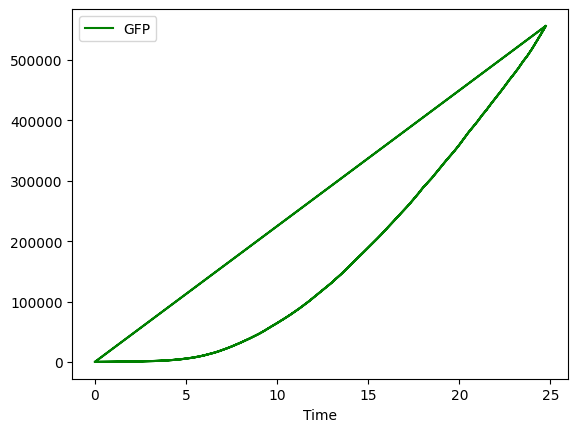

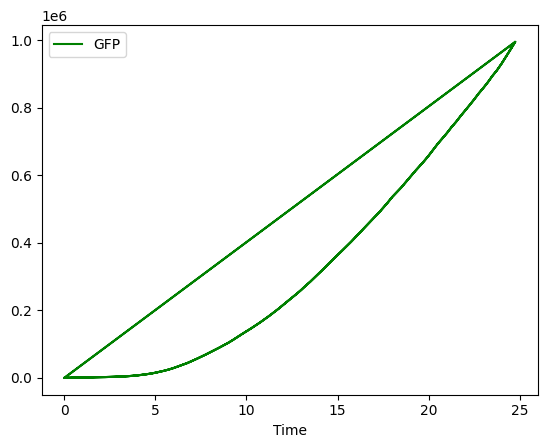

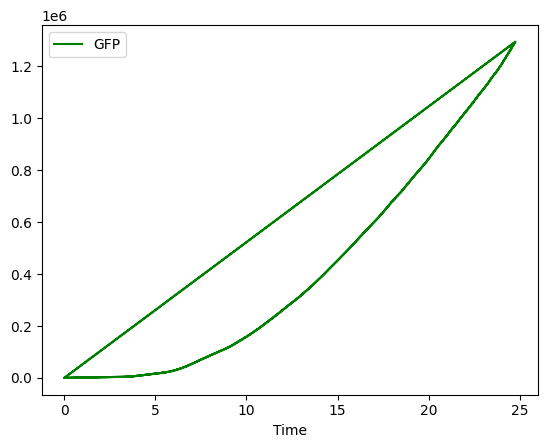

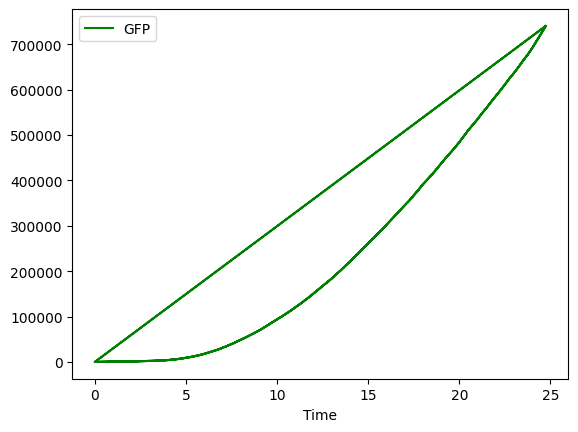

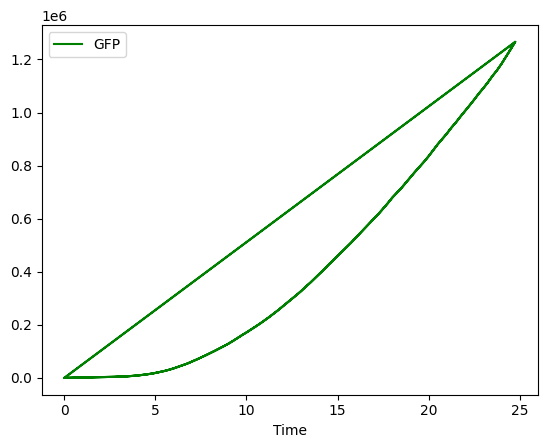

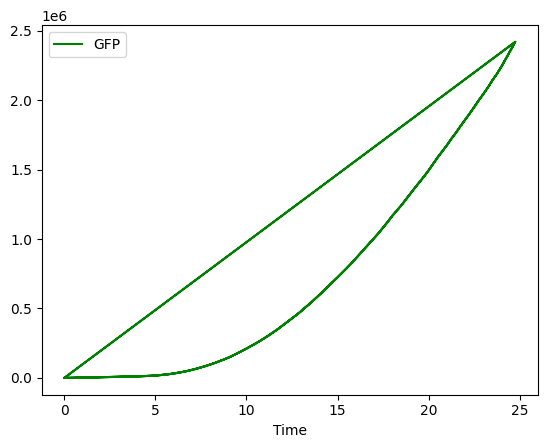

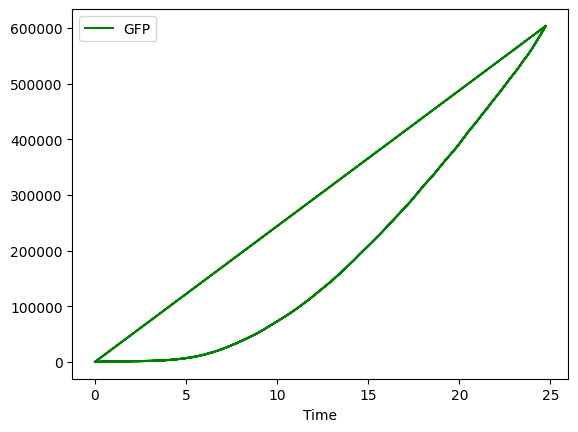

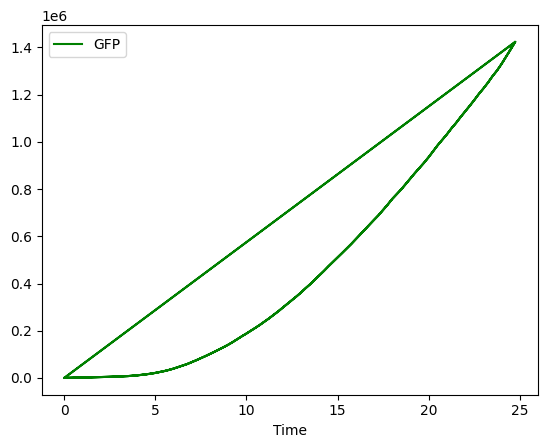

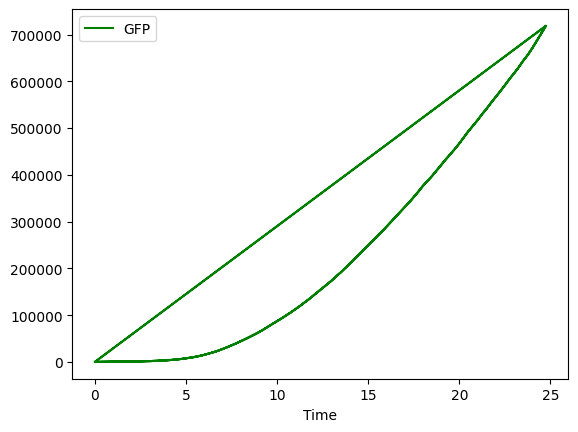

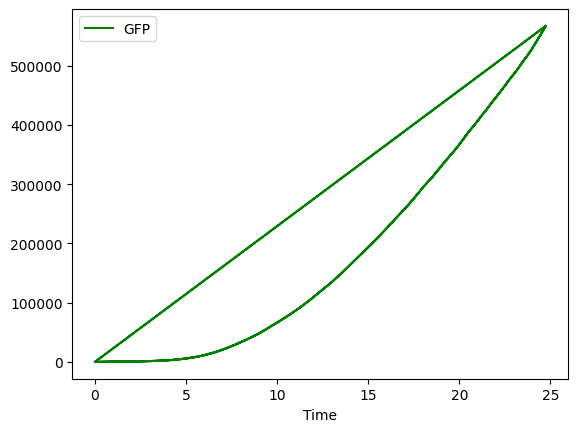

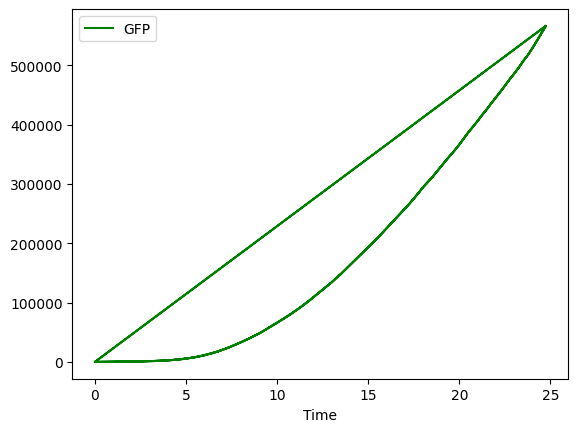

In [84]:
i=0
def growth_rate(t):
    return gr(t) #lc.gompertz_growth_rate(t, 0.01, 1, 1, 4)

def biomass(t):
    return od(t) #lc.gompertz(t, 0.01, 1, 1, 4)

gfp = lc.Reporter(name='GFP', degradation_rate=0, signal_id=0)

for op in perms:

  rep = lc.GeneticNetwork(vector=0) #add a propoer and identifiable name
  rep.add_regulator([op[0][0],op[1][0], op[2][0]]) #add regulators
  rep.add_reporter(gfp)#[cfp, yfp, rfp]) 
  #build dynamics NOTs, 1000 times to do MEFL
  scalar = 1
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=op[1][0], alpha=[op[0][1]*scalar,op[0][2]]*scalar, K=op[0][3]*scalar, n=op[0][4], profile=op[0][5]),
                     lc.Hill1(input=op[1][0], output=op[2][0], alpha=[op[1][1]*scalar,op[1][2]]*scalar, K=op[1][3]*scalar, n=op[1][4], profile=op[1][5]),
                     lc.Hill1(input=op[2][0], output=op[0][0], alpha=[op[2][1]*scalar,op[2][2]]*scalar, K=op[2][3]*scalar, n=op[2][4], profile=op[2][5])
                     ])
 
  #build reporter NOTs
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=gfp, alpha=[op[0][1]*scalar,op[0][2]]*scalar, K=op[0][3]*scalar, n=op[0][4], profile=op[0][5]),
                     #lc.Hill1(input=op[1][0], output=yfp, alpha=[op[1][1]*scalar,op[1][2]]*scalar, K=op[1][3]*scalar, n=op[1][4]),
                     #lc.Hill1(input=op[2][0], output=rfp, alpha=[op[2][1]*scalar,op[2][2]]*scalar, K=op[2][3]*scalar, n=op[2][4])
                     ])
  
  #AS
  metab = lc.SimulatedMetabolism('SimMetab',biomass, growth_rate)

  samples = []
  # Create 3 replicate samples for simulation
  for _ in range(3):
      sample = lc.Sample(genetic_network=rep, 
                      metabolism=metab)
      samples.append(sample)

  assay = lc.Assay(samples, 
              n_measurements=100, 
              interval=0.25,
              name='Loica repressilator',
              description='Simulated repressilator generated by loica',
              biomass_signal_id=0
             )
  assay.run()
  m = assay.measurements
  fig,ax = plt.subplots(1,1)
  m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
  plt.savefig(f'LOICARepressilator{i}.png', dpi=300)
  i+=1
  

100%|███████████████████████████████████████████████████████████████████████| 100.0/100 [00:01<00:00, 62.06it/s]


([<loica.geneproduct.Regulator object at 0x7fe6aeec4ca0>, 223556.94490485196, 6476.561894283118, 8263.029900399513, 4.177653633524532, <scipy.interpolate._interpolate.interp1d object at 0x7fe6aa8dc450>], [<loica.geneproduct.Regulator object at 0x7fe6aeec4070>, 386381.37857985555, 6825.485980041649, 15024.813291578172, 1.9217974920711958, <scipy.interpolate._interpolate.interp1d object at 0x7fe6a92f34f0>], [<loica.geneproduct.Regulator object at 0x7fe6aeec4b20>, 1273281.824469563, 16818.94761319926, 6573.282168556034, 2.37544442359394, <scipy.interpolate._interpolate.interp1d object at 0x7fe8c50b2310>])


ValueError: setting an array element with a sequence.

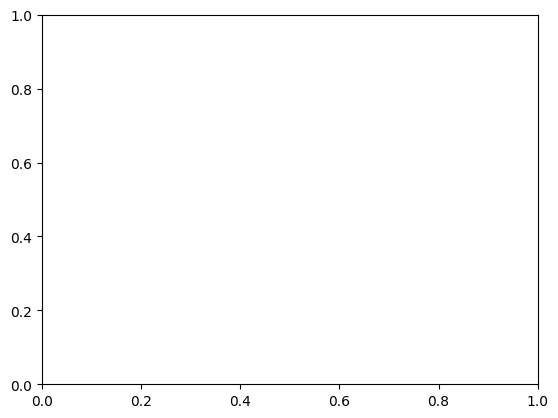

In [204]:
def growth_rate(t):
    return 1 # gr(t) # lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return 1 # od(t) # lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

#Create the main df that will contain all the generated data
columns = {'Measurement':[], 'Sample':[], 'Signal':[], 'Signal_id':[], 'Time':[]}
repgen_df = pd.DataFrame(columns)

#build reporters
cfp = lc.Reporter(name='CFP', degradation_rate=0, signal_id=fj.get('signal', name='CFP').id[0])
yfp = lc.Reporter(name='YFP', degradation_rate=0, signal_id=fj.get('signal', name='YFP').id[0])
rfp = lc.Reporter(name='RFP', degradation_rate=0, signal_id=fj.get('signal', name='RFP').id[0])


for op in perms:
    #GNC
    rep = lc.GeneticNetwork(vector=0) #add a propoer and identifiable name
    rep.add_regulator([op[0][0],op[1][0], op[2][0]]) #add regulators
    rep.add_reporter([cfp, yfp, rfp]) 
    #build dynamics NOTs, 1000 times to do MEFL
    rep.add_operator([
                     lc.Hill1(input=op[0][0], output=op[1][0], alpha=[op[0][1],op[0][2]], K=op[0][3], n=op[0][4]),
                     lc.Hill1(input=op[1][0], output=op[2][0], alpha=[op[1][1],op[1][2]], K=op[1][3], n=op[1][4]),
                     lc.Hill1(input=op[2][0], output=op[0][0], alpha=[op[2][1],op[2][2]], K=op[2][3], n=op[2][4])
                     ])

    #build reporter NOTs
    rep.add_operator([
                     lc.Hill1(input=op[0][0], output=cfp, alpha=[op[0][1],op[0][2]], K=op[0][3], n=op[0][4]),
                     lc.Hill1(input=op[1][0], output=yfp, alpha=[op[1][1],op[1][2]], K=op[1][3], n=op[1][4]),
                     lc.Hill1(input=op[2][0], output=rfp, alpha=[op[2][1],op[2][2]], K=op[2][3], n=op[2][4])
                     ])

    #AS
    metab = lc.SimulatedMetabolism('SimMetab',biomass, growth_rate)

    sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=0,
                strain=0
               )
    assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='Loica repressilator',
              description='Simulated repressilator generated by loica',
              biomass_signal_id=0
             )
    assay.run()
    assay.measurements['Sample'] = f'rg_{op[0][0]}_{op[1][0]}_{op[2][0]}'
    repgen_df = repgen_df.append(assay.measurements, ignore_index=True)
    m = assay.measurements
    fig,ax = plt.subplots(1,1)
    c = m[m.Signal=='CFP'].Measurement.values #/ m[m.Signal=='Biomass'].Measurement.values / op[0][3]
    y = m[m.Signal=='YFP'].Measurement.values #/ m[m.Signal=='Biomass'].Measurement.values / op[1][3]
    r = m[m.Signal=='RFP'].Measurement.values #/ m[m.Signal=='Biomass'].Measurement.values / op[2][3]
    print(op)
    plt.plot(c, 'b')
    plt.plot(y, 'g')
    plt.plot(r, 'r')
    #m[m.Signal=='CFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[0][0]}_{op[0][1]}_cfp')
    #m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[1][0]}_{op[1][1]}_yfp')
    #m[m.Signal=='RFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[2][0]}_{op[2][1]}_rfp')
    plt.savefig(f'LOICARepressilator_{op[0][0]}_{op[1][0]}_{op[2][0]}.png', dpi=300)

    #fig,ax = plt.subplots(1,1)
    #col = lc.Colony(circuit=rep, r0=50, mu0=np.log(2)/(28/60))
    #kymo = col.kymograph(600, 0, 24)
    #rkymo = col.map_kymo(kymo)
    #nrkymo = col.norm_kymo(rkymo)
    #ax.imshow(nrkymo, aspect='auto')
    #plt.savefig(f'LOICARepressilator_kymo_{op[0][0]}_{op[1][0]}_{op[2][0]}.png', dpi=300)
    
    #fig,ax = plt.subplots(1,1)
    #er = flap.expression_rate_inverse(m, m[m.Signal=='Biomass'])
    #er[er.Signal=='CFP'].plot(x='Time', y='Rate', ax=ax, label=f'{op[0][0]}_{op[0][1]}_cfp')
    #er[er.Signal=='YFP'].plot(x='Time', y='Rate', ax=ax, label=f'{op[1][0]}_{op[1][1]}_yfp')
    #er[er.Signal=='RFP'].plot(x='Time', y='Rate', ax=ax, label=f'{op[2][0]}_{op[2][1]}_rfp')
    #plt.savefig(f'LOICARepressilator_rate_{op[0][0]}_{op[1][0]}_{op[2][0]}.png', dpi=300)